In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
import catboost
from catboost import CatBoostClassifier


In [3]:
import warnings
warnings.filterwarnings('ignore')

Функция, принимающую на вход матрицу ```X``` и некоторое число ```a``` и возвращающую ближайший к числу элемент матрицы.

In [4]:
def nearest_value(array, number):
    diff = array - number
    mask = np.ma.less_equal(diff, 0)
    masked_diff = np.ma.masked_array(diff, mask)
    return (masked_diff.argmin())

Функция, которая на вход принимает вектор ```x```, содержащий целые числа, кроме 0, а возвращает вектор со вставленными нулями между числами.

In [5]:
def add_zeros(array):
    x = list(range(1, len(array)))
    a = np.insert(array, x, [0])
    return a

Функция для подсчёта произведения ненулевых элементов на диагонали прямоугольной матрицы

Например, для ```X = np.array([[1, 0, 1], [2, 0, 2], [3, 0, 3], [4, 4, 4]])``` ответом является 3. Если ненулевых элементов нет, функция возвращает ```None```.

In [6]:
def nonzero_product(X):
    x = np.diag(X)
    b = x > 0
    pr = x[b]
    if np.any(x) > 0:
        return pr.prod()
    else:
        return None 

Массив из функций, вычисляющих произведение числа на константу

In [7]:
def lambda_init(i):
    return lambda x: x * i

functions = [lambda_init(i)  for i in range(10)]

for f in functions:
    print(f(1))

0
1
2
3
4
5
6
7
8
9


Функция, которая во входной вещественной матрице ```X``` находит все значения ```np.nan``` и заменяет их на среднее арифметическое всех остальных элементов. Если все элементы матрицы ```np.nan```, то возвращается нулевая матрица той же размерности.

In [8]:
def replace_nans(X):

    if np.all(np.isnan(X)) == True:
        N = np.zeros_like(X)
        return N
    else: 
        x_mean = np.nanmean(X)
        deleted = np.where(np.isnan(X))
        X[deleted] = x_mean
        return X

Функция, возвращая максимальный элемент в массиве ```X``` среди элементов, перед которыми стоит нулевой.

Например, для ```X = np.array([6, 2, 0, 3, 0, 0, 5, 7, 0])``` ответом является 5. Если подходящих элементов нет, функция возвращает ```None```.

In [9]:
def max_element(X):  
    if len(X) == 2 and X[1] == 0:
        return None 
    else:
        zero = X==0  
        return X[1:][zero[:-1]].max() 

Функция, генерирующая [матрицу Вандермонда](https://ru.wikipedia.org/wiki/Определитель_Вандермонда), принимающая на вход вектор $(x_1, ... , x_n)$.
В задании **запрещается** пользоваться готовыми реализациями (например, [numpy.vander](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.vander.html)), а также [np.repeat](https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html) и [np.transpose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html).

In [10]:
def vander(x):
    a = np.array([])
    N = len(x)
    for n in x:
        a = np.append(a, ([n**p for p in range(len(x)-1, -1, -1)]))
    return a.astype(int).reshape(N,N)

Построить график функции $y=x^2+2x+6$ для  $x\in[-20,20]$ с шагом 0.1

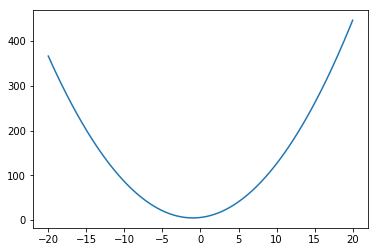

In [11]:
x = np.arange(-20, 20.1, 0.1)
y = x**2 + 2*x + 6
plt.figure()
plt.plot(x,y)
plt.show()

Построить график функции $r = sin(3\phi) + cos(5\phi)$ в полярных координатах

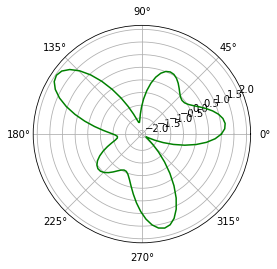

In [12]:
phi = np.linspace(0, 2 * np.pi, 100)
plt.figure()
plt.polar(phi, (np.sin(3*phi) + np.cos(5*phi)), color = 'g')
plt.show()

Построить 2 графика на одном изображении:
- на первом графике функции $y = x^2 + 3x - cos(x)$ и $y = exp(sin(x))$ для $x$ из отрезка $[0, pi/2]$. 
- на втором графике окружность радиуса 2 с центром в начале координат. 

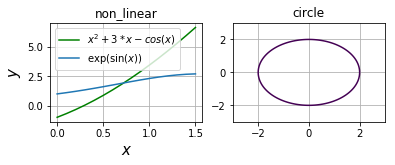

In [13]:
plt.figure(1)

x = np.arange(0, np.pi/2, 0.1)
y1 = x**2 + 3*x - np.cos(x)
y2 = np.exp(np.sin(x))

plt.subplot(221)
plt.plot(x, y1, color = 'g', label='$x^2 + 3*x - cos(x)$')
plt.plot(x, y2, label='$\exp(\sin(x))$')
plt.legend()  
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$y$', fontsize=15)
plt.title(r'Title', fontsize=15)
plt.title('non_linear')
plt.grid(True)

plt.subplot(222)
x = np.linspace(-2.0, 2.0, 100)
y = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(x,y)
F = X**2 + Y**2 - 4
plt.contour(X,Y,F,[0])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.title('circle')
plt.grid(True)

С помощью CatBoostClassifier добиться лучшего качества с помощью подбора параметров на кросс-валидации.

In [14]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',)
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = ([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns
df = df.dropna()


df_prc = df.copy()
df_prc['salary'] = df['salary'].apply((lambda x: x==' >50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе

In [15]:
X = np.array(df_prc[df._get_numeric_data().columns])
y = np.array(df_prc['salary'], dtype='int')

In [16]:
X = np.array(df_prc[df.columns[:-1]])

In [17]:
X_train,  X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.2)

In [18]:
cat_features = categorical_indices

model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    od_wait=5    #если не улучшил качество за последние 5 итераций, то остановись
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation)
);

Learning rate set to 0.094993
0:	learn: 0.6078828	test: 0.6080337	best: 0.6080337 (0)	total: 109ms	remaining: 1m 48s
1:	learn: 0.5371882	test: 0.5374866	best: 0.5374866 (1)	total: 166ms	remaining: 1m 22s
2:	learn: 0.4907076	test: 0.4911379	best: 0.4911379 (2)	total: 225ms	remaining: 1m 14s
3:	learn: 0.4543281	test: 0.4548633	best: 0.4548633 (3)	total: 275ms	remaining: 1m 8s
4:	learn: 0.4251293	test: 0.4254633	best: 0.4254633 (4)	total: 321ms	remaining: 1m 3s
5:	learn: 0.4054012	test: 0.4051595	best: 0.4051595 (5)	total: 380ms	remaining: 1m 2s
6:	learn: 0.3908920	test: 0.3905969	best: 0.3905969 (6)	total: 451ms	remaining: 1m 3s
7:	learn: 0.3770195	test: 0.3771043	best: 0.3771043 (7)	total: 518ms	remaining: 1m 4s
8:	learn: 0.3681678	test: 0.3683284	best: 0.3683284 (8)	total: 564ms	remaining: 1m 2s
9:	learn: 0.3594511	test: 0.3600687	best: 0.3600687 (9)	total: 618ms	remaining: 1m 1s
10:	learn: 0.3558089	test: 0.3567171	best: 0.3567171 (10)	total: 652ms	remaining: 58.6s
11:	learn: 0.349299

94:	learn: 0.2935589	test: 0.3043906	best: 0.3043906 (94)	total: 5.13s	remaining: 48.9s
95:	learn: 0.2932998	test: 0.3042623	best: 0.3042623 (95)	total: 5.19s	remaining: 48.9s
96:	learn: 0.2931711	test: 0.3042140	best: 0.3042140 (96)	total: 5.25s	remaining: 48.8s
97:	learn: 0.2929033	test: 0.3041262	best: 0.3041262 (97)	total: 5.42s	remaining: 49.9s
98:	learn: 0.2927271	test: 0.3041289	best: 0.3041262 (97)	total: 5.53s	remaining: 50.4s
99:	learn: 0.2925720	test: 0.3040761	best: 0.3040761 (99)	total: 5.65s	remaining: 50.8s
100:	learn: 0.2921237	test: 0.3038537	best: 0.3038537 (100)	total: 5.77s	remaining: 51.3s
101:	learn: 0.2921131	test: 0.3038908	best: 0.3038537 (100)	total: 5.84s	remaining: 51.4s
102:	learn: 0.2917631	test: 0.3037845	best: 0.3037845 (102)	total: 5.91s	remaining: 51.5s
103:	learn: 0.2916171	test: 0.3036310	best: 0.3036310 (103)	total: 6.08s	remaining: 52.4s
104:	learn: 0.2912883	test: 0.3035428	best: 0.3035428 (104)	total: 6.26s	remaining: 53.4s
105:	learn: 0.2911934	

187:	learn: 0.2725144	test: 0.2966320	best: 0.2966295 (186)	total: 15.5s	remaining: 1m 6s
188:	learn: 0.2717792	test: 0.2966226	best: 0.2966226 (188)	total: 15.5s	remaining: 1m 6s
189:	learn: 0.2713253	test: 0.2962525	best: 0.2962525 (189)	total: 15.6s	remaining: 1m 6s
190:	learn: 0.2712528	test: 0.2962255	best: 0.2962255 (190)	total: 15.7s	remaining: 1m 6s
191:	learn: 0.2710563	test: 0.2962549	best: 0.2962255 (190)	total: 15.7s	remaining: 1m 6s
192:	learn: 0.2706431	test: 0.2961968	best: 0.2961968 (192)	total: 15.8s	remaining: 1m 6s
193:	learn: 0.2705095	test: 0.2961714	best: 0.2961714 (193)	total: 15.9s	remaining: 1m 5s
194:	learn: 0.2697095	test: 0.2961611	best: 0.2961611 (194)	total: 15.9s	remaining: 1m 5s
195:	learn: 0.2696613	test: 0.2961865	best: 0.2961611 (194)	total: 16s	remaining: 1m 5s
196:	learn: 0.2692600	test: 0.2960214	best: 0.2960214 (196)	total: 16.1s	remaining: 1m 5s
197:	learn: 0.2691644	test: 0.2960379	best: 0.2960214 (196)	total: 16.1s	remaining: 1m 5s
198:	learn: 

282:	learn: 0.2553622	test: 0.2942483	best: 0.2942350 (253)	total: 21.1s	remaining: 53.5s
283:	learn: 0.2553388	test: 0.2942651	best: 0.2942350 (253)	total: 21.2s	remaining: 53.4s
284:	learn: 0.2552799	test: 0.2942817	best: 0.2942350 (253)	total: 21.2s	remaining: 53.3s
285:	learn: 0.2552704	test: 0.2942884	best: 0.2942350 (253)	total: 21.3s	remaining: 53.2s
286:	learn: 0.2552693	test: 0.2942887	best: 0.2942350 (253)	total: 21.4s	remaining: 53.1s
287:	learn: 0.2551994	test: 0.2943254	best: 0.2942350 (253)	total: 21.4s	remaining: 52.9s
288:	learn: 0.2551748	test: 0.2943459	best: 0.2942350 (253)	total: 21.5s	remaining: 52.8s
289:	learn: 0.2551058	test: 0.2943870	best: 0.2942350 (253)	total: 21.5s	remaining: 52.7s
290:	learn: 0.2550916	test: 0.2944064	best: 0.2942350 (253)	total: 21.6s	remaining: 52.6s
291:	learn: 0.2550635	test: 0.2944121	best: 0.2942350 (253)	total: 21.7s	remaining: 52.5s
292:	learn: 0.2549926	test: 0.2944000	best: 0.2942350 (253)	total: 21.7s	remaining: 52.4s
293:	learn

374:	learn: 0.2459259	test: 0.2943270	best: 0.2938502 (337)	total: 28.8s	remaining: 47.9s
375:	learn: 0.2456177	test: 0.2943510	best: 0.2938502 (337)	total: 28.8s	remaining: 47.8s
376:	learn: 0.2455092	test: 0.2943747	best: 0.2938502 (337)	total: 28.9s	remaining: 47.7s
377:	learn: 0.2454903	test: 0.2943770	best: 0.2938502 (337)	total: 28.9s	remaining: 47.6s
378:	learn: 0.2452727	test: 0.2944351	best: 0.2938502 (337)	total: 29s	remaining: 47.5s
379:	learn: 0.2452190	test: 0.2944451	best: 0.2938502 (337)	total: 29.1s	remaining: 47.4s
380:	learn: 0.2451000	test: 0.2944369	best: 0.2938502 (337)	total: 29.1s	remaining: 47.3s
381:	learn: 0.2449616	test: 0.2943889	best: 0.2938502 (337)	total: 29.2s	remaining: 47.2s
382:	learn: 0.2449565	test: 0.2943904	best: 0.2938502 (337)	total: 29.3s	remaining: 47.1s
383:	learn: 0.2447969	test: 0.2944112	best: 0.2938502 (337)	total: 29.3s	remaining: 47s
384:	learn: 0.2447829	test: 0.2944098	best: 0.2938502 (337)	total: 29.4s	remaining: 46.9s
385:	learn: 0.

469:	learn: 0.2365295	test: 0.2952608	best: 0.2938502 (337)	total: 34.8s	remaining: 39.2s
470:	learn: 0.2365218	test: 0.2952608	best: 0.2938502 (337)	total: 34.8s	remaining: 39.1s
471:	learn: 0.2364601	test: 0.2952516	best: 0.2938502 (337)	total: 34.9s	remaining: 39s
472:	learn: 0.2363800	test: 0.2953151	best: 0.2938502 (337)	total: 34.9s	remaining: 38.9s
473:	learn: 0.2362219	test: 0.2953104	best: 0.2938502 (337)	total: 35s	remaining: 38.9s
474:	learn: 0.2362013	test: 0.2953064	best: 0.2938502 (337)	total: 35.1s	remaining: 38.8s
475:	learn: 0.2361989	test: 0.2953208	best: 0.2938502 (337)	total: 35.1s	remaining: 38.7s
476:	learn: 0.2361497	test: 0.2953238	best: 0.2938502 (337)	total: 35.2s	remaining: 38.6s
477:	learn: 0.2360699	test: 0.2953084	best: 0.2938502 (337)	total: 35.3s	remaining: 38.5s
478:	learn: 0.2360546	test: 0.2953096	best: 0.2938502 (337)	total: 35.3s	remaining: 38.4s
479:	learn: 0.2358582	test: 0.2953127	best: 0.2938502 (337)	total: 35.4s	remaining: 38.3s
480:	learn: 0.

561:	learn: 0.2297035	test: 0.2964915	best: 0.2938502 (337)	total: 40.5s	remaining: 31.6s
562:	learn: 0.2296628	test: 0.2965145	best: 0.2938502 (337)	total: 40.6s	remaining: 31.5s
563:	learn: 0.2295200	test: 0.2965148	best: 0.2938502 (337)	total: 40.7s	remaining: 31.4s
564:	learn: 0.2294959	test: 0.2965607	best: 0.2938502 (337)	total: 40.7s	remaining: 31.4s
565:	learn: 0.2294846	test: 0.2965659	best: 0.2938502 (337)	total: 40.8s	remaining: 31.3s
566:	learn: 0.2294779	test: 0.2965740	best: 0.2938502 (337)	total: 40.9s	remaining: 31.2s
567:	learn: 0.2294746	test: 0.2965769	best: 0.2938502 (337)	total: 40.9s	remaining: 31.1s
568:	learn: 0.2293954	test: 0.2965767	best: 0.2938502 (337)	total: 41s	remaining: 31s
569:	learn: 0.2293774	test: 0.2965677	best: 0.2938502 (337)	total: 41s	remaining: 31s
570:	learn: 0.2291770	test: 0.2962710	best: 0.2938502 (337)	total: 41.1s	remaining: 30.9s
571:	learn: 0.2291465	test: 0.2962965	best: 0.2938502 (337)	total: 41.2s	remaining: 30.8s
572:	learn: 0.2290

653:	learn: 0.2255915	test: 0.2966897	best: 0.2938502 (337)	total: 46.6s	remaining: 24.7s
654:	learn: 0.2255889	test: 0.2966888	best: 0.2938502 (337)	total: 46.7s	remaining: 24.6s
655:	learn: 0.2253894	test: 0.2966714	best: 0.2938502 (337)	total: 46.7s	remaining: 24.5s
656:	learn: 0.2253254	test: 0.2966886	best: 0.2938502 (337)	total: 46.8s	remaining: 24.4s
657:	learn: 0.2252979	test: 0.2966835	best: 0.2938502 (337)	total: 46.9s	remaining: 24.4s
658:	learn: 0.2250896	test: 0.2967296	best: 0.2938502 (337)	total: 46.9s	remaining: 24.3s
659:	learn: 0.2250583	test: 0.2967331	best: 0.2938502 (337)	total: 47s	remaining: 24.2s
660:	learn: 0.2249246	test: 0.2967846	best: 0.2938502 (337)	total: 47s	remaining: 24.1s
661:	learn: 0.2248994	test: 0.2967685	best: 0.2938502 (337)	total: 47.1s	remaining: 24.1s
662:	learn: 0.2248761	test: 0.2967897	best: 0.2938502 (337)	total: 47.2s	remaining: 24s
663:	learn: 0.2248486	test: 0.2967946	best: 0.2938502 (337)	total: 47.2s	remaining: 23.9s
664:	learn: 0.22

746:	learn: 0.2208717	test: 0.2977947	best: 0.2938502 (337)	total: 53.8s	remaining: 18.2s
747:	learn: 0.2207993	test: 0.2977932	best: 0.2938502 (337)	total: 53.9s	remaining: 18.2s
748:	learn: 0.2207989	test: 0.2977999	best: 0.2938502 (337)	total: 54s	remaining: 18.1s
749:	learn: 0.2207730	test: 0.2978018	best: 0.2938502 (337)	total: 54.1s	remaining: 18s
750:	learn: 0.2207478	test: 0.2978127	best: 0.2938502 (337)	total: 54.2s	remaining: 18s
751:	learn: 0.2207267	test: 0.2978292	best: 0.2938502 (337)	total: 54.3s	remaining: 17.9s
752:	learn: 0.2206624	test: 0.2978003	best: 0.2938502 (337)	total: 54.4s	remaining: 17.8s
753:	learn: 0.2205886	test: 0.2978050	best: 0.2938502 (337)	total: 54.5s	remaining: 17.8s
754:	learn: 0.2205725	test: 0.2978001	best: 0.2938502 (337)	total: 54.5s	remaining: 17.7s
755:	learn: 0.2205552	test: 0.2978070	best: 0.2938502 (337)	total: 54.6s	remaining: 17.6s
756:	learn: 0.2205520	test: 0.2978137	best: 0.2938502 (337)	total: 54.7s	remaining: 17.6s
757:	learn: 0.22

840:	learn: 0.2147765	test: 0.2989721	best: 0.2938502 (337)	total: 1m	remaining: 11.5s
841:	learn: 0.2147678	test: 0.2989829	best: 0.2938502 (337)	total: 1m	remaining: 11.4s
842:	learn: 0.2147362	test: 0.2989660	best: 0.2938502 (337)	total: 1m	remaining: 11.3s
843:	learn: 0.2147235	test: 0.2989657	best: 0.2938502 (337)	total: 1m	remaining: 11.3s
844:	learn: 0.2147105	test: 0.2989719	best: 0.2938502 (337)	total: 1m	remaining: 11.2s
845:	learn: 0.2146930	test: 0.2989792	best: 0.2938502 (337)	total: 1m 1s	remaining: 11.1s
846:	learn: 0.2145657	test: 0.2989947	best: 0.2938502 (337)	total: 1m 1s	remaining: 11s
847:	learn: 0.2145224	test: 0.2990167	best: 0.2938502 (337)	total: 1m 1s	remaining: 11s
848:	learn: 0.2145177	test: 0.2990212	best: 0.2938502 (337)	total: 1m 1s	remaining: 10.9s
849:	learn: 0.2143592	test: 0.2990611	best: 0.2938502 (337)	total: 1m 1s	remaining: 10.8s
850:	learn: 0.2143542	test: 0.2990615	best: 0.2938502 (337)	total: 1m 1s	remaining: 10.8s
851:	learn: 0.2143146	test: 0

933:	learn: 0.2096981	test: 0.2997843	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.95s
934:	learn: 0.2096649	test: 0.2997887	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.88s
935:	learn: 0.2095330	test: 0.2998026	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.8s
936:	learn: 0.2094870	test: 0.2997971	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.73s
937:	learn: 0.2094710	test: 0.2997980	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.65s
938:	learn: 0.2094561	test: 0.2997889	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.58s
939:	learn: 0.2093295	test: 0.2997876	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.5s
940:	learn: 0.2093283	test: 0.2997874	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.43s
941:	learn: 0.2093180	test: 0.2997894	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.36s
942:	learn: 0.2092982	test: 0.2998121	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.28s
943:	learn: 0.2092552	test: 0.2998565	best: 0.2938502 (337)	total: 1m 10s	remaining: 4.21s
9

In [19]:
params = {"iterations": range(91,500, 100),
          "depth": range(1,5),
          "od_wait": range(1,2)}

model_grid = GridSearchCV(model, params, cv=5, scoring='accuracy')

model_grid.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.226183
0:	learn: 0.6196383	total: 3.48ms	remaining: 313ms
1:	learn: 0.5594169	total: 5.98ms	remaining: 266ms
2:	learn: 0.5198593	total: 8ms	remaining: 235ms
3:	learn: 0.4941751	total: 11.8ms	remaining: 257ms
4:	learn: 0.4719399	total: 13.6ms	remaining: 234ms
5:	learn: 0.4572539	total: 15.4ms	remaining: 218ms
6:	learn: 0.4430496	total: 17.1ms	remaining: 206ms
7:	learn: 0.4306372	total: 18.9ms	remaining: 196ms
8:	learn: 0.4233425	total: 21.9ms	remaining: 199ms
9:	learn: 0.4154027	total: 23.6ms	remaining: 191ms
10:	learn: 0.4098349	total: 25.4ms	remaining: 185ms
11:	learn: 0.4050765	total: 27.1ms	remaining: 179ms
12:	learn: 0.4004231	total: 28.7ms	remaining: 172ms
13:	learn: 0.3955874	total: 30.5ms	remaining: 168ms
14:	learn: 0.3909559	total: 32.4ms	remaining: 164ms
15:	learn: 0.3872009	total: 34ms	remaining: 159ms
16:	learn: 0.3843806	total: 35.8ms	remaining: 156ms
17:	learn: 0.3798734	total: 37.5ms	remaining: 152ms
18:	learn: 0.3759334	total: 39.4ms	remaining: 149

Learning rate set to 0.226183
0:	learn: 0.6190789	total: 3.18ms	remaining: 287ms
1:	learn: 0.5563885	total: 5.25ms	remaining: 234ms
2:	learn: 0.5151138	total: 7.37ms	remaining: 216ms
3:	learn: 0.4877521	total: 9.63ms	remaining: 210ms
4:	learn: 0.4643621	total: 12.2ms	remaining: 210ms
5:	learn: 0.4496804	total: 14.7ms	remaining: 208ms
6:	learn: 0.4351959	total: 16.8ms	remaining: 202ms
7:	learn: 0.4239725	total: 19.2ms	remaining: 199ms
8:	learn: 0.4142005	total: 21ms	remaining: 191ms
9:	learn: 0.4071348	total: 22.9ms	remaining: 186ms
10:	learn: 0.3983011	total: 24.7ms	remaining: 179ms
11:	learn: 0.3920690	total: 26.3ms	remaining: 173ms
12:	learn: 0.3883446	total: 27.8ms	remaining: 167ms
13:	learn: 0.3842919	total: 29.4ms	remaining: 162ms
14:	learn: 0.3799218	total: 31ms	remaining: 157ms
15:	learn: 0.3753635	total: 33.4ms	remaining: 157ms
16:	learn: 0.3704515	total: 35.1ms	remaining: 153ms
17:	learn: 0.3662025	total: 37ms	remaining: 150ms
18:	learn: 0.3623652	total: 38.5ms	remaining: 146m

83:	learn: 0.3123770	total: 183ms	remaining: 15.3ms
84:	learn: 0.3121711	total: 188ms	remaining: 13.3ms
85:	learn: 0.3120738	total: 195ms	remaining: 11.3ms
86:	learn: 0.3119169	total: 211ms	remaining: 9.72ms
87:	learn: 0.3118087	total: 214ms	remaining: 7.28ms
88:	learn: 0.3115396	total: 218ms	remaining: 4.89ms
89:	learn: 0.3113912	total: 220ms	remaining: 2.44ms
90:	learn: 0.3113605	total: 221ms	remaining: 0us
Learning rate set to 0.226195
0:	learn: 0.6082564	total: 3.91ms	remaining: 352ms
1:	learn: 0.5550473	total: 5.96ms	remaining: 265ms
2:	learn: 0.5179489	total: 8.87ms	remaining: 260ms
3:	learn: 0.4887848	total: 14.6ms	remaining: 318ms
4:	learn: 0.4666906	total: 18.7ms	remaining: 322ms
5:	learn: 0.4511339	total: 21.7ms	remaining: 307ms
6:	learn: 0.4365504	total: 24.6ms	remaining: 295ms
7:	learn: 0.4248375	total: 26.8ms	remaining: 278ms
8:	learn: 0.4168855	total: 28.5ms	remaining: 259ms
9:	learn: 0.4092464	total: 30.1ms	remaining: 244ms
10:	learn: 0.4007217	total: 32.3ms	remaining: 2

37:	learn: 0.3343098	total: 92.6ms	remaining: 129ms
38:	learn: 0.3332353	total: 96.4ms	remaining: 128ms
39:	learn: 0.3319111	total: 103ms	remaining: 131ms
40:	learn: 0.3313962	total: 106ms	remaining: 129ms
41:	learn: 0.3309094	total: 111ms	remaining: 130ms
42:	learn: 0.3300963	total: 113ms	remaining: 127ms
43:	learn: 0.3294880	total: 115ms	remaining: 123ms
44:	learn: 0.3285276	total: 117ms	remaining: 120ms
45:	learn: 0.3275560	total: 121ms	remaining: 118ms
46:	learn: 0.3268489	total: 122ms	remaining: 114ms
47:	learn: 0.3262276	total: 124ms	remaining: 111ms
48:	learn: 0.3257304	total: 126ms	remaining: 108ms
49:	learn: 0.3257135	total: 128ms	remaining: 105ms
50:	learn: 0.3252844	total: 129ms	remaining: 101ms
51:	learn: 0.3241811	total: 131ms	remaining: 98.6ms
52:	learn: 0.3237503	total: 133ms	remaining: 95.5ms
53:	learn: 0.3236013	total: 135ms	remaining: 92.3ms
54:	learn: 0.3233249	total: 136ms	remaining: 89.3ms
55:	learn: 0.3231100	total: 138ms	remaining: 86.4ms
56:	learn: 0.3228116	tot

2:	learn: 0.5178284	total: 8.57ms	remaining: 251ms
3:	learn: 0.4898612	total: 13.2ms	remaining: 286ms
4:	learn: 0.4674377	total: 17.3ms	remaining: 297ms
5:	learn: 0.4517585	total: 19.4ms	remaining: 275ms
6:	learn: 0.4392253	total: 22.1ms	remaining: 265ms
7:	learn: 0.4268284	total: 24.1ms	remaining: 250ms
8:	learn: 0.4192563	total: 25.8ms	remaining: 235ms
9:	learn: 0.4119823	total: 27.7ms	remaining: 224ms
10:	learn: 0.4037210	total: 29.5ms	remaining: 215ms
11:	learn: 0.3996705	total: 32.3ms	remaining: 213ms
12:	learn: 0.3928429	total: 34.2ms	remaining: 205ms
13:	learn: 0.3891517	total: 36.2ms	remaining: 199ms
14:	learn: 0.3841782	total: 37.9ms	remaining: 192ms
15:	learn: 0.3797984	total: 39.5ms	remaining: 185ms
16:	learn: 0.3745808	total: 42.4ms	remaining: 184ms
17:	learn: 0.3705536	total: 44ms	remaining: 179ms
18:	learn: 0.3665937	total: 45.6ms	remaining: 173ms
19:	learn: 0.3638574	total: 47.4ms	remaining: 168ms
20:	learn: 0.3612143	total: 49.4ms	remaining: 165ms
21:	learn: 0.3596217	t

Learning rate set to 0.116833
0:	learn: 0.6528636	total: 3.38ms	remaining: 643ms
1:	learn: 0.6144498	total: 6.39ms	remaining: 604ms
2:	learn: 0.5837172	total: 8.27ms	remaining: 518ms
3:	learn: 0.5593429	total: 10.7ms	remaining: 499ms
4:	learn: 0.5389261	total: 13ms	remaining: 482ms
5:	learn: 0.5226177	total: 14.7ms	remaining: 453ms
6:	learn: 0.5075817	total: 16.4ms	remaining: 431ms
7:	learn: 0.4943667	total: 18.1ms	remaining: 415ms
8:	learn: 0.4836657	total: 19.7ms	remaining: 399ms
9:	learn: 0.4734306	total: 21.9ms	remaining: 396ms
10:	learn: 0.4650329	total: 23.7ms	remaining: 388ms
11:	learn: 0.4567845	total: 25.5ms	remaining: 381ms
12:	learn: 0.4506925	total: 27.7ms	remaining: 380ms
13:	learn: 0.4448863	total: 29.5ms	remaining: 372ms
14:	learn: 0.4380590	total: 34.5ms	remaining: 405ms
15:	learn: 0.4322997	total: 36.4ms	remaining: 398ms
16:	learn: 0.4282108	total: 38ms	remaining: 389ms
17:	learn: 0.4243666	total: 39.7ms	remaining: 381ms
18:	learn: 0.4199329	total: 41.3ms	remaining: 37

83:	learn: 0.3392355	total: 192ms	remaining: 244ms
84:	learn: 0.3389083	total: 199ms	remaining: 248ms
85:	learn: 0.3387593	total: 207ms	remaining: 253ms
86:	learn: 0.3384195	total: 209ms	remaining: 250ms
87:	learn: 0.3382108	total: 213ms	remaining: 249ms
88:	learn: 0.3380281	total: 216ms	remaining: 247ms
89:	learn: 0.3378060	total: 222ms	remaining: 249ms
90:	learn: 0.3375876	total: 224ms	remaining: 246ms
91:	learn: 0.3374485	total: 228ms	remaining: 245ms
92:	learn: 0.3372025	total: 230ms	remaining: 242ms
93:	learn: 0.3370066	total: 232ms	remaining: 239ms
94:	learn: 0.3369046	total: 235ms	remaining: 237ms
95:	learn: 0.3366927	total: 238ms	remaining: 235ms
96:	learn: 0.3365259	total: 240ms	remaining: 233ms
97:	learn: 0.3360408	total: 242ms	remaining: 230ms
98:	learn: 0.3354964	total: 244ms	remaining: 227ms
99:	learn: 0.3353898	total: 246ms	remaining: 224ms
100:	learn: 0.3351831	total: 249ms	remaining: 222ms
101:	learn: 0.3347458	total: 250ms	remaining: 219ms
102:	learn: 0.3346463	total: 

34:	learn: 0.3670914	total: 79.1ms	remaining: 353ms
35:	learn: 0.3656973	total: 84.2ms	remaining: 363ms
36:	learn: 0.3646204	total: 88.1ms	remaining: 367ms
37:	learn: 0.3628149	total: 92.2ms	remaining: 371ms
38:	learn: 0.3613845	total: 93.9ms	remaining: 366ms
39:	learn: 0.3599335	total: 95.6ms	remaining: 361ms
40:	learn: 0.3586185	total: 98.4ms	remaining: 360ms
41:	learn: 0.3573574	total: 102ms	remaining: 363ms
42:	learn: 0.3558345	total: 104ms	remaining: 358ms
43:	learn: 0.3552151	total: 107ms	remaining: 357ms
44:	learn: 0.3532967	total: 109ms	remaining: 353ms
45:	learn: 0.3518735	total: 111ms	remaining: 349ms
46:	learn: 0.3507315	total: 114ms	remaining: 349ms
47:	learn: 0.3500711	total: 116ms	remaining: 345ms
48:	learn: 0.3493741	total: 118ms	remaining: 341ms
49:	learn: 0.3482459	total: 120ms	remaining: 338ms
50:	learn: 0.3470230	total: 123ms	remaining: 339ms
51:	learn: 0.3460482	total: 125ms	remaining: 335ms
52:	learn: 0.3452804	total: 128ms	remaining: 334ms
53:	learn: 0.3445023	tot

85:	learn: 0.3288465	total: 182ms	remaining: 222ms
86:	learn: 0.3285740	total: 188ms	remaining: 224ms
87:	learn: 0.3280341	total: 193ms	remaining: 226ms
88:	learn: 0.3279886	total: 197ms	remaining: 226ms
89:	learn: 0.3277718	total: 200ms	remaining: 225ms
90:	learn: 0.3275984	total: 203ms	remaining: 224ms
91:	learn: 0.3273974	total: 206ms	remaining: 222ms
92:	learn: 0.3268311	total: 208ms	remaining: 219ms
93:	learn: 0.3263226	total: 210ms	remaining: 217ms
94:	learn: 0.3256903	total: 212ms	remaining: 214ms
95:	learn: 0.3255304	total: 214ms	remaining: 212ms
96:	learn: 0.3253141	total: 216ms	remaining: 209ms
97:	learn: 0.3251977	total: 218ms	remaining: 207ms
98:	learn: 0.3251027	total: 220ms	remaining: 204ms
99:	learn: 0.3246712	total: 221ms	remaining: 201ms
100:	learn: 0.3244996	total: 224ms	remaining: 199ms
101:	learn: 0.3241321	total: 226ms	remaining: 197ms
102:	learn: 0.3240349	total: 227ms	remaining: 194ms
103:	learn: 0.3236011	total: 229ms	remaining: 192ms
104:	learn: 0.3234978	total

41:	learn: 0.3617237	total: 90.4ms	remaining: 321ms
42:	learn: 0.3605968	total: 94.7ms	remaining: 326ms
43:	learn: 0.3593058	total: 97.1ms	remaining: 324ms
44:	learn: 0.3580349	total: 99.1ms	remaining: 322ms
45:	learn: 0.3571769	total: 101ms	remaining: 318ms
46:	learn: 0.3558688	total: 103ms	remaining: 315ms
47:	learn: 0.3546188	total: 105ms	remaining: 313ms
48:	learn: 0.3536953	total: 107ms	remaining: 310ms
49:	learn: 0.3526666	total: 110ms	remaining: 310ms
50:	learn: 0.3516969	total: 112ms	remaining: 307ms
51:	learn: 0.3508677	total: 114ms	remaining: 304ms
52:	learn: 0.3501639	total: 115ms	remaining: 301ms
53:	learn: 0.3491529	total: 117ms	remaining: 297ms
54:	learn: 0.3485850	total: 120ms	remaining: 297ms
55:	learn: 0.3475585	total: 122ms	remaining: 294ms
56:	learn: 0.3468351	total: 124ms	remaining: 291ms
57:	learn: 0.3459927	total: 125ms	remaining: 288ms
58:	learn: 0.3451372	total: 127ms	remaining: 284ms
59:	learn: 0.3444965	total: 130ms	remaining: 284ms
60:	learn: 0.3440597	total:

79:	learn: 0.3321891	total: 198ms	remaining: 275ms
80:	learn: 0.3318693	total: 210ms	remaining: 285ms
81:	learn: 0.3317367	total: 222ms	remaining: 296ms
82:	learn: 0.3310969	total: 235ms	remaining: 305ms
83:	learn: 0.3304126	total: 251ms	remaining: 320ms
84:	learn: 0.3300206	total: 269ms	remaining: 335ms
85:	learn: 0.3299155	total: 286ms	remaining: 349ms
86:	learn: 0.3294963	total: 307ms	remaining: 367ms
87:	learn: 0.3291757	total: 323ms	remaining: 379ms
88:	learn: 0.3286174	total: 340ms	remaining: 389ms
89:	learn: 0.3280879	total: 354ms	remaining: 397ms
90:	learn: 0.3278424	total: 377ms	remaining: 415ms
91:	learn: 0.3273880	total: 390ms	remaining: 420ms
92:	learn: 0.3270648	total: 400ms	remaining: 421ms
93:	learn: 0.3269891	total: 411ms	remaining: 424ms
94:	learn: 0.3263985	total: 423ms	remaining: 427ms
95:	learn: 0.3262411	total: 438ms	remaining: 433ms
96:	learn: 0.3260926	total: 449ms	remaining: 435ms
97:	learn: 0.3260030	total: 462ms	remaining: 438ms
98:	learn: 0.3256154	total: 483

13:	learn: 0.4419569	total: 109ms	remaining: 2.15s
14:	learn: 0.4374012	total: 124ms	remaining: 2.27s
15:	learn: 0.4335446	total: 130ms	remaining: 2.23s
16:	learn: 0.4289594	total: 140ms	remaining: 2.26s
17:	learn: 0.4262519	total: 147ms	remaining: 2.23s
18:	learn: 0.4230355	total: 154ms	remaining: 2.21s
19:	learn: 0.4201870	total: 161ms	remaining: 2.19s
20:	learn: 0.4158111	total: 169ms	remaining: 2.17s
21:	learn: 0.4122148	total: 175ms	remaining: 2.14s
22:	learn: 0.4104592	total: 183ms	remaining: 2.13s
23:	learn: 0.4089425	total: 191ms	remaining: 2.12s
24:	learn: 0.4061382	total: 202ms	remaining: 2.15s
25:	learn: 0.4031680	total: 209ms	remaining: 2.13s
26:	learn: 0.4005805	total: 217ms	remaining: 2.12s
27:	learn: 0.3984661	total: 224ms	remaining: 2.1s
28:	learn: 0.3965882	total: 230ms	remaining: 2.08s
29:	learn: 0.3944036	total: 238ms	remaining: 2.07s
30:	learn: 0.3923582	total: 246ms	remaining: 2.07s
31:	learn: 0.3904401	total: 253ms	remaining: 2.05s
32:	learn: 0.3889478	total: 262m

189:	learn: 0.3268494	total: 2.02s	remaining: 1.08s
190:	learn: 0.3267799	total: 2.03s	remaining: 1.06s
191:	learn: 0.3267259	total: 2.04s	remaining: 1.05s
192:	learn: 0.3265370	total: 2.05s	remaining: 1.04s
193:	learn: 0.3264286	total: 2.06s	remaining: 1.03s
194:	learn: 0.3263641	total: 2.07s	remaining: 1.02s
195:	learn: 0.3262326	total: 2.08s	remaining: 1s
196:	learn: 0.3261439	total: 2.08s	remaining: 994ms
197:	learn: 0.3261024	total: 2.09s	remaining: 983ms
198:	learn: 0.3260546	total: 2.1s	remaining: 971ms
199:	learn: 0.3259624	total: 2.1s	remaining: 958ms
200:	learn: 0.3259495	total: 2.12s	remaining: 948ms
201:	learn: 0.3256528	total: 2.13s	remaining: 937ms
202:	learn: 0.3256120	total: 2.13s	remaining: 925ms
203:	learn: 0.3255040	total: 2.14s	remaining: 912ms
204:	learn: 0.3254028	total: 2.15s	remaining: 900ms
205:	learn: 0.3253042	total: 2.15s	remaining: 890ms
206:	learn: 0.3252374	total: 2.16s	remaining: 878ms
207:	learn: 0.3250582	total: 2.17s	remaining: 867ms
208:	learn: 0.325

23:	learn: 0.4003398	total: 193ms	remaining: 2.14s
24:	learn: 0.3963315	total: 215ms	remaining: 2.29s
25:	learn: 0.3946768	total: 227ms	remaining: 2.32s
26:	learn: 0.3916133	total: 236ms	remaining: 2.31s
27:	learn: 0.3886659	total: 250ms	remaining: 2.35s
28:	learn: 0.3873441	total: 262ms	remaining: 2.37s
29:	learn: 0.3847714	total: 274ms	remaining: 2.38s
30:	learn: 0.3825787	total: 283ms	remaining: 2.37s
31:	learn: 0.3808380	total: 292ms	remaining: 2.36s
32:	learn: 0.3783174	total: 299ms	remaining: 2.34s
33:	learn: 0.3771598	total: 310ms	remaining: 2.34s
34:	learn: 0.3755203	total: 320ms	remaining: 2.34s
35:	learn: 0.3738358	total: 328ms	remaining: 2.32s
36:	learn: 0.3724989	total: 337ms	remaining: 2.31s
37:	learn: 0.3710800	total: 346ms	remaining: 2.3s
38:	learn: 0.3694667	total: 355ms	remaining: 2.3s
39:	learn: 0.3684036	total: 365ms	remaining: 2.29s
40:	learn: 0.3670965	total: 375ms	remaining: 2.29s
41:	learn: 0.3656152	total: 385ms	remaining: 2.28s
42:	learn: 0.3645880	total: 396ms

195:	learn: 0.3125646	total: 1.81s	remaining: 878ms
196:	learn: 0.3125009	total: 1.82s	remaining: 871ms
197:	learn: 0.3124740	total: 1.83s	remaining: 861ms
198:	learn: 0.3124525	total: 1.84s	remaining: 852ms
199:	learn: 0.3124277	total: 1.85s	remaining: 843ms
200:	learn: 0.3123873	total: 1.86s	remaining: 833ms
201:	learn: 0.3123346	total: 1.87s	remaining: 823ms
202:	learn: 0.3123025	total: 1.88s	remaining: 813ms
203:	learn: 0.3122837	total: 1.89s	remaining: 804ms
204:	learn: 0.3122500	total: 1.89s	remaining: 794ms
205:	learn: 0.3121710	total: 1.9s	remaining: 784ms
206:	learn: 0.3121311	total: 1.91s	remaining: 776ms
207:	learn: 0.3120359	total: 1.92s	remaining: 767ms
208:	learn: 0.3119669	total: 1.93s	remaining: 757ms
209:	learn: 0.3119371	total: 1.94s	remaining: 747ms
210:	learn: 0.3118533	total: 1.94s	remaining: 737ms
211:	learn: 0.3117919	total: 1.95s	remaining: 727ms
212:	learn: 0.3116483	total: 1.96s	remaining: 717ms
213:	learn: 0.3113771	total: 1.97s	remaining: 708ms
214:	learn: 0

7:	learn: 0.4889578	total: 99.6ms	remaining: 3.52s
8:	learn: 0.4789510	total: 112ms	remaining: 3.49s
9:	learn: 0.4664004	total: 127ms	remaining: 3.57s
10:	learn: 0.4560183	total: 134ms	remaining: 3.42s
11:	learn: 0.4481484	total: 145ms	remaining: 3.38s
12:	learn: 0.4402272	total: 154ms	remaining: 3.29s
13:	learn: 0.4345273	total: 161ms	remaining: 3.18s
14:	learn: 0.4286259	total: 176ms	remaining: 3.23s
15:	learn: 0.4248543	total: 182ms	remaining: 3.13s
16:	learn: 0.4224180	total: 189ms	remaining: 3.04s
17:	learn: 0.4188237	total: 203ms	remaining: 3.08s
18:	learn: 0.4130879	total: 218ms	remaining: 3.12s
19:	learn: 0.4092009	total: 229ms	remaining: 3.1s
20:	learn: 0.4066846	total: 236ms	remaining: 3.03s
21:	learn: 0.4036090	total: 244ms	remaining: 2.98s
22:	learn: 0.4010226	total: 251ms	remaining: 2.92s
23:	learn: 0.3984418	total: 259ms	remaining: 2.88s
24:	learn: 0.3953383	total: 274ms	remaining: 2.91s
25:	learn: 0.3935861	total: 282ms	remaining: 2.87s
26:	learn: 0.3907276	total: 290ms	

171:	learn: 0.3169464	total: 1.53s	remaining: 1.06s
172:	learn: 0.3168320	total: 1.53s	remaining: 1.05s
173:	learn: 0.3168017	total: 1.54s	remaining: 1.04s
174:	learn: 0.3167049	total: 1.55s	remaining: 1.03s
175:	learn: 0.3166225	total: 1.56s	remaining: 1.02s
176:	learn: 0.3165330	total: 1.57s	remaining: 1.01s
177:	learn: 0.3164571	total: 1.57s	remaining: 999ms
178:	learn: 0.3163595	total: 1.58s	remaining: 990ms
179:	learn: 0.3162986	total: 1.59s	remaining: 980ms
180:	learn: 0.3161076	total: 1.6s	remaining: 970ms
181:	learn: 0.3159488	total: 1.61s	remaining: 966ms
182:	learn: 0.3156527	total: 1.62s	remaining: 957ms
183:	learn: 0.3155711	total: 1.63s	remaining: 947ms
184:	learn: 0.3155022	total: 1.64s	remaining: 937ms
185:	learn: 0.3154636	total: 1.64s	remaining: 928ms
186:	learn: 0.3154144	total: 1.65s	remaining: 919ms
187:	learn: 0.3152829	total: 1.66s	remaining: 910ms
188:	learn: 0.3152132	total: 1.67s	remaining: 901ms
189:	learn: 0.3151673	total: 1.68s	remaining: 892ms
190:	learn: 0

20:	learn: 0.4107589	total: 195ms	remaining: 2.5s
21:	learn: 0.4068153	total: 217ms	remaining: 2.65s
22:	learn: 0.4036567	total: 225ms	remaining: 2.62s
23:	learn: 0.4005900	total: 235ms	remaining: 2.61s
24:	learn: 0.3980054	total: 241ms	remaining: 2.56s
25:	learn: 0.3956413	total: 249ms	remaining: 2.54s
26:	learn: 0.3936484	total: 257ms	remaining: 2.51s
27:	learn: 0.3923255	total: 265ms	remaining: 2.49s
28:	learn: 0.3906692	total: 273ms	remaining: 2.46s
29:	learn: 0.3886919	total: 283ms	remaining: 2.46s
30:	learn: 0.3870217	total: 292ms	remaining: 2.45s
31:	learn: 0.3848194	total: 299ms	remaining: 2.42s
32:	learn: 0.3829221	total: 306ms	remaining: 2.4s
33:	learn: 0.3815901	total: 314ms	remaining: 2.38s
34:	learn: 0.3798366	total: 321ms	remaining: 2.35s
35:	learn: 0.3787129	total: 329ms	remaining: 2.33s
36:	learn: 0.3776599	total: 336ms	remaining: 2.31s
37:	learn: 0.3755180	total: 343ms	remaining: 2.28s
38:	learn: 0.3734664	total: 352ms	remaining: 2.27s
39:	learn: 0.3723068	total: 361ms

189:	learn: 0.3186769	total: 1.62s	remaining: 862ms
190:	learn: 0.3186327	total: 1.63s	remaining: 853ms
191:	learn: 0.3185274	total: 1.64s	remaining: 845ms
192:	learn: 0.3183730	total: 1.65s	remaining: 836ms
193:	learn: 0.3182989	total: 1.66s	remaining: 828ms
194:	learn: 0.3182590	total: 1.66s	remaining: 818ms
195:	learn: 0.3181652	total: 1.67s	remaining: 809ms
196:	learn: 0.3180177	total: 1.68s	remaining: 800ms
197:	learn: 0.3178567	total: 1.68s	remaining: 791ms
198:	learn: 0.3178527	total: 1.69s	remaining: 783ms
199:	learn: 0.3178202	total: 1.7s	remaining: 775ms
200:	learn: 0.3177894	total: 1.71s	remaining: 766ms
201:	learn: 0.3177215	total: 1.72s	remaining: 756ms
202:	learn: 0.3177169	total: 1.73s	remaining: 748ms
203:	learn: 0.3176669	total: 1.73s	remaining: 739ms
204:	learn: 0.3175858	total: 1.74s	remaining: 730ms
205:	learn: 0.3174667	total: 1.75s	remaining: 721ms
206:	learn: 0.3174354	total: 1.75s	remaining: 713ms
207:	learn: 0.3173707	total: 1.76s	remaining: 703ms
208:	learn: 0

12:	learn: 0.4390252	total: 112ms	remaining: 2.4s
13:	learn: 0.4336154	total: 126ms	remaining: 2.5s
14:	learn: 0.4275254	total: 137ms	remaining: 2.51s
15:	learn: 0.4225342	total: 145ms	remaining: 2.5s
16:	learn: 0.4171033	total: 153ms	remaining: 2.47s
17:	learn: 0.4141278	total: 160ms	remaining: 2.43s
18:	learn: 0.4105485	total: 167ms	remaining: 2.39s
19:	learn: 0.4069762	total: 174ms	remaining: 2.36s
20:	learn: 0.4045139	total: 182ms	remaining: 2.34s
21:	learn: 0.4014655	total: 189ms	remaining: 2.31s
22:	learn: 0.3987787	total: 199ms	remaining: 2.32s
23:	learn: 0.3950468	total: 212ms	remaining: 2.36s
24:	learn: 0.3919741	total: 220ms	remaining: 2.34s
25:	learn: 0.3898100	total: 229ms	remaining: 2.34s
26:	learn: 0.3879813	total: 236ms	remaining: 2.31s
27:	learn: 0.3864251	total: 244ms	remaining: 2.29s
28:	learn: 0.3833736	total: 252ms	remaining: 2.27s
29:	learn: 0.3820194	total: 259ms	remaining: 2.25s
30:	learn: 0.3799140	total: 267ms	remaining: 2.24s
31:	learn: 0.3776974	total: 275ms	

181:	learn: 0.3161821	total: 1.53s	remaining: 915ms
182:	learn: 0.3161356	total: 1.54s	remaining: 909ms
183:	learn: 0.3160980	total: 1.55s	remaining: 899ms
184:	learn: 0.3160278	total: 1.55s	remaining: 891ms
185:	learn: 0.3160038	total: 1.56s	remaining: 882ms
186:	learn: 0.3159555	total: 1.57s	remaining: 874ms
187:	learn: 0.3158663	total: 1.58s	remaining: 865ms
188:	learn: 0.3158314	total: 1.58s	remaining: 856ms
189:	learn: 0.3157623	total: 1.59s	remaining: 848ms
190:	learn: 0.3157037	total: 1.6s	remaining: 840ms
191:	learn: 0.3156639	total: 1.61s	remaining: 831ms
192:	learn: 0.3155959	total: 1.62s	remaining: 822ms
193:	learn: 0.3155682	total: 1.63s	remaining: 813ms
194:	learn: 0.3154176	total: 1.63s	remaining: 804ms
195:	learn: 0.3153164	total: 1.64s	remaining: 797ms
196:	learn: 0.3152829	total: 1.65s	remaining: 789ms
197:	learn: 0.3152051	total: 1.66s	remaining: 780ms
198:	learn: 0.3151999	total: 1.67s	remaining: 773ms
199:	learn: 0.3151020	total: 1.68s	remaining: 764ms
200:	learn: 0

2:	learn: 0.6055492	total: 32.8ms	remaining: 4.24s
3:	learn: 0.5862218	total: 44.7ms	remaining: 4.33s
4:	learn: 0.5638186	total: 52.2ms	remaining: 4.03s
5:	learn: 0.5448599	total: 60.2ms	remaining: 3.86s
6:	learn: 0.5288098	total: 69.3ms	remaining: 3.8s
7:	learn: 0.5183343	total: 78.1ms	remaining: 3.74s
8:	learn: 0.5085523	total: 85.6ms	remaining: 3.63s
9:	learn: 0.5000289	total: 93.5ms	remaining: 3.56s
10:	learn: 0.4916934	total: 104ms	remaining: 3.58s
11:	learn: 0.4813340	total: 113ms	remaining: 3.58s
12:	learn: 0.4746333	total: 123ms	remaining: 3.58s
13:	learn: 0.4662827	total: 130ms	remaining: 3.51s
14:	learn: 0.4591460	total: 139ms	remaining: 3.47s
15:	learn: 0.4551482	total: 147ms	remaining: 3.44s
16:	learn: 0.4513389	total: 153ms	remaining: 3.37s
17:	learn: 0.4465961	total: 162ms	remaining: 3.37s
18:	learn: 0.4423407	total: 170ms	remaining: 3.33s
19:	learn: 0.4388182	total: 178ms	remaining: 3.3s
20:	learn: 0.4356989	total: 186ms	remaining: 3.27s
21:	learn: 0.4310176	total: 194ms

172:	learn: 0.3325700	total: 1.48s	remaining: 1.87s
173:	learn: 0.3321320	total: 1.5s	remaining: 1.87s
174:	learn: 0.3319675	total: 1.51s	remaining: 1.87s
175:	learn: 0.3318786	total: 1.52s	remaining: 1.86s
176:	learn: 0.3317615	total: 1.53s	remaining: 1.85s
177:	learn: 0.3317332	total: 1.54s	remaining: 1.84s
178:	learn: 0.3316445	total: 1.55s	remaining: 1.83s
179:	learn: 0.3315479	total: 1.56s	remaining: 1.82s
180:	learn: 0.3315477	total: 1.56s	remaining: 1.81s
181:	learn: 0.3314631	total: 1.57s	remaining: 1.8s
182:	learn: 0.3313217	total: 1.58s	remaining: 1.8s
183:	learn: 0.3312236	total: 1.59s	remaining: 1.79s
184:	learn: 0.3311383	total: 1.6s	remaining: 1.78s
185:	learn: 0.3310242	total: 1.61s	remaining: 1.77s
186:	learn: 0.3309534	total: 1.61s	remaining: 1.76s
187:	learn: 0.3308851	total: 1.62s	remaining: 1.75s
188:	learn: 0.3308578	total: 1.63s	remaining: 1.74s
189:	learn: 0.3308322	total: 1.64s	remaining: 1.74s
190:	learn: 0.3307039	total: 1.65s	remaining: 1.73s
191:	learn: 0.33

337:	learn: 0.3220412	total: 2.92s	remaining: 458ms
338:	learn: 0.3219709	total: 2.93s	remaining: 450ms
339:	learn: 0.3218113	total: 2.95s	remaining: 442ms
340:	learn: 0.3217540	total: 2.96s	remaining: 433ms
341:	learn: 0.3217102	total: 2.97s	remaining: 425ms
342:	learn: 0.3216966	total: 2.98s	remaining: 417ms
343:	learn: 0.3216667	total: 2.98s	remaining: 408ms
344:	learn: 0.3216425	total: 3s	remaining: 399ms
345:	learn: 0.3215721	total: 3s	remaining: 391ms
346:	learn: 0.3215563	total: 3.01s	remaining: 382ms
347:	learn: 0.3215440	total: 3.02s	remaining: 373ms
348:	learn: 0.3215400	total: 3.03s	remaining: 364ms
349:	learn: 0.3215237	total: 3.03s	remaining: 355ms
350:	learn: 0.3214762	total: 3.04s	remaining: 347ms
351:	learn: 0.3214486	total: 3.05s	remaining: 338ms
352:	learn: 0.3214042	total: 3.06s	remaining: 329ms
353:	learn: 0.3214042	total: 3.07s	remaining: 321ms
354:	learn: 0.3213960	total: 3.08s	remaining: 312ms
355:	learn: 0.3213495	total: 3.08s	remaining: 303ms
356:	learn: 0.3213

9:	learn: 0.4914459	total: 89ms	remaining: 3.39s
10:	learn: 0.4829408	total: 100ms	remaining: 3.46s
11:	learn: 0.4772007	total: 110ms	remaining: 3.48s
12:	learn: 0.4705469	total: 119ms	remaining: 3.47s
13:	learn: 0.4615871	total: 128ms	remaining: 3.45s
14:	learn: 0.4567058	total: 135ms	remaining: 3.38s
15:	learn: 0.4497374	total: 143ms	remaining: 3.35s
16:	learn: 0.4446151	total: 153ms	remaining: 3.36s
17:	learn: 0.4397333	total: 160ms	remaining: 3.32s
18:	learn: 0.4363730	total: 166ms	remaining: 3.25s
19:	learn: 0.4320486	total: 177ms	remaining: 3.28s
20:	learn: 0.4285859	total: 185ms	remaining: 3.25s
21:	learn: 0.4259435	total: 191ms	remaining: 3.2s
22:	learn: 0.4211635	total: 208ms	remaining: 3.33s
23:	learn: 0.4170450	total: 217ms	remaining: 3.32s
24:	learn: 0.4135696	total: 225ms	remaining: 3.3s
25:	learn: 0.4105001	total: 233ms	remaining: 3.27s
26:	learn: 0.4079119	total: 241ms	remaining: 3.24s
27:	learn: 0.4060676	total: 248ms	remaining: 3.21s
28:	learn: 0.4043351	total: 257ms	r

172:	learn: 0.3208484	total: 1.51s	remaining: 1.9s
173:	learn: 0.3206842	total: 1.51s	remaining: 1.89s
174:	learn: 0.3206288	total: 1.52s	remaining: 1.88s
175:	learn: 0.3204942	total: 1.53s	remaining: 1.87s
176:	learn: 0.3202358	total: 1.54s	remaining: 1.86s
177:	learn: 0.3199928	total: 1.55s	remaining: 1.85s
178:	learn: 0.3199364	total: 1.56s	remaining: 1.84s
179:	learn: 0.3197952	total: 1.57s	remaining: 1.84s
180:	learn: 0.3195849	total: 1.58s	remaining: 1.83s
181:	learn: 0.3194429	total: 1.59s	remaining: 1.82s
182:	learn: 0.3194420	total: 1.6s	remaining: 1.81s
183:	learn: 0.3193951	total: 1.6s	remaining: 1.8s
184:	learn: 0.3192929	total: 1.61s	remaining: 1.79s
185:	learn: 0.3191554	total: 1.62s	remaining: 1.78s
186:	learn: 0.3191214	total: 1.63s	remaining: 1.78s
187:	learn: 0.3188471	total: 1.64s	remaining: 1.77s
188:	learn: 0.3187840	total: 1.65s	remaining: 1.76s
189:	learn: 0.3186719	total: 1.66s	remaining: 1.75s
190:	learn: 0.3183252	total: 1.67s	remaining: 1.74s
191:	learn: 0.31

352:	learn: 0.3090537	total: 3.11s	remaining: 335ms
353:	learn: 0.3090413	total: 3.12s	remaining: 326ms
354:	learn: 0.3090412	total: 3.13s	remaining: 317ms
355:	learn: 0.3088934	total: 3.14s	remaining: 308ms
356:	learn: 0.3088731	total: 3.15s	remaining: 300ms
357:	learn: 0.3088425	total: 3.16s	remaining: 291ms
358:	learn: 0.3087512	total: 3.17s	remaining: 282ms
359:	learn: 0.3087142	total: 3.17s	remaining: 273ms
360:	learn: 0.3086346	total: 3.18s	remaining: 264ms
361:	learn: 0.3086163	total: 3.19s	remaining: 256ms
362:	learn: 0.3085430	total: 3.2s	remaining: 247ms
363:	learn: 0.3085322	total: 3.21s	remaining: 238ms
364:	learn: 0.3085155	total: 3.22s	remaining: 229ms
365:	learn: 0.3084768	total: 3.23s	remaining: 220ms
366:	learn: 0.3084497	total: 3.24s	remaining: 212ms
367:	learn: 0.3084488	total: 3.25s	remaining: 203ms
368:	learn: 0.3084488	total: 3.25s	remaining: 194ms
369:	learn: 0.3084075	total: 3.26s	remaining: 185ms
370:	learn: 0.3083929	total: 3.27s	remaining: 176ms
371:	learn: 0

0:	learn: 0.6552574	total: 15.1ms	remaining: 5.88s
1:	learn: 0.6230729	total: 24.7ms	remaining: 4.81s
2:	learn: 0.5962402	total: 33.6ms	remaining: 4.35s
3:	learn: 0.5773336	total: 43.5ms	remaining: 4.21s
4:	learn: 0.5564313	total: 51.2ms	remaining: 3.95s
5:	learn: 0.5419387	total: 59.7ms	remaining: 3.83s
6:	learn: 0.5290358	total: 69.7ms	remaining: 3.82s
7:	learn: 0.5135327	total: 77.9ms	remaining: 3.73s
8:	learn: 0.5007227	total: 87.2ms	remaining: 3.7s
9:	learn: 0.4916251	total: 94.5ms	remaining: 3.6s
10:	learn: 0.4833703	total: 104ms	remaining: 3.59s
11:	learn: 0.4756114	total: 113ms	remaining: 3.56s
12:	learn: 0.4665339	total: 121ms	remaining: 3.52s
13:	learn: 0.4603829	total: 128ms	remaining: 3.45s
14:	learn: 0.4556563	total: 137ms	remaining: 3.44s
15:	learn: 0.4519170	total: 145ms	remaining: 3.4s
16:	learn: 0.4451758	total: 153ms	remaining: 3.36s
17:	learn: 0.4394317	total: 161ms	remaining: 3.35s
18:	learn: 0.4357190	total: 170ms	remaining: 3.33s
19:	learn: 0.4317071	total: 179ms	

165:	learn: 0.3237292	total: 1.43s	remaining: 1.94s
166:	learn: 0.3236395	total: 1.45s	remaining: 1.94s
167:	learn: 0.3235720	total: 1.45s	remaining: 1.93s
168:	learn: 0.3235044	total: 1.46s	remaining: 1.92s
169:	learn: 0.3234266	total: 1.47s	remaining: 1.91s
170:	learn: 0.3232709	total: 1.48s	remaining: 1.9s
171:	learn: 0.3231173	total: 1.49s	remaining: 1.89s
172:	learn: 0.3229285	total: 1.5s	remaining: 1.89s
173:	learn: 0.3227635	total: 1.51s	remaining: 1.88s
174:	learn: 0.3226740	total: 1.52s	remaining: 1.87s
175:	learn: 0.3224167	total: 1.53s	remaining: 1.86s
176:	learn: 0.3223385	total: 1.54s	remaining: 1.86s
177:	learn: 0.3221512	total: 1.55s	remaining: 1.85s
178:	learn: 0.3220970	total: 1.56s	remaining: 1.85s
179:	learn: 0.3219769	total: 1.57s	remaining: 1.84s
180:	learn: 0.3218303	total: 1.58s	remaining: 1.83s
181:	learn: 0.3216851	total: 1.58s	remaining: 1.82s
182:	learn: 0.3216029	total: 1.6s	remaining: 1.81s
183:	learn: 0.3214677	total: 1.61s	remaining: 1.81s
184:	learn: 0.3

344:	learn: 0.3118759	total: 3.06s	remaining: 407ms
345:	learn: 0.3118755	total: 3.07s	remaining: 399ms
346:	learn: 0.3118645	total: 3.08s	remaining: 390ms
347:	learn: 0.3118418	total: 3.08s	remaining: 381ms
348:	learn: 0.3118115	total: 3.09s	remaining: 372ms
349:	learn: 0.3118067	total: 3.1s	remaining: 363ms
350:	learn: 0.3117701	total: 3.11s	remaining: 354ms
351:	learn: 0.3116184	total: 3.12s	remaining: 345ms
352:	learn: 0.3115975	total: 3.12s	remaining: 336ms
353:	learn: 0.3115511	total: 3.13s	remaining: 327ms
354:	learn: 0.3115369	total: 3.14s	remaining: 318ms
355:	learn: 0.3114394	total: 3.15s	remaining: 310ms
356:	learn: 0.3113962	total: 3.16s	remaining: 301ms
357:	learn: 0.3113637	total: 3.17s	remaining: 292ms
358:	learn: 0.3112741	total: 3.17s	remaining: 283ms
359:	learn: 0.3111894	total: 3.18s	remaining: 274ms
360:	learn: 0.3111557	total: 3.19s	remaining: 265ms
361:	learn: 0.3111236	total: 3.2s	remaining: 257ms
362:	learn: 0.3111049	total: 3.21s	remaining: 248ms
363:	learn: 0.

22:	learn: 0.4200034	total: 206ms	remaining: 3.3s
23:	learn: 0.4177818	total: 222ms	remaining: 3.4s
24:	learn: 0.4158491	total: 230ms	remaining: 3.37s
25:	learn: 0.4131734	total: 236ms	remaining: 3.32s
26:	learn: 0.4103233	total: 252ms	remaining: 3.4s
27:	learn: 0.4080252	total: 264ms	remaining: 3.42s
28:	learn: 0.4055150	total: 271ms	remaining: 3.38s
29:	learn: 0.4032148	total: 279ms	remaining: 3.36s
30:	learn: 0.4004812	total: 289ms	remaining: 3.36s
31:	learn: 0.3990727	total: 297ms	remaining: 3.33s
32:	learn: 0.3966791	total: 304ms	remaining: 3.3s
33:	learn: 0.3939447	total: 313ms	remaining: 3.29s
34:	learn: 0.3928216	total: 322ms	remaining: 3.28s
35:	learn: 0.3910355	total: 330ms	remaining: 3.26s
36:	learn: 0.3894424	total: 338ms	remaining: 3.23s
37:	learn: 0.3874890	total: 347ms	remaining: 3.22s
38:	learn: 0.3861451	total: 356ms	remaining: 3.21s
39:	learn: 0.3845205	total: 364ms	remaining: 3.19s
40:	learn: 0.3829375	total: 372ms	remaining: 3.17s
41:	learn: 0.3817883	total: 381ms	r

182:	learn: 0.3237752	total: 1.61s	remaining: 1.84s
183:	learn: 0.3235835	total: 1.63s	remaining: 1.83s
184:	learn: 0.3234847	total: 1.63s	remaining: 1.82s
185:	learn: 0.3231441	total: 1.64s	remaining: 1.81s
186:	learn: 0.3230796	total: 1.65s	remaining: 1.8s
187:	learn: 0.3230352	total: 1.67s	remaining: 1.8s
188:	learn: 0.3230243	total: 1.67s	remaining: 1.79s
189:	learn: 0.3228492	total: 1.68s	remaining: 1.78s
190:	learn: 0.3226640	total: 1.69s	remaining: 1.77s
191:	learn: 0.3225851	total: 1.7s	remaining: 1.76s
192:	learn: 0.3225399	total: 1.71s	remaining: 1.75s
193:	learn: 0.3224554	total: 1.72s	remaining: 1.74s
194:	learn: 0.3223608	total: 1.72s	remaining: 1.73s
195:	learn: 0.3223500	total: 1.73s	remaining: 1.72s
196:	learn: 0.3222751	total: 1.74s	remaining: 1.71s
197:	learn: 0.3221664	total: 1.75s	remaining: 1.7s
198:	learn: 0.3220734	total: 1.76s	remaining: 1.7s
199:	learn: 0.3219625	total: 1.77s	remaining: 1.69s
200:	learn: 0.3219121	total: 1.77s	remaining: 1.68s
201:	learn: 0.321

341:	learn: 0.3139154	total: 3.04s	remaining: 436ms
342:	learn: 0.3138629	total: 3.05s	remaining: 427ms
343:	learn: 0.3137482	total: 3.06s	remaining: 419ms
344:	learn: 0.3136683	total: 3.08s	remaining: 410ms
345:	learn: 0.3136397	total: 3.09s	remaining: 401ms
346:	learn: 0.3136394	total: 3.09s	remaining: 392ms
347:	learn: 0.3136174	total: 3.1s	remaining: 383ms
348:	learn: 0.3136067	total: 3.11s	remaining: 374ms
349:	learn: 0.3135556	total: 3.12s	remaining: 365ms
350:	learn: 0.3134964	total: 3.13s	remaining: 357ms
351:	learn: 0.3134527	total: 3.14s	remaining: 348ms
352:	learn: 0.3134423	total: 3.15s	remaining: 339ms
353:	learn: 0.3133337	total: 3.16s	remaining: 331ms
354:	learn: 0.3132302	total: 3.17s	remaining: 322ms
355:	learn: 0.3131879	total: 3.18s	remaining: 313ms
356:	learn: 0.3131837	total: 3.19s	remaining: 304ms
357:	learn: 0.3131406	total: 3.2s	remaining: 295ms
358:	learn: 0.3131215	total: 3.2s	remaining: 286ms
359:	learn: 0.3130755	total: 3.21s	remaining: 277ms
360:	learn: 0.3

13:	learn: 0.4621656	total: 131ms	remaining: 3.53s
14:	learn: 0.4540519	total: 138ms	remaining: 3.46s
15:	learn: 0.4471131	total: 148ms	remaining: 3.47s
16:	learn: 0.4416887	total: 157ms	remaining: 3.45s
17:	learn: 0.4373370	total: 165ms	remaining: 3.42s
18:	learn: 0.4324499	total: 174ms	remaining: 3.41s
19:	learn: 0.4289581	total: 182ms	remaining: 3.37s
20:	learn: 0.4240468	total: 191ms	remaining: 3.36s
21:	learn: 0.4209187	total: 200ms	remaining: 3.35s
22:	learn: 0.4181852	total: 213ms	remaining: 3.4s
23:	learn: 0.4142901	total: 221ms	remaining: 3.37s
24:	learn: 0.4120072	total: 229ms	remaining: 3.35s
25:	learn: 0.4087170	total: 237ms	remaining: 3.33s
26:	learn: 0.4068114	total: 245ms	remaining: 3.31s
27:	learn: 0.4053158	total: 252ms	remaining: 3.27s
28:	learn: 0.4028348	total: 261ms	remaining: 3.26s
29:	learn: 0.4005096	total: 270ms	remaining: 3.25s
30:	learn: 0.3984209	total: 277ms	remaining: 3.21s
31:	learn: 0.3955545	total: 286ms	remaining: 3.21s
32:	learn: 0.3937957	total: 296m

174:	learn: 0.3223606	total: 1.55s	remaining: 1.91s
175:	learn: 0.3223051	total: 1.56s	remaining: 1.91s
176:	learn: 0.3222100	total: 1.57s	remaining: 1.9s
177:	learn: 0.3221380	total: 1.58s	remaining: 1.89s
178:	learn: 0.3220219	total: 1.58s	remaining: 1.88s
179:	learn: 0.3219430	total: 1.59s	remaining: 1.87s
180:	learn: 0.3218450	total: 1.6s	remaining: 1.86s
181:	learn: 0.3218276	total: 1.61s	remaining: 1.85s
182:	learn: 0.3217420	total: 1.62s	remaining: 1.84s
183:	learn: 0.3216927	total: 1.63s	remaining: 1.83s
184:	learn: 0.3216270	total: 1.64s	remaining: 1.82s
185:	learn: 0.3215703	total: 1.65s	remaining: 1.81s
186:	learn: 0.3214374	total: 1.65s	remaining: 1.8s
187:	learn: 0.3213806	total: 1.66s	remaining: 1.79s
188:	learn: 0.3213204	total: 1.67s	remaining: 1.79s
189:	learn: 0.3212239	total: 1.68s	remaining: 1.78s
190:	learn: 0.3211063	total: 1.69s	remaining: 1.77s
191:	learn: 0.3210750	total: 1.7s	remaining: 1.76s
192:	learn: 0.3208948	total: 1.71s	remaining: 1.75s
193:	learn: 0.32

335:	learn: 0.3125203	total: 2.97s	remaining: 486ms
336:	learn: 0.3125047	total: 2.98s	remaining: 478ms
337:	learn: 0.3124927	total: 2.99s	remaining: 469ms
338:	learn: 0.3124564	total: 3s	remaining: 460ms
339:	learn: 0.3123617	total: 3s	remaining: 451ms
340:	learn: 0.3123482	total: 3.02s	remaining: 442ms
341:	learn: 0.3123217	total: 3.02s	remaining: 433ms
342:	learn: 0.3122977	total: 3.03s	remaining: 424ms
343:	learn: 0.3122925	total: 3.04s	remaining: 415ms
344:	learn: 0.3122106	total: 3.05s	remaining: 406ms
345:	learn: 0.3121776	total: 3.06s	remaining: 397ms
346:	learn: 0.3121685	total: 3.06s	remaining: 388ms
347:	learn: 0.3121477	total: 3.07s	remaining: 379ms
348:	learn: 0.3121057	total: 3.08s	remaining: 370ms
349:	learn: 0.3120742	total: 3.08s	remaining: 361ms
350:	learn: 0.3120493	total: 3.09s	remaining: 352ms
351:	learn: 0.3120328	total: 3.1s	remaining: 344ms
352:	learn: 0.3119919	total: 3.11s	remaining: 335ms
353:	learn: 0.3119691	total: 3.12s	remaining: 326ms
354:	learn: 0.31194

7:	learn: 0.5378801	total: 71ms	remaining: 4.29s
8:	learn: 0.5272424	total: 86.1ms	remaining: 4.61s
9:	learn: 0.5161302	total: 94.4ms	remaining: 4.54s
10:	learn: 0.5073975	total: 104ms	remaining: 4.55s
11:	learn: 0.4997939	total: 114ms	remaining: 4.53s
12:	learn: 0.4927557	total: 124ms	remaining: 4.54s
13:	learn: 0.4863789	total: 131ms	remaining: 4.47s
14:	learn: 0.4785494	total: 139ms	remaining: 4.4s
15:	learn: 0.4717115	total: 148ms	remaining: 4.39s
16:	learn: 0.4667749	total: 157ms	remaining: 4.37s
17:	learn: 0.4631473	total: 164ms	remaining: 4.3s
18:	learn: 0.4585166	total: 173ms	remaining: 4.29s
19:	learn: 0.4532159	total: 183ms	remaining: 4.3s
20:	learn: 0.4493685	total: 194ms	remaining: 4.33s
21:	learn: 0.4458518	total: 209ms	remaining: 4.46s
22:	learn: 0.4427050	total: 218ms	remaining: 4.43s
23:	learn: 0.4398366	total: 227ms	remaining: 4.41s
24:	learn: 0.4369710	total: 237ms	remaining: 4.42s
25:	learn: 0.4330489	total: 245ms	remaining: 4.38s
26:	learn: 0.4312234	total: 253ms	re

171:	learn: 0.3386210	total: 1.51s	remaining: 2.8s
172:	learn: 0.3383201	total: 1.52s	remaining: 2.79s
173:	learn: 0.3379897	total: 1.53s	remaining: 2.78s
174:	learn: 0.3378424	total: 1.54s	remaining: 2.77s
175:	learn: 0.3376004	total: 1.54s	remaining: 2.77s
176:	learn: 0.3374555	total: 1.55s	remaining: 2.75s
177:	learn: 0.3373610	total: 1.56s	remaining: 2.74s
178:	learn: 0.3372591	total: 1.57s	remaining: 2.73s
179:	learn: 0.3370435	total: 1.58s	remaining: 2.73s
180:	learn: 0.3368996	total: 1.59s	remaining: 2.72s
181:	learn: 0.3367730	total: 1.6s	remaining: 2.71s
182:	learn: 0.3363355	total: 1.61s	remaining: 2.7s
183:	learn: 0.3361780	total: 1.61s	remaining: 2.69s
184:	learn: 0.3360363	total: 1.62s	remaining: 2.69s
185:	learn: 0.3359090	total: 1.63s	remaining: 2.67s
186:	learn: 0.3358479	total: 1.64s	remaining: 2.66s
187:	learn: 0.3357465	total: 1.65s	remaining: 2.65s
188:	learn: 0.3356762	total: 1.65s	remaining: 2.64s
189:	learn: 0.3354055	total: 1.66s	remaining: 2.63s
190:	learn: 0.3

352:	learn: 0.3245368	total: 3.13s	remaining: 1.22s
353:	learn: 0.3244916	total: 3.14s	remaining: 1.22s
354:	learn: 0.3244255	total: 3.15s	remaining: 1.21s
355:	learn: 0.3243913	total: 3.16s	remaining: 1.2s
356:	learn: 0.3243692	total: 3.17s	remaining: 1.19s
357:	learn: 0.3243509	total: 3.18s	remaining: 1.18s
358:	learn: 0.3243272	total: 3.19s	remaining: 1.17s
359:	learn: 0.3242799	total: 3.19s	remaining: 1.16s
360:	learn: 0.3242783	total: 3.21s	remaining: 1.15s
361:	learn: 0.3242721	total: 3.21s	remaining: 1.15s
362:	learn: 0.3242502	total: 3.22s	remaining: 1.14s
363:	learn: 0.3242120	total: 3.23s	remaining: 1.13s
364:	learn: 0.3241141	total: 3.24s	remaining: 1.12s
365:	learn: 0.3240864	total: 3.25s	remaining: 1.11s
366:	learn: 0.3240497	total: 3.25s	remaining: 1.1s
367:	learn: 0.3240481	total: 3.26s	remaining: 1.09s
368:	learn: 0.3240296	total: 3.27s	remaining: 1.08s
369:	learn: 0.3240014	total: 3.28s	remaining: 1.07s
370:	learn: 0.3239766	total: 3.29s	remaining: 1.06s
371:	learn: 0.

5:	learn: 0.5609694	total: 61.2ms	remaining: 4.95s
6:	learn: 0.5447959	total: 70.2ms	remaining: 4.85s
7:	learn: 0.5306130	total: 78.3ms	remaining: 4.73s
8:	learn: 0.5206803	total: 86.7ms	remaining: 4.64s
9:	learn: 0.5090184	total: 95.6ms	remaining: 4.6s
10:	learn: 0.5014500	total: 105ms	remaining: 4.57s
11:	learn: 0.4935386	total: 113ms	remaining: 4.52s
12:	learn: 0.4843904	total: 122ms	remaining: 4.49s
13:	learn: 0.4776854	total: 134ms	remaining: 4.58s
14:	learn: 0.4725507	total: 144ms	remaining: 4.57s
15:	learn: 0.4655005	total: 153ms	remaining: 4.55s
16:	learn: 0.4601689	total: 161ms	remaining: 4.5s
17:	learn: 0.4541254	total: 173ms	remaining: 4.54s
18:	learn: 0.4488235	total: 181ms	remaining: 4.5s
19:	learn: 0.4454556	total: 190ms	remaining: 4.47s
20:	learn: 0.4409686	total: 202ms	remaining: 4.51s
21:	learn: 0.4370981	total: 214ms	remaining: 4.55s
22:	learn: 0.4335369	total: 223ms	remaining: 4.53s
23:	learn: 0.4308069	total: 231ms	remaining: 4.5s
24:	learn: 0.4284505	total: 239ms	r

187:	learn: 0.3228081	total: 1.69s	remaining: 2.72s
188:	learn: 0.3227021	total: 1.7s	remaining: 2.71s
189:	learn: 0.3226069	total: 1.7s	remaining: 2.7s
190:	learn: 0.3223836	total: 1.71s	remaining: 2.69s
191:	learn: 0.3223060	total: 1.72s	remaining: 2.68s
192:	learn: 0.3221035	total: 1.73s	remaining: 2.67s
193:	learn: 0.3218219	total: 1.74s	remaining: 2.66s
194:	learn: 0.3216398	total: 1.75s	remaining: 2.65s
195:	learn: 0.3215191	total: 1.75s	remaining: 2.64s
196:	learn: 0.3214350	total: 1.76s	remaining: 2.63s
197:	learn: 0.3213487	total: 1.77s	remaining: 2.62s
198:	learn: 0.3210117	total: 1.78s	remaining: 2.61s
199:	learn: 0.3208093	total: 1.79s	remaining: 2.6s
200:	learn: 0.3207679	total: 1.8s	remaining: 2.59s
201:	learn: 0.3206131	total: 1.8s	remaining: 2.58s
202:	learn: 0.3205643	total: 1.81s	remaining: 2.57s
203:	learn: 0.3204900	total: 1.82s	remaining: 2.56s
204:	learn: 0.3204182	total: 1.83s	remaining: 2.55s
205:	learn: 0.3202049	total: 1.84s	remaining: 2.54s
206:	learn: 0.3201

366:	learn: 0.3109334	total: 3.32s	remaining: 1.12s
367:	learn: 0.3109299	total: 3.33s	remaining: 1.11s
368:	learn: 0.3108647	total: 3.33s	remaining: 1.1s
369:	learn: 0.3108336	total: 3.34s	remaining: 1.09s
370:	learn: 0.3108044	total: 3.35s	remaining: 1.08s
371:	learn: 0.3107644	total: 3.36s	remaining: 1.07s
372:	learn: 0.3107293	total: 3.37s	remaining: 1.06s
373:	learn: 0.3106943	total: 3.37s	remaining: 1.05s
374:	learn: 0.3104994	total: 3.38s	remaining: 1.05s
375:	learn: 0.3104488	total: 3.4s	remaining: 1.04s
376:	learn: 0.3104460	total: 3.4s	remaining: 1.03s
377:	learn: 0.3103589	total: 3.42s	remaining: 1.02s
378:	learn: 0.3103186	total: 3.42s	remaining: 1.01s
379:	learn: 0.3102617	total: 3.43s	remaining: 1s
380:	learn: 0.3102617	total: 3.44s	remaining: 994ms
381:	learn: 0.3101171	total: 3.45s	remaining: 985ms
382:	learn: 0.3100838	total: 3.46s	remaining: 976ms
383:	learn: 0.3100808	total: 3.47s	remaining: 967ms
384:	learn: 0.3100466	total: 3.48s	remaining: 958ms
385:	learn: 0.3100

21:	learn: 0.4405254	total: 203ms	remaining: 4.33s
22:	learn: 0.4368229	total: 225ms	remaining: 4.58s
23:	learn: 0.4335355	total: 236ms	remaining: 4.6s
24:	learn: 0.4292509	total: 245ms	remaining: 4.56s
25:	learn: 0.4263355	total: 252ms	remaining: 4.51s
26:	learn: 0.4234318	total: 262ms	remaining: 4.51s
27:	learn: 0.4205653	total: 271ms	remaining: 4.49s
28:	learn: 0.4178941	total: 280ms	remaining: 4.46s
29:	learn: 0.4154982	total: 287ms	remaining: 4.41s
30:	learn: 0.4136590	total: 294ms	remaining: 4.36s
31:	learn: 0.4106770	total: 302ms	remaining: 4.34s
32:	learn: 0.4087075	total: 310ms	remaining: 4.3s
33:	learn: 0.4059744	total: 317ms	remaining: 4.26s
34:	learn: 0.4043160	total: 326ms	remaining: 4.25s
35:	learn: 0.4025529	total: 334ms	remaining: 4.22s
36:	learn: 0.4004470	total: 342ms	remaining: 4.19s
37:	learn: 0.3980472	total: 350ms	remaining: 4.17s
38:	learn: 0.3970255	total: 358ms	remaining: 4.15s
39:	learn: 0.3956151	total: 365ms	remaining: 4.11s
40:	learn: 0.3935343	total: 372ms

186:	learn: 0.3252429	total: 1.64s	remaining: 2.66s
187:	learn: 0.3250160	total: 1.65s	remaining: 2.65s
188:	learn: 0.3248963	total: 1.66s	remaining: 2.65s
189:	learn: 0.3247655	total: 1.67s	remaining: 2.64s
190:	learn: 0.3247135	total: 1.68s	remaining: 2.63s
191:	learn: 0.3246074	total: 1.68s	remaining: 2.62s
192:	learn: 0.3243951	total: 1.69s	remaining: 2.61s
193:	learn: 0.3240473	total: 1.7s	remaining: 2.6s
194:	learn: 0.3239395	total: 1.71s	remaining: 2.59s
195:	learn: 0.3235947	total: 1.72s	remaining: 2.58s
196:	learn: 0.3232876	total: 1.73s	remaining: 2.58s
197:	learn: 0.3231926	total: 1.74s	remaining: 2.57s
198:	learn: 0.3231203	total: 1.75s	remaining: 2.56s
199:	learn: 0.3230447	total: 1.76s	remaining: 2.56s
200:	learn: 0.3229486	total: 1.76s	remaining: 2.55s
201:	learn: 0.3228551	total: 1.77s	remaining: 2.54s
202:	learn: 0.3225835	total: 1.78s	remaining: 2.53s
203:	learn: 0.3225688	total: 1.79s	remaining: 2.52s
204:	learn: 0.3223431	total: 1.8s	remaining: 2.51s
205:	learn: 0.3

368:	learn: 0.3128431	total: 3.28s	remaining: 1.08s
369:	learn: 0.3128194	total: 3.29s	remaining: 1.07s
370:	learn: 0.3127938	total: 3.29s	remaining: 1.06s
371:	learn: 0.3126986	total: 3.3s	remaining: 1.06s
372:	learn: 0.3126654	total: 3.31s	remaining: 1.05s
373:	learn: 0.3126429	total: 3.32s	remaining: 1.04s
374:	learn: 0.3126332	total: 3.33s	remaining: 1.03s
375:	learn: 0.3125725	total: 3.34s	remaining: 1.02s
376:	learn: 0.3125504	total: 3.35s	remaining: 1.01s
377:	learn: 0.3125214	total: 3.35s	remaining: 1s
378:	learn: 0.3124951	total: 3.36s	remaining: 993ms
379:	learn: 0.3124758	total: 3.37s	remaining: 984ms
380:	learn: 0.3124115	total: 3.38s	remaining: 976ms
381:	learn: 0.3123720	total: 3.39s	remaining: 966ms
382:	learn: 0.3123635	total: 3.39s	remaining: 957ms
383:	learn: 0.3123376	total: 3.4s	remaining: 948ms
384:	learn: 0.3123045	total: 3.41s	remaining: 940ms
385:	learn: 0.3122973	total: 3.42s	remaining: 930ms
386:	learn: 0.3122657	total: 3.43s	remaining: 921ms
387:	learn: 0.312

4:	learn: 0.5773692	total: 52.8ms	remaining: 5.13s
5:	learn: 0.5606232	total: 63.4ms	remaining: 5.13s
6:	learn: 0.5459834	total: 75.7ms	remaining: 5.24s
7:	learn: 0.5354256	total: 85.5ms	remaining: 5.16s
8:	learn: 0.5257624	total: 93.8ms	remaining: 5.03s
9:	learn: 0.5169262	total: 102ms	remaining: 4.89s
10:	learn: 0.5062857	total: 110ms	remaining: 4.78s
11:	learn: 0.4993615	total: 119ms	remaining: 4.75s
12:	learn: 0.4924070	total: 127ms	remaining: 4.68s
13:	learn: 0.4859248	total: 135ms	remaining: 4.59s
14:	learn: 0.4781409	total: 143ms	remaining: 4.54s
15:	learn: 0.4711999	total: 152ms	remaining: 4.51s
16:	learn: 0.4662709	total: 160ms	remaining: 4.47s
17:	learn: 0.4623126	total: 169ms	remaining: 4.44s
18:	learn: 0.4568235	total: 177ms	remaining: 4.39s
19:	learn: 0.4530874	total: 185ms	remaining: 4.37s
20:	learn: 0.4491449	total: 193ms	remaining: 4.32s
21:	learn: 0.4446831	total: 211ms	remaining: 4.51s
22:	learn: 0.4402530	total: 221ms	remaining: 4.5s
23:	learn: 0.4370073	total: 230ms

166:	learn: 0.3322893	total: 1.48s	remaining: 2.86s
167:	learn: 0.3319894	total: 1.49s	remaining: 2.87s
168:	learn: 0.3318843	total: 1.5s	remaining: 2.86s
169:	learn: 0.3318324	total: 1.51s	remaining: 2.85s
170:	learn: 0.3316947	total: 1.52s	remaining: 2.84s
171:	learn: 0.3315996	total: 1.53s	remaining: 2.83s
172:	learn: 0.3315368	total: 1.53s	remaining: 2.82s
173:	learn: 0.3314674	total: 1.54s	remaining: 2.81s
174:	learn: 0.3311869	total: 1.55s	remaining: 2.8s
175:	learn: 0.3311122	total: 1.56s	remaining: 2.79s
176:	learn: 0.3310293	total: 1.57s	remaining: 2.78s
177:	learn: 0.3305206	total: 1.58s	remaining: 2.77s
178:	learn: 0.3303425	total: 1.59s	remaining: 2.76s
179:	learn: 0.3301771	total: 1.59s	remaining: 2.75s
180:	learn: 0.3300674	total: 1.6s	remaining: 2.75s
181:	learn: 0.3299521	total: 1.61s	remaining: 2.73s
182:	learn: 0.3298546	total: 1.62s	remaining: 2.73s
183:	learn: 0.3295468	total: 1.63s	remaining: 2.72s
184:	learn: 0.3295180	total: 1.64s	remaining: 2.71s
185:	learn: 0.3

335:	learn: 0.3174939	total: 3.11s	remaining: 1.44s
336:	learn: 0.3174648	total: 3.13s	remaining: 1.43s
337:	learn: 0.3174645	total: 3.14s	remaining: 1.42s
338:	learn: 0.3174449	total: 3.14s	remaining: 1.41s
339:	learn: 0.3173441	total: 3.15s	remaining: 1.4s
340:	learn: 0.3173424	total: 3.16s	remaining: 1.39s
341:	learn: 0.3173111	total: 3.17s	remaining: 1.38s
342:	learn: 0.3172733	total: 3.18s	remaining: 1.37s
343:	learn: 0.3172184	total: 3.19s	remaining: 1.36s
344:	learn: 0.3171695	total: 3.2s	remaining: 1.35s
345:	learn: 0.3171325	total: 3.21s	remaining: 1.34s
346:	learn: 0.3170805	total: 3.22s	remaining: 1.33s
347:	learn: 0.3170413	total: 3.23s	remaining: 1.32s
348:	learn: 0.3170217	total: 3.23s	remaining: 1.31s
349:	learn: 0.3170030	total: 3.24s	remaining: 1.3s
350:	learn: 0.3169864	total: 3.25s	remaining: 1.29s
351:	learn: 0.3169832	total: 3.26s	remaining: 1.29s
352:	learn: 0.3169608	total: 3.27s	remaining: 1.28s
353:	learn: 0.3168614	total: 3.27s	remaining: 1.27s
354:	learn: 0.3

21:	learn: 0.4369424	total: 206ms	remaining: 4.4s
22:	learn: 0.4342472	total: 220ms	remaining: 4.48s
23:	learn: 0.4312098	total: 229ms	remaining: 4.45s
24:	learn: 0.4285022	total: 237ms	remaining: 4.42s
25:	learn: 0.4244178	total: 247ms	remaining: 4.41s
26:	learn: 0.4218897	total: 255ms	remaining: 4.38s
27:	learn: 0.4184236	total: 263ms	remaining: 4.35s
28:	learn: 0.4158483	total: 274ms	remaining: 4.36s
29:	learn: 0.4136763	total: 281ms	remaining: 4.33s
30:	learn: 0.4114706	total: 290ms	remaining: 4.3s
31:	learn: 0.4096550	total: 297ms	remaining: 4.25s
32:	learn: 0.4068481	total: 305ms	remaining: 4.23s
33:	learn: 0.4052605	total: 312ms	remaining: 4.2s
34:	learn: 0.4028122	total: 320ms	remaining: 4.17s
35:	learn: 0.4006618	total: 329ms	remaining: 4.16s
36:	learn: 0.3990292	total: 337ms	remaining: 4.13s
37:	learn: 0.3976801	total: 344ms	remaining: 4.1s
38:	learn: 0.3962682	total: 352ms	remaining: 4.08s
39:	learn: 0.3943072	total: 362ms	remaining: 4.08s
40:	learn: 0.3930696	total: 371ms	r

184:	learn: 0.3265996	total: 1.62s	remaining: 2.69s
185:	learn: 0.3261794	total: 1.64s	remaining: 2.69s
186:	learn: 0.3260504	total: 1.65s	remaining: 2.68s
187:	learn: 0.3259620	total: 1.66s	remaining: 2.67s
188:	learn: 0.3258465	total: 1.67s	remaining: 2.66s
189:	learn: 0.3257118	total: 1.67s	remaining: 2.65s
190:	learn: 0.3255835	total: 1.68s	remaining: 2.64s
191:	learn: 0.3255146	total: 1.69s	remaining: 2.63s
192:	learn: 0.3253799	total: 1.7s	remaining: 2.62s
193:	learn: 0.3252594	total: 1.71s	remaining: 2.61s
194:	learn: 0.3250364	total: 1.72s	remaining: 2.6s
195:	learn: 0.3249552	total: 1.72s	remaining: 2.6s
196:	learn: 0.3248884	total: 1.73s	remaining: 2.58s
197:	learn: 0.3248634	total: 1.74s	remaining: 2.58s
198:	learn: 0.3247618	total: 1.75s	remaining: 2.57s
199:	learn: 0.3245643	total: 1.76s	remaining: 2.56s
200:	learn: 0.3244427	total: 1.77s	remaining: 2.55s
201:	learn: 0.3240763	total: 1.78s	remaining: 2.54s
202:	learn: 0.3238562	total: 1.79s	remaining: 2.53s
203:	learn: 0.3

365:	learn: 0.3142701	total: 3.25s	remaining: 1.11s
366:	learn: 0.3142370	total: 3.27s	remaining: 1.1s
367:	learn: 0.3142000	total: 3.28s	remaining: 1.09s
368:	learn: 0.3141708	total: 3.29s	remaining: 1.09s
369:	learn: 0.3141654	total: 3.29s	remaining: 1.08s
370:	learn: 0.3141253	total: 3.3s	remaining: 1.07s
371:	learn: 0.3141235	total: 3.31s	remaining: 1.06s
372:	learn: 0.3140659	total: 3.32s	remaining: 1.05s
373:	learn: 0.3140638	total: 3.33s	remaining: 1.04s
374:	learn: 0.3139433	total: 3.34s	remaining: 1.03s
375:	learn: 0.3139038	total: 3.35s	remaining: 1.02s
376:	learn: 0.3138813	total: 3.35s	remaining: 1.01s
377:	learn: 0.3138650	total: 3.36s	remaining: 1s
378:	learn: 0.3138600	total: 3.37s	remaining: 997ms
379:	learn: 0.3138246	total: 3.38s	remaining: 988ms
380:	learn: 0.3137927	total: 3.39s	remaining: 979ms
381:	learn: 0.3137640	total: 3.4s	remaining: 970ms
382:	learn: 0.3137354	total: 3.4s	remaining: 960ms
383:	learn: 0.3137055	total: 3.41s	remaining: 951ms
384:	learn: 0.31368

8:	learn: 0.3914188	total: 29.4ms	remaining: 268ms
9:	learn: 0.3822716	total: 35.4ms	remaining: 287ms
10:	learn: 0.3760712	total: 39.2ms	remaining: 285ms
11:	learn: 0.3707843	total: 41.7ms	remaining: 275ms
12:	learn: 0.3668595	total: 44.3ms	remaining: 266ms
13:	learn: 0.3622020	total: 48.3ms	remaining: 266ms
14:	learn: 0.3586134	total: 51ms	remaining: 258ms
15:	learn: 0.3563980	total: 53.4ms	remaining: 250ms
16:	learn: 0.3539131	total: 55.9ms	remaining: 243ms
17:	learn: 0.3513296	total: 60.2ms	remaining: 244ms
18:	learn: 0.3486784	total: 63.5ms	remaining: 241ms
19:	learn: 0.3465443	total: 66ms	remaining: 234ms
20:	learn: 0.3452949	total: 68.9ms	remaining: 230ms
21:	learn: 0.3431341	total: 72ms	remaining: 226ms
22:	learn: 0.3422613	total: 74.7ms	remaining: 221ms
23:	learn: 0.3405888	total: 77.4ms	remaining: 216ms
24:	learn: 0.3403193	total: 81.7ms	remaining: 216ms
25:	learn: 0.3397393	total: 84.2ms	remaining: 211ms
26:	learn: 0.3377401	total: 86.6ms	remaining: 205ms
27:	learn: 0.3369200

18:	learn: 0.3364954	total: 56.9ms	remaining: 216ms
19:	learn: 0.3350201	total: 64.8ms	remaining: 230ms
20:	learn: 0.3337596	total: 67.3ms	remaining: 224ms
21:	learn: 0.3319834	total: 69.8ms	remaining: 219ms
22:	learn: 0.3300275	total: 73.3ms	remaining: 217ms
23:	learn: 0.3283977	total: 75.8ms	remaining: 212ms
24:	learn: 0.3274876	total: 78.4ms	remaining: 207ms
25:	learn: 0.3262174	total: 82.5ms	remaining: 206ms
26:	learn: 0.3251764	total: 85.7ms	remaining: 203ms
27:	learn: 0.3239141	total: 88.2ms	remaining: 198ms
28:	learn: 0.3237009	total: 90.7ms	remaining: 194ms
29:	learn: 0.3223205	total: 94.7ms	remaining: 193ms
30:	learn: 0.3210048	total: 97.3ms	remaining: 188ms
31:	learn: 0.3206192	total: 100ms	remaining: 184ms
32:	learn: 0.3202385	total: 103ms	remaining: 180ms
33:	learn: 0.3198089	total: 106ms	remaining: 178ms
34:	learn: 0.3190490	total: 110ms	remaining: 176ms
35:	learn: 0.3188472	total: 113ms	remaining: 172ms
36:	learn: 0.3177834	total: 116ms	remaining: 170ms
37:	learn: 0.31721

24:	learn: 0.3283887	total: 84.7ms	remaining: 224ms
25:	learn: 0.3271596	total: 92.4ms	remaining: 231ms
26:	learn: 0.3261791	total: 94.9ms	remaining: 225ms
27:	learn: 0.3250055	total: 97.6ms	remaining: 219ms
28:	learn: 0.3246902	total: 102ms	remaining: 217ms
29:	learn: 0.3242235	total: 105ms	remaining: 214ms
30:	learn: 0.3238014	total: 110ms	remaining: 212ms
31:	learn: 0.3236925	total: 113ms	remaining: 208ms
32:	learn: 0.3230334	total: 115ms	remaining: 203ms
33:	learn: 0.3226159	total: 119ms	remaining: 199ms
34:	learn: 0.3219472	total: 126ms	remaining: 201ms
35:	learn: 0.3216536	total: 130ms	remaining: 199ms
36:	learn: 0.3212490	total: 135ms	remaining: 196ms
37:	learn: 0.3207511	total: 137ms	remaining: 191ms
38:	learn: 0.3203580	total: 140ms	remaining: 186ms
39:	learn: 0.3193664	total: 142ms	remaining: 182ms
40:	learn: 0.3186393	total: 146ms	remaining: 179ms
41:	learn: 0.3183754	total: 149ms	remaining: 174ms
42:	learn: 0.3177084	total: 152ms	remaining: 169ms
43:	learn: 0.3171682	total:

23:	learn: 0.3325628	total: 70.7ms	remaining: 197ms
24:	learn: 0.3310437	total: 76.8ms	remaining: 203ms
25:	learn: 0.3295279	total: 80.1ms	remaining: 200ms
26:	learn: 0.3285140	total: 82.6ms	remaining: 196ms
27:	learn: 0.3280487	total: 85.7ms	remaining: 193ms
28:	learn: 0.3272104	total: 89.1ms	remaining: 190ms
29:	learn: 0.3265802	total: 91.6ms	remaining: 186ms
30:	learn: 0.3263304	total: 94.1ms	remaining: 182ms
31:	learn: 0.3260483	total: 96.8ms	remaining: 178ms
32:	learn: 0.3253654	total: 101ms	remaining: 177ms
33:	learn: 0.3246361	total: 104ms	remaining: 174ms
34:	learn: 0.3243345	total: 106ms	remaining: 170ms
35:	learn: 0.3240190	total: 110ms	remaining: 168ms
36:	learn: 0.3236253	total: 112ms	remaining: 164ms
37:	learn: 0.3224135	total: 115ms	remaining: 160ms
38:	learn: 0.3223399	total: 117ms	remaining: 157ms
39:	learn: 0.3215825	total: 121ms	remaining: 154ms
40:	learn: 0.3206477	total: 123ms	remaining: 150ms
41:	learn: 0.3195237	total: 126ms	remaining: 147ms
42:	learn: 0.3186909	t

29:	learn: 0.3219066	total: 85.4ms	remaining: 174ms
30:	learn: 0.3215979	total: 91.6ms	remaining: 177ms
31:	learn: 0.3213620	total: 97.8ms	remaining: 180ms
32:	learn: 0.3203102	total: 101ms	remaining: 178ms
33:	learn: 0.3196999	total: 104ms	remaining: 174ms
34:	learn: 0.3191510	total: 106ms	remaining: 170ms
35:	learn: 0.3190950	total: 110ms	remaining: 167ms
36:	learn: 0.3183350	total: 112ms	remaining: 163ms
37:	learn: 0.3182666	total: 115ms	remaining: 160ms
38:	learn: 0.3180590	total: 117ms	remaining: 156ms
39:	learn: 0.3173591	total: 120ms	remaining: 153ms
40:	learn: 0.3170571	total: 123ms	remaining: 150ms
41:	learn: 0.3166585	total: 125ms	remaining: 146ms
42:	learn: 0.3163701	total: 128ms	remaining: 143ms
43:	learn: 0.3156804	total: 131ms	remaining: 140ms
44:	learn: 0.3155651	total: 134ms	remaining: 137ms
45:	learn: 0.3150406	total: 136ms	remaining: 133ms
46:	learn: 0.3147348	total: 139ms	remaining: 130ms
47:	learn: 0.3144300	total: 142ms	remaining: 127ms
48:	learn: 0.3140648	total: 

37:	learn: 0.3477515	total: 117ms	remaining: 470ms
38:	learn: 0.3467597	total: 125ms	remaining: 489ms
39:	learn: 0.3455660	total: 128ms	remaining: 484ms
40:	learn: 0.3450538	total: 132ms	remaining: 484ms
41:	learn: 0.3445066	total: 135ms	remaining: 478ms
42:	learn: 0.3437736	total: 137ms	remaining: 472ms
43:	learn: 0.3423418	total: 140ms	remaining: 467ms
44:	learn: 0.3416789	total: 145ms	remaining: 470ms
45:	learn: 0.3407752	total: 148ms	remaining: 466ms
46:	learn: 0.3403559	total: 150ms	remaining: 460ms
47:	learn: 0.3397279	total: 154ms	remaining: 459ms
48:	learn: 0.3388121	total: 156ms	remaining: 453ms
49:	learn: 0.3382278	total: 159ms	remaining: 448ms
50:	learn: 0.3378743	total: 161ms	remaining: 443ms
51:	learn: 0.3377280	total: 165ms	remaining: 441ms
52:	learn: 0.3371047	total: 167ms	remaining: 436ms
53:	learn: 0.3366264	total: 170ms	remaining: 431ms
54:	learn: 0.3359730	total: 173ms	remaining: 427ms
55:	learn: 0.3352508	total: 176ms	remaining: 424ms
56:	learn: 0.3345362	total: 179

8:	learn: 0.4428514	total: 29.1ms	remaining: 587ms
9:	learn: 0.4325926	total: 35ms	remaining: 634ms
10:	learn: 0.4233830	total: 40.8ms	remaining: 668ms
11:	learn: 0.4143704	total: 43.3ms	remaining: 646ms
12:	learn: 0.4072821	total: 46.6ms	remaining: 638ms
13:	learn: 0.4010791	total: 52.2ms	remaining: 660ms
14:	learn: 0.3939142	total: 55.5ms	remaining: 651ms
15:	learn: 0.3891779	total: 58ms	remaining: 634ms
16:	learn: 0.3839711	total: 61.4ms	remaining: 629ms
17:	learn: 0.3789685	total: 64.1ms	remaining: 616ms
18:	learn: 0.3754544	total: 66.6ms	remaining: 603ms
19:	learn: 0.3723193	total: 69.1ms	remaining: 591ms
20:	learn: 0.3675180	total: 72.5ms	remaining: 587ms
21:	learn: 0.3636795	total: 75.3ms	remaining: 579ms
22:	learn: 0.3599366	total: 77.8ms	remaining: 568ms
23:	learn: 0.3569864	total: 82.5ms	remaining: 574ms
24:	learn: 0.3542432	total: 85.1ms	remaining: 565ms
25:	learn: 0.3521125	total: 87.5ms	remaining: 555ms
26:	learn: 0.3496605	total: 90ms	remaining: 547ms
27:	learn: 0.3476542

189:	learn: 0.3000551	total: 600ms	remaining: 3.15ms
190:	learn: 0.2998933	total: 605ms	remaining: 0us
Learning rate set to 0.116839
0:	learn: 0.6399587	total: 3.75ms	remaining: 713ms
1:	learn: 0.5987429	total: 8.26ms	remaining: 781ms
2:	learn: 0.5632308	total: 10.9ms	remaining: 684ms
3:	learn: 0.5353362	total: 13.3ms	remaining: 621ms
4:	learn: 0.5105461	total: 18.1ms	remaining: 673ms
5:	learn: 0.4899264	total: 20.5ms	remaining: 632ms
6:	learn: 0.4725451	total: 23ms	remaining: 603ms
7:	learn: 0.4572807	total: 25.3ms	remaining: 579ms
8:	learn: 0.4461086	total: 29.6ms	remaining: 598ms
9:	learn: 0.4348629	total: 32.2ms	remaining: 582ms
10:	learn: 0.4264209	total: 34.6ms	remaining: 567ms
11:	learn: 0.4171718	total: 37.1ms	remaining: 554ms
12:	learn: 0.4096163	total: 40.6ms	remaining: 556ms
13:	learn: 0.4041752	total: 42.9ms	remaining: 543ms
14:	learn: 0.3988022	total: 45.3ms	remaining: 531ms
15:	learn: 0.3938975	total: 47.7ms	remaining: 522ms
16:	learn: 0.3890307	total: 51.3ms	remaining: 5

40:	learn: 0.3367428	total: 133ms	remaining: 486ms
41:	learn: 0.3357580	total: 138ms	remaining: 488ms
42:	learn: 0.3347265	total: 140ms	remaining: 483ms
43:	learn: 0.3338249	total: 143ms	remaining: 477ms
44:	learn: 0.3329395	total: 147ms	remaining: 477ms
45:	learn: 0.3324820	total: 149ms	remaining: 471ms
46:	learn: 0.3314572	total: 152ms	remaining: 465ms
47:	learn: 0.3304582	total: 154ms	remaining: 460ms
48:	learn: 0.3293807	total: 159ms	remaining: 459ms
49:	learn: 0.3285327	total: 161ms	remaining: 455ms
50:	learn: 0.3278649	total: 164ms	remaining: 449ms
51:	learn: 0.3275355	total: 166ms	remaining: 444ms
52:	learn: 0.3268744	total: 169ms	remaining: 441ms
53:	learn: 0.3265352	total: 172ms	remaining: 436ms
54:	learn: 0.3260804	total: 174ms	remaining: 431ms
55:	learn: 0.3252681	total: 177ms	remaining: 427ms
56:	learn: 0.3247281	total: 180ms	remaining: 424ms
57:	learn: 0.3243674	total: 183ms	remaining: 419ms
58:	learn: 0.3238580	total: 185ms	remaining: 415ms
59:	learn: 0.3233785	total: 193

12:	learn: 0.4116929	total: 40.3ms	remaining: 552ms
13:	learn: 0.4055356	total: 47.8ms	remaining: 605ms
14:	learn: 0.3994896	total: 50.6ms	remaining: 594ms
15:	learn: 0.3950105	total: 53.3ms	remaining: 583ms
16:	learn: 0.3902196	total: 56.3ms	remaining: 576ms
17:	learn: 0.3852378	total: 58.7ms	remaining: 564ms
18:	learn: 0.3797331	total: 62.4ms	remaining: 565ms
19:	learn: 0.3753576	total: 66.3ms	remaining: 567ms
20:	learn: 0.3711523	total: 68.8ms	remaining: 557ms
21:	learn: 0.3679841	total: 71.1ms	remaining: 546ms
22:	learn: 0.3653340	total: 73.5ms	remaining: 537ms
23:	learn: 0.3621928	total: 77.3ms	remaining: 538ms
24:	learn: 0.3594829	total: 79.9ms	remaining: 531ms
25:	learn: 0.3568511	total: 82.4ms	remaining: 523ms
26:	learn: 0.3548145	total: 85.5ms	remaining: 519ms
27:	learn: 0.3529956	total: 88.2ms	remaining: 514ms
28:	learn: 0.3516983	total: 90.8ms	remaining: 507ms
29:	learn: 0.3500531	total: 93.4ms	remaining: 501ms
30:	learn: 0.3491370	total: 97.3ms	remaining: 502ms
31:	learn: 0

Learning rate set to 0.116839
0:	learn: 0.6389350	total: 3.67ms	remaining: 698ms
1:	learn: 0.5966759	total: 7.03ms	remaining: 664ms
2:	learn: 0.5616098	total: 10.9ms	remaining: 686ms
3:	learn: 0.5339556	total: 13.4ms	remaining: 628ms
4:	learn: 0.5089750	total: 16.5ms	remaining: 614ms
5:	learn: 0.4894415	total: 18.9ms	remaining: 584ms
6:	learn: 0.4715102	total: 22.2ms	remaining: 584ms
7:	learn: 0.4574503	total: 24.8ms	remaining: 567ms
8:	learn: 0.4461709	total: 27.3ms	remaining: 551ms
9:	learn: 0.4338788	total: 31.5ms	remaining: 570ms
10:	learn: 0.4234949	total: 34.2ms	remaining: 560ms
11:	learn: 0.4151623	total: 37ms	remaining: 551ms
12:	learn: 0.4074395	total: 39.5ms	remaining: 541ms
13:	learn: 0.4007138	total: 46.4ms	remaining: 587ms
14:	learn: 0.3936239	total: 50ms	remaining: 586ms
15:	learn: 0.3888784	total: 54.7ms	remaining: 598ms
16:	learn: 0.3835389	total: 57.4ms	remaining: 587ms
17:	learn: 0.3794879	total: 59.8ms	remaining: 575ms
18:	learn: 0.3747711	total: 62.3ms	remaining: 56

60:	learn: 0.3235521	total: 186ms	remaining: 396ms
61:	learn: 0.3230932	total: 198ms	remaining: 412ms
62:	learn: 0.3228840	total: 208ms	remaining: 423ms
63:	learn: 0.3227550	total: 211ms	remaining: 418ms
64:	learn: 0.3223155	total: 213ms	remaining: 414ms
65:	learn: 0.3221938	total: 217ms	remaining: 411ms
66:	learn: 0.3216582	total: 220ms	remaining: 407ms
67:	learn: 0.3212707	total: 223ms	remaining: 403ms
68:	learn: 0.3210223	total: 227ms	remaining: 401ms
69:	learn: 0.3205902	total: 230ms	remaining: 397ms
70:	learn: 0.3205085	total: 232ms	remaining: 392ms
71:	learn: 0.3202527	total: 235ms	remaining: 388ms
72:	learn: 0.3199364	total: 238ms	remaining: 385ms
73:	learn: 0.3197320	total: 241ms	remaining: 381ms
74:	learn: 0.3194155	total: 243ms	remaining: 376ms
75:	learn: 0.3193036	total: 246ms	remaining: 372ms
76:	learn: 0.3190192	total: 249ms	remaining: 369ms
77:	learn: 0.3187985	total: 252ms	remaining: 365ms
78:	learn: 0.3182915	total: 254ms	remaining: 360ms
79:	learn: 0.3180820	total: 257

7:	learn: 0.4445142	total: 99ms	remaining: 3.5s
8:	learn: 0.4361510	total: 115ms	remaining: 3.59s
9:	learn: 0.4270360	total: 128ms	remaining: 3.59s
10:	learn: 0.4167619	total: 138ms	remaining: 3.51s
11:	learn: 0.4086118	total: 147ms	remaining: 3.41s
12:	learn: 0.4038469	total: 156ms	remaining: 3.34s
13:	learn: 0.3995543	total: 167ms	remaining: 3.29s
14:	learn: 0.3948719	total: 177ms	remaining: 3.26s
15:	learn: 0.3914941	total: 187ms	remaining: 3.22s
16:	learn: 0.3865668	total: 198ms	remaining: 3.19s
17:	learn: 0.3836235	total: 213ms	remaining: 3.23s
18:	learn: 0.3800741	total: 224ms	remaining: 3.21s
19:	learn: 0.3771852	total: 235ms	remaining: 3.19s
20:	learn: 0.3745374	total: 247ms	remaining: 3.18s
21:	learn: 0.3710766	total: 263ms	remaining: 3.21s
22:	learn: 0.3683078	total: 272ms	remaining: 3.17s
23:	learn: 0.3664515	total: 282ms	remaining: 3.14s
24:	learn: 0.3644629	total: 292ms	remaining: 3.11s
25:	learn: 0.3630381	total: 314ms	remaining: 3.2s
26:	learn: 0.3618123	total: 327ms	rem

172:	learn: 0.3126951	total: 1.99s	remaining: 1.36s
173:	learn: 0.3126223	total: 2s	remaining: 1.35s
174:	learn: 0.3125783	total: 2.02s	remaining: 1.34s
175:	learn: 0.3124432	total: 2.03s	remaining: 1.33s
176:	learn: 0.3123973	total: 2.04s	remaining: 1.31s
177:	learn: 0.3123182	total: 2.05s	remaining: 1.3s
178:	learn: 0.3122218	total: 2.06s	remaining: 1.29s
179:	learn: 0.3121864	total: 2.07s	remaining: 1.28s
180:	learn: 0.3121603	total: 2.08s	remaining: 1.27s
181:	learn: 0.3120198	total: 2.1s	remaining: 1.25s
182:	learn: 0.3118718	total: 2.11s	remaining: 1.24s
183:	learn: 0.3116661	total: 2.12s	remaining: 1.23s
184:	learn: 0.3114682	total: 2.13s	remaining: 1.22s
185:	learn: 0.3114003	total: 2.14s	remaining: 1.21s
186:	learn: 0.3112934	total: 2.15s	remaining: 1.2s
187:	learn: 0.3112083	total: 2.16s	remaining: 1.18s
188:	learn: 0.3111544	total: 2.17s	remaining: 1.17s
189:	learn: 0.3111191	total: 2.18s	remaining: 1.16s
190:	learn: 0.3110643	total: 2.2s	remaining: 1.15s
191:	learn: 0.31100

2:	learn: 0.5480164	total: 41.5ms	remaining: 3.98s
3:	learn: 0.5136490	total: 53.8ms	remaining: 3.86s
4:	learn: 0.4894558	total: 62.6ms	remaining: 3.58s
5:	learn: 0.4704048	total: 74ms	remaining: 3.52s
6:	learn: 0.4514117	total: 84.4ms	remaining: 3.42s
7:	learn: 0.4402335	total: 95.5ms	remaining: 3.38s
8:	learn: 0.4282989	total: 106ms	remaining: 3.33s
9:	learn: 0.4162880	total: 116ms	remaining: 3.27s
10:	learn: 0.4106950	total: 127ms	remaining: 3.24s
11:	learn: 0.4017421	total: 138ms	remaining: 3.21s
12:	learn: 0.3954991	total: 152ms	remaining: 3.25s
13:	learn: 0.3910487	total: 162ms	remaining: 3.21s
14:	learn: 0.3848272	total: 173ms	remaining: 3.19s
15:	learn: 0.3795889	total: 183ms	remaining: 3.15s
16:	learn: 0.3763544	total: 192ms	remaining: 3.09s
17:	learn: 0.3726651	total: 205ms	remaining: 3.12s
18:	learn: 0.3689541	total: 219ms	remaining: 3.14s
19:	learn: 0.3654918	total: 235ms	remaining: 3.18s
20:	learn: 0.3631536	total: 255ms	remaining: 3.28s
21:	learn: 0.3607955	total: 267ms	r

162:	learn: 0.3018769	total: 1.92s	remaining: 1.51s
163:	learn: 0.3018525	total: 1.93s	remaining: 1.5s
164:	learn: 0.3017736	total: 1.95s	remaining: 1.49s
165:	learn: 0.3017375	total: 1.96s	remaining: 1.47s
166:	learn: 0.3017317	total: 1.97s	remaining: 1.46s
167:	learn: 0.3016700	total: 1.99s	remaining: 1.46s
168:	learn: 0.3016652	total: 2.01s	remaining: 1.45s
169:	learn: 0.3015870	total: 2.04s	remaining: 1.45s
170:	learn: 0.3015606	total: 2.05s	remaining: 1.44s
171:	learn: 0.3014553	total: 2.06s	remaining: 1.43s
172:	learn: 0.3014045	total: 2.08s	remaining: 1.42s
173:	learn: 0.3013395	total: 2.08s	remaining: 1.4s
174:	learn: 0.3012770	total: 2.1s	remaining: 1.39s
175:	learn: 0.3011663	total: 2.11s	remaining: 1.38s
176:	learn: 0.3010913	total: 2.12s	remaining: 1.37s
177:	learn: 0.3009957	total: 2.14s	remaining: 1.36s
178:	learn: 0.3008583	total: 2.15s	remaining: 1.34s
179:	learn: 0.3008086	total: 2.16s	remaining: 1.33s
180:	learn: 0.3007637	total: 2.17s	remaining: 1.32s
181:	learn: 0.3

17:	learn: 0.3734146	total: 216ms	remaining: 3.28s
18:	learn: 0.3708626	total: 231ms	remaining: 3.3s
19:	learn: 0.3672699	total: 241ms	remaining: 3.27s
20:	learn: 0.3642207	total: 253ms	remaining: 3.25s
21:	learn: 0.3613948	total: 263ms	remaining: 3.21s
22:	learn: 0.3595770	total: 273ms	remaining: 3.18s
23:	learn: 0.3584716	total: 283ms	remaining: 3.15s
24:	learn: 0.3560543	total: 294ms	remaining: 3.13s
25:	learn: 0.3542993	total: 307ms	remaining: 3.13s
26:	learn: 0.3523055	total: 317ms	remaining: 3.1s
27:	learn: 0.3507077	total: 326ms	remaining: 3.06s
28:	learn: 0.3495313	total: 337ms	remaining: 3.04s
29:	learn: 0.3480184	total: 347ms	remaining: 3.02s
30:	learn: 0.3469559	total: 357ms	remaining: 3s
31:	learn: 0.3460393	total: 369ms	remaining: 2.98s
32:	learn: 0.3443509	total: 378ms	remaining: 2.96s
33:	learn: 0.3428732	total: 387ms	remaining: 2.92s
34:	learn: 0.3421406	total: 396ms	remaining: 2.9s
35:	learn: 0.3414057	total: 407ms	remaining: 2.88s
36:	learn: 0.3400991	total: 430ms	rem

181:	learn: 0.3030824	total: 2.08s	remaining: 1.25s
182:	learn: 0.3029763	total: 2.09s	remaining: 1.24s
183:	learn: 0.3029480	total: 2.11s	remaining: 1.23s
184:	learn: 0.3027863	total: 2.12s	remaining: 1.22s
185:	learn: 0.3026586	total: 2.13s	remaining: 1.21s
186:	learn: 0.3025175	total: 2.14s	remaining: 1.19s
187:	learn: 0.3024584	total: 2.16s	remaining: 1.18s
188:	learn: 0.3024232	total: 2.17s	remaining: 1.17s
189:	learn: 0.3023961	total: 2.18s	remaining: 1.16s
190:	learn: 0.3023281	total: 2.19s	remaining: 1.15s
191:	learn: 0.3022794	total: 2.2s	remaining: 1.14s
192:	learn: 0.3019922	total: 2.21s	remaining: 1.12s
193:	learn: 0.3019044	total: 2.23s	remaining: 1.11s
194:	learn: 0.3016754	total: 2.24s	remaining: 1.1s
195:	learn: 0.3015511	total: 2.25s	remaining: 1.09s
196:	learn: 0.3015029	total: 2.26s	remaining: 1.08s
197:	learn: 0.3014142	total: 2.27s	remaining: 1.06s
198:	learn: 0.3013849	total: 2.28s	remaining: 1.05s
199:	learn: 0.3012391	total: 2.31s	remaining: 1.05s
200:	learn: 0.

5:	learn: 0.4676534	total: 73.8ms	remaining: 3.5s
6:	learn: 0.4550501	total: 84ms	remaining: 3.41s
7:	learn: 0.4411653	total: 93.8ms	remaining: 3.32s
8:	learn: 0.4304451	total: 106ms	remaining: 3.31s
9:	learn: 0.4211715	total: 115ms	remaining: 3.23s
10:	learn: 0.4147195	total: 126ms	remaining: 3.2s
11:	learn: 0.4077177	total: 135ms	remaining: 3.13s
12:	learn: 0.3996659	total: 146ms	remaining: 3.12s
13:	learn: 0.3931016	total: 158ms	remaining: 3.13s
14:	learn: 0.3872115	total: 168ms	remaining: 3.09s
15:	learn: 0.3835889	total: 179ms	remaining: 3.07s
16:	learn: 0.3789365	total: 189ms	remaining: 3.05s
17:	learn: 0.3751657	total: 210ms	remaining: 3.19s
18:	learn: 0.3726236	total: 222ms	remaining: 3.17s
19:	learn: 0.3692492	total: 233ms	remaining: 3.16s
20:	learn: 0.3661088	total: 242ms	remaining: 3.12s
21:	learn: 0.3642553	total: 251ms	remaining: 3.07s
22:	learn: 0.3618777	total: 260ms	remaining: 3.03s
23:	learn: 0.3594837	total: 276ms	remaining: 3.07s
24:	learn: 0.3567493	total: 292ms	rem

183:	learn: 0.3029027	total: 2.13s	remaining: 1.24s
184:	learn: 0.3028895	total: 2.15s	remaining: 1.23s
185:	learn: 0.3028737	total: 2.16s	remaining: 1.22s
186:	learn: 0.3027816	total: 2.17s	remaining: 1.21s
187:	learn: 0.3027234	total: 2.18s	remaining: 1.2s
188:	learn: 0.3024704	total: 2.19s	remaining: 1.19s
189:	learn: 0.3023468	total: 2.21s	remaining: 1.17s
190:	learn: 0.3021878	total: 2.21s	remaining: 1.16s
191:	learn: 0.3019275	total: 2.23s	remaining: 1.15s
192:	learn: 0.3017492	total: 2.24s	remaining: 1.14s
193:	learn: 0.3016282	total: 2.25s	remaining: 1.12s
194:	learn: 0.3015801	total: 2.26s	remaining: 1.11s
195:	learn: 0.3015303	total: 2.27s	remaining: 1.1s
196:	learn: 0.3014599	total: 2.28s	remaining: 1.09s
197:	learn: 0.3013528	total: 2.3s	remaining: 1.08s
198:	learn: 0.3012811	total: 2.31s	remaining: 1.07s
199:	learn: 0.3012060	total: 2.32s	remaining: 1.06s
200:	learn: 0.3010378	total: 2.34s	remaining: 1.05s
201:	learn: 0.3008400	total: 2.35s	remaining: 1.04s
202:	learn: 0.3

8:	learn: 0.4383929	total: 118ms	remaining: 3.7s
9:	learn: 0.4239541	total: 129ms	remaining: 3.63s
10:	learn: 0.4122804	total: 139ms	remaining: 3.54s
11:	learn: 0.4027336	total: 153ms	remaining: 3.55s
12:	learn: 0.3947654	total: 162ms	remaining: 3.47s
13:	learn: 0.3889521	total: 172ms	remaining: 3.4s
14:	learn: 0.3845053	total: 182ms	remaining: 3.35s
15:	learn: 0.3803582	total: 192ms	remaining: 3.31s
16:	learn: 0.3754908	total: 209ms	remaining: 3.37s
17:	learn: 0.3721722	total: 219ms	remaining: 3.31s
18:	learn: 0.3690123	total: 230ms	remaining: 3.3s
19:	learn: 0.3645655	total: 242ms	remaining: 3.28s
20:	learn: 0.3624275	total: 255ms	remaining: 3.27s
21:	learn: 0.3606011	total: 264ms	remaining: 3.23s
22:	learn: 0.3580892	total: 274ms	remaining: 3.19s
23:	learn: 0.3557284	total: 282ms	remaining: 3.14s
24:	learn: 0.3533648	total: 294ms	remaining: 3.12s
25:	learn: 0.3517060	total: 303ms	remaining: 3.09s
26:	learn: 0.3497093	total: 312ms	remaining: 3.05s
27:	learn: 0.3480755	total: 332ms	re

169:	learn: 0.3043321	total: 1.99s	remaining: 1.42s
170:	learn: 0.3043130	total: 2.01s	remaining: 1.41s
171:	learn: 0.3042492	total: 2.02s	remaining: 1.4s
172:	learn: 0.3042307	total: 2.03s	remaining: 1.39s
173:	learn: 0.3039724	total: 2.04s	remaining: 1.37s
174:	learn: 0.3039235	total: 2.05s	remaining: 1.36s
175:	learn: 0.3037117	total: 2.06s	remaining: 1.35s
176:	learn: 0.3035955	total: 2.08s	remaining: 1.34s
177:	learn: 0.3033416	total: 2.08s	remaining: 1.32s
178:	learn: 0.3032745	total: 2.1s	remaining: 1.31s
179:	learn: 0.3032556	total: 2.11s	remaining: 1.3s
180:	learn: 0.3031695	total: 2.12s	remaining: 1.29s
181:	learn: 0.3030976	total: 2.13s	remaining: 1.28s
182:	learn: 0.3030275	total: 2.15s	remaining: 1.27s
183:	learn: 0.3029820	total: 2.16s	remaining: 1.25s
184:	learn: 0.3028683	total: 2.17s	remaining: 1.24s
185:	learn: 0.3027877	total: 2.18s	remaining: 1.23s
186:	learn: 0.3027362	total: 2.19s	remaining: 1.22s
187:	learn: 0.3026923	total: 2.21s	remaining: 1.21s
188:	learn: 0.3

17:	learn: 0.4031042	total: 212ms	remaining: 4.4s
18:	learn: 0.3984533	total: 223ms	remaining: 4.36s
19:	learn: 0.3951562	total: 235ms	remaining: 4.35s
20:	learn: 0.3916112	total: 245ms	remaining: 4.32s
21:	learn: 0.3883804	total: 256ms	remaining: 4.29s
22:	learn: 0.3862448	total: 266ms	remaining: 4.26s
23:	learn: 0.3830831	total: 279ms	remaining: 4.26s
24:	learn: 0.3798397	total: 290ms	remaining: 4.24s
25:	learn: 0.3772364	total: 302ms	remaining: 4.25s
26:	learn: 0.3755249	total: 313ms	remaining: 4.22s
27:	learn: 0.3729758	total: 323ms	remaining: 4.19s
28:	learn: 0.3706497	total: 334ms	remaining: 4.17s
29:	learn: 0.3696304	total: 346ms	remaining: 4.17s
30:	learn: 0.3677738	total: 356ms	remaining: 4.14s
31:	learn: 0.3657377	total: 366ms	remaining: 4.11s
32:	learn: 0.3645376	total: 377ms	remaining: 4.09s
33:	learn: 0.3625301	total: 388ms	remaining: 4.07s
34:	learn: 0.3611698	total: 400ms	remaining: 4.06s
35:	learn: 0.3595787	total: 411ms	remaining: 4.05s
36:	learn: 0.3576610	total: 430m

177:	learn: 0.3184373	total: 2.06s	remaining: 2.47s
178:	learn: 0.3184061	total: 2.08s	remaining: 2.46s
179:	learn: 0.3182776	total: 2.09s	remaining: 2.45s
180:	learn: 0.3182028	total: 2.1s	remaining: 2.44s
181:	learn: 0.3181273	total: 2.11s	remaining: 2.43s
182:	learn: 0.3180613	total: 2.12s	remaining: 2.41s
183:	learn: 0.3176450	total: 2.14s	remaining: 2.4s
184:	learn: 0.3175285	total: 2.15s	remaining: 2.39s
185:	learn: 0.3173555	total: 2.16s	remaining: 2.38s
186:	learn: 0.3172893	total: 2.17s	remaining: 2.37s
187:	learn: 0.3172397	total: 2.19s	remaining: 2.36s
188:	learn: 0.3171792	total: 2.19s	remaining: 2.35s
189:	learn: 0.3171154	total: 2.21s	remaining: 2.33s
190:	learn: 0.3168889	total: 2.22s	remaining: 2.32s
191:	learn: 0.3165375	total: 2.23s	remaining: 2.31s
192:	learn: 0.3163694	total: 2.24s	remaining: 2.3s
193:	learn: 0.3163587	total: 2.25s	remaining: 2.29s
194:	learn: 0.3162585	total: 2.26s	remaining: 2.27s
195:	learn: 0.3159743	total: 2.28s	remaining: 2.27s
196:	learn: 0.3

351:	learn: 0.3045788	total: 4.15s	remaining: 460ms
352:	learn: 0.3045321	total: 4.16s	remaining: 448ms
353:	learn: 0.3045011	total: 4.17s	remaining: 436ms
354:	learn: 0.3044610	total: 4.19s	remaining: 425ms
355:	learn: 0.3044248	total: 4.2s	remaining: 413ms
356:	learn: 0.3043686	total: 4.21s	remaining: 401ms
357:	learn: 0.3042915	total: 4.22s	remaining: 389ms
358:	learn: 0.3042100	total: 4.23s	remaining: 377ms
359:	learn: 0.3041801	total: 4.25s	remaining: 366ms
360:	learn: 0.3041410	total: 4.26s	remaining: 354ms
361:	learn: 0.3041120	total: 4.27s	remaining: 342ms
362:	learn: 0.3040808	total: 4.28s	remaining: 330ms
363:	learn: 0.3040261	total: 4.29s	remaining: 319ms
364:	learn: 0.3039545	total: 4.31s	remaining: 307ms
365:	learn: 0.3035879	total: 4.32s	remaining: 295ms
366:	learn: 0.3034917	total: 4.33s	remaining: 283ms
367:	learn: 0.3034592	total: 4.34s	remaining: 271ms
368:	learn: 0.3033307	total: 4.37s	remaining: 260ms
369:	learn: 0.3032154	total: 4.38s	remaining: 248ms
370:	learn: 0

6:	learn: 0.4791469	total: 89.2ms	remaining: 4.89s
7:	learn: 0.4667055	total: 101ms	remaining: 4.82s
8:	learn: 0.4556484	total: 112ms	remaining: 4.77s
9:	learn: 0.4454509	total: 122ms	remaining: 4.66s
10:	learn: 0.4337580	total: 133ms	remaining: 4.58s
11:	learn: 0.4272920	total: 142ms	remaining: 4.48s
12:	learn: 0.4200540	total: 152ms	remaining: 4.43s
13:	learn: 0.4112017	total: 164ms	remaining: 4.41s
14:	learn: 0.4039822	total: 174ms	remaining: 4.36s
15:	learn: 0.3981093	total: 183ms	remaining: 4.28s
16:	learn: 0.3942861	total: 193ms	remaining: 4.25s
17:	learn: 0.3905588	total: 216ms	remaining: 4.47s
18:	learn: 0.3856868	total: 226ms	remaining: 4.42s
19:	learn: 0.3820768	total: 238ms	remaining: 4.41s
20:	learn: 0.3783390	total: 248ms	remaining: 4.36s
21:	learn: 0.3750876	total: 258ms	remaining: 4.33s
22:	learn: 0.3726156	total: 270ms	remaining: 4.31s
23:	learn: 0.3695692	total: 281ms	remaining: 4.3s
24:	learn: 0.3676783	total: 297ms	remaining: 4.34s
25:	learn: 0.3652962	total: 312ms	r

178:	learn: 0.3049133	total: 2.18s	remaining: 2.58s
179:	learn: 0.3048325	total: 2.19s	remaining: 2.57s
180:	learn: 0.3047400	total: 2.2s	remaining: 2.56s
181:	learn: 0.3045671	total: 2.22s	remaining: 2.55s
182:	learn: 0.3044180	total: 2.23s	remaining: 2.53s
183:	learn: 0.3043665	total: 2.24s	remaining: 2.52s
184:	learn: 0.3043466	total: 2.25s	remaining: 2.51s
185:	learn: 0.3039741	total: 2.26s	remaining: 2.5s
186:	learn: 0.3039477	total: 2.28s	remaining: 2.48s
187:	learn: 0.3038765	total: 2.29s	remaining: 2.47s
188:	learn: 0.3037833	total: 2.3s	remaining: 2.46s
189:	learn: 0.3036118	total: 2.31s	remaining: 2.44s
190:	learn: 0.3035116	total: 2.32s	remaining: 2.43s
191:	learn: 0.3034166	total: 2.33s	remaining: 2.42s
192:	learn: 0.3032267	total: 2.34s	remaining: 2.4s
193:	learn: 0.3031746	total: 2.36s	remaining: 2.39s
194:	learn: 0.3031152	total: 2.37s	remaining: 2.38s
195:	learn: 0.3030538	total: 2.39s	remaining: 2.38s
196:	learn: 0.3030254	total: 2.41s	remaining: 2.37s
197:	learn: 0.30

340:	learn: 0.2931969	total: 5.29s	remaining: 775ms
341:	learn: 0.2931657	total: 5.3s	remaining: 760ms
342:	learn: 0.2931319	total: 5.32s	remaining: 745ms
343:	learn: 0.2930841	total: 5.33s	remaining: 729ms
344:	learn: 0.2930604	total: 5.35s	remaining: 713ms
345:	learn: 0.2930443	total: 5.37s	remaining: 698ms
346:	learn: 0.2930265	total: 5.38s	remaining: 683ms
347:	learn: 0.2930109	total: 5.4s	remaining: 667ms
348:	learn: 0.2928818	total: 5.41s	remaining: 651ms
349:	learn: 0.2928401	total: 5.42s	remaining: 636ms
350:	learn: 0.2927889	total: 5.44s	remaining: 620ms
351:	learn: 0.2927424	total: 5.46s	remaining: 604ms
352:	learn: 0.2927201	total: 5.47s	remaining: 589ms
353:	learn: 0.2927127	total: 5.48s	remaining: 573ms
354:	learn: 0.2926792	total: 5.5s	remaining: 557ms
355:	learn: 0.2926284	total: 5.51s	remaining: 542ms
356:	learn: 0.2925145	total: 5.52s	remaining: 526ms
357:	learn: 0.2924689	total: 5.53s	remaining: 510ms
358:	learn: 0.2924389	total: 5.54s	remaining: 494ms
359:	learn: 0.2

9:	learn: 0.4460557	total: 118ms	remaining: 4.49s
10:	learn: 0.4390950	total: 130ms	remaining: 4.5s
11:	learn: 0.4286107	total: 141ms	remaining: 4.45s
12:	learn: 0.4197381	total: 151ms	remaining: 4.38s
13:	learn: 0.4120065	total: 162ms	remaining: 4.37s
14:	learn: 0.4064099	total: 175ms	remaining: 4.39s
15:	learn: 0.4000647	total: 186ms	remaining: 4.36s
16:	learn: 0.3960378	total: 198ms	remaining: 4.36s
17:	learn: 0.3927954	total: 214ms	remaining: 4.44s
18:	learn: 0.3882234	total: 226ms	remaining: 4.43s
19:	learn: 0.3840669	total: 239ms	remaining: 4.43s
20:	learn: 0.3818100	total: 283ms	remaining: 4.98s
21:	learn: 0.3795860	total: 349ms	remaining: 5.86s
22:	learn: 0.3765468	total: 394ms	remaining: 6.31s
23:	learn: 0.3748626	total: 446ms	remaining: 6.81s
24:	learn: 0.3713458	total: 476ms	remaining: 6.97s
25:	learn: 0.3688972	total: 561ms	remaining: 7.87s
26:	learn: 0.3666179	total: 608ms	remaining: 8.2s
27:	learn: 0.3640947	total: 630ms	remaining: 8.16s
28:	learn: 0.3623148	total: 676ms	

176:	learn: 0.3070760	total: 3.31s	remaining: 4s
177:	learn: 0.3069630	total: 3.33s	remaining: 3.99s
178:	learn: 0.3068937	total: 3.36s	remaining: 3.98s
179:	learn: 0.3065819	total: 3.4s	remaining: 3.98s
180:	learn: 0.3065083	total: 3.46s	remaining: 4.01s
181:	learn: 0.3064385	total: 3.48s	remaining: 3.99s
182:	learn: 0.3064248	total: 3.5s	remaining: 3.97s
183:	learn: 0.3063017	total: 3.52s	remaining: 3.96s
184:	learn: 0.3062440	total: 3.55s	remaining: 3.95s
185:	learn: 0.3062045	total: 3.57s	remaining: 3.94s
186:	learn: 0.3061007	total: 3.59s	remaining: 3.92s
187:	learn: 0.3059766	total: 3.61s	remaining: 3.9s
188:	learn: 0.3059332	total: 3.62s	remaining: 3.87s
189:	learn: 0.3057629	total: 3.64s	remaining: 3.85s
190:	learn: 0.3056854	total: 3.65s	remaining: 3.83s
191:	learn: 0.3056439	total: 3.67s	remaining: 3.81s
192:	learn: 0.3055504	total: 3.69s	remaining: 3.78s
193:	learn: 0.3054631	total: 3.71s	remaining: 3.76s
194:	learn: 0.3052009	total: 3.73s	remaining: 3.75s
195:	learn: 0.3051

336:	learn: 0.2963590	total: 5.83s	remaining: 935ms
337:	learn: 0.2963452	total: 5.85s	remaining: 917ms
338:	learn: 0.2962818	total: 5.86s	remaining: 899ms
339:	learn: 0.2962243	total: 5.87s	remaining: 881ms
340:	learn: 0.2961633	total: 5.88s	remaining: 862ms
341:	learn: 0.2961468	total: 5.89s	remaining: 844ms
342:	learn: 0.2961168	total: 5.9s	remaining: 826ms
343:	learn: 0.2960600	total: 5.92s	remaining: 809ms
344:	learn: 0.2960538	total: 5.93s	remaining: 791ms
345:	learn: 0.2958636	total: 5.94s	remaining: 773ms
346:	learn: 0.2958232	total: 5.95s	remaining: 754ms
347:	learn: 0.2957753	total: 5.96s	remaining: 737ms
348:	learn: 0.2956448	total: 5.97s	remaining: 719ms
349:	learn: 0.2956413	total: 5.98s	remaining: 701ms
350:	learn: 0.2956226	total: 5.99s	remaining: 683ms
351:	learn: 0.2956173	total: 6s	remaining: 665ms
352:	learn: 0.2956136	total: 6.02s	remaining: 648ms
353:	learn: 0.2955723	total: 6.03s	remaining: 630ms
354:	learn: 0.2952669	total: 6.05s	remaining: 614ms
355:	learn: 0.29

9:	learn: 0.4542960	total: 213ms	remaining: 8.12s
10:	learn: 0.4447241	total: 247ms	remaining: 8.53s
11:	learn: 0.4377419	total: 276ms	remaining: 8.7s
12:	learn: 0.4314958	total: 302ms	remaining: 8.79s
13:	learn: 0.4243217	total: 323ms	remaining: 8.69s
14:	learn: 0.4165218	total: 344ms	remaining: 8.62s
15:	learn: 0.4096878	total: 362ms	remaining: 8.48s
16:	learn: 0.4039272	total: 379ms	remaining: 8.34s
17:	learn: 0.4002288	total: 393ms	remaining: 8.14s
18:	learn: 0.3954268	total: 405ms	remaining: 7.92s
19:	learn: 0.3901700	total: 440ms	remaining: 8.17s
20:	learn: 0.3870062	total: 460ms	remaining: 8.11s
21:	learn: 0.3833690	total: 471ms	remaining: 7.9s
22:	learn: 0.3809611	total: 485ms	remaining: 7.77s
23:	learn: 0.3786493	total: 496ms	remaining: 7.58s
24:	learn: 0.3768364	total: 509ms	remaining: 7.45s
25:	learn: 0.3738041	total: 521ms	remaining: 7.31s
26:	learn: 0.3719748	total: 531ms	remaining: 7.16s
27:	learn: 0.3698158	total: 544ms	remaining: 7.05s
28:	learn: 0.3672454	total: 556ms	

173:	learn: 0.3101722	total: 2.56s	remaining: 3.19s
174:	learn: 0.3100765	total: 2.58s	remaining: 3.18s
175:	learn: 0.3100450	total: 2.59s	remaining: 3.16s
176:	learn: 0.3099536	total: 2.6s	remaining: 3.15s
177:	learn: 0.3097134	total: 2.61s	remaining: 3.13s
178:	learn: 0.3095840	total: 2.63s	remaining: 3.11s
179:	learn: 0.3095123	total: 2.63s	remaining: 3.09s
180:	learn: 0.3094120	total: 2.64s	remaining: 3.07s
181:	learn: 0.3093137	total: 2.65s	remaining: 3.05s
182:	learn: 0.3091439	total: 2.67s	remaining: 3.03s
183:	learn: 0.3089738	total: 2.68s	remaining: 3.01s
184:	learn: 0.3088811	total: 2.69s	remaining: 3s
185:	learn: 0.3087873	total: 2.7s	remaining: 2.98s
186:	learn: 0.3084589	total: 2.71s	remaining: 2.96s
187:	learn: 0.3084074	total: 2.72s	remaining: 2.94s
188:	learn: 0.3083219	total: 2.73s	remaining: 2.92s
189:	learn: 0.3082245	total: 2.75s	remaining: 2.9s
190:	learn: 0.3081015	total: 2.76s	remaining: 2.89s
191:	learn: 0.3079930	total: 2.78s	remaining: 2.88s
192:	learn: 0.3079

347:	learn: 0.2970237	total: 5.36s	remaining: 663ms
348:	learn: 0.2970189	total: 5.37s	remaining: 647ms
349:	learn: 0.2969932	total: 5.38s	remaining: 631ms
350:	learn: 0.2969308	total: 5.39s	remaining: 615ms
351:	learn: 0.2968982	total: 5.41s	remaining: 599ms
352:	learn: 0.2968695	total: 5.42s	remaining: 583ms
353:	learn: 0.2968232	total: 5.43s	remaining: 567ms
354:	learn: 0.2967616	total: 5.44s	remaining: 552ms
355:	learn: 0.2966981	total: 5.45s	remaining: 536ms
356:	learn: 0.2966167	total: 5.46s	remaining: 520ms
357:	learn: 0.2965795	total: 5.48s	remaining: 505ms
358:	learn: 0.2965770	total: 5.49s	remaining: 489ms
359:	learn: 0.2965749	total: 5.5s	remaining: 474ms
360:	learn: 0.2965261	total: 5.51s	remaining: 458ms
361:	learn: 0.2964648	total: 5.52s	remaining: 443ms
362:	learn: 0.2964523	total: 5.54s	remaining: 427ms
363:	learn: 0.2963332	total: 5.55s	remaining: 412ms
364:	learn: 0.2963136	total: 5.56s	remaining: 396ms
365:	learn: 0.2962222	total: 5.58s	remaining: 381ms
366:	learn: 0

6:	learn: 0.4852087	total: 97.5ms	remaining: 5.35s
7:	learn: 0.4688321	total: 110ms	remaining: 5.28s
8:	learn: 0.4586088	total: 121ms	remaining: 5.15s
9:	learn: 0.4457852	total: 131ms	remaining: 5.01s
10:	learn: 0.4384493	total: 143ms	remaining: 4.95s
11:	learn: 0.4283495	total: 153ms	remaining: 4.82s
12:	learn: 0.4211740	total: 166ms	remaining: 4.84s
13:	learn: 0.4158207	total: 176ms	remaining: 4.75s
14:	learn: 0.4097556	total: 187ms	remaining: 4.7s
15:	learn: 0.4029429	total: 200ms	remaining: 4.69s
16:	learn: 0.3970752	total: 213ms	remaining: 4.69s
17:	learn: 0.3931529	total: 228ms	remaining: 4.72s
18:	learn: 0.3882849	total: 238ms	remaining: 4.66s
19:	learn: 0.3835958	total: 250ms	remaining: 4.63s
20:	learn: 0.3794497	total: 260ms	remaining: 4.58s
21:	learn: 0.3760479	total: 269ms	remaining: 4.52s
22:	learn: 0.3735951	total: 281ms	remaining: 4.49s
23:	learn: 0.3707930	total: 292ms	remaining: 4.47s
24:	learn: 0.3689028	total: 314ms	remaining: 4.59s
25:	learn: 0.3664888	total: 325ms	r

179:	learn: 0.3104248	total: 2.14s	remaining: 2.51s
180:	learn: 0.3101296	total: 2.16s	remaining: 2.5s
181:	learn: 0.3101239	total: 2.17s	remaining: 2.5s
182:	learn: 0.3100478	total: 2.19s	remaining: 2.49s
183:	learn: 0.3100077	total: 2.2s	remaining: 2.47s
184:	learn: 0.3099179	total: 2.21s	remaining: 2.46s
185:	learn: 0.3098551	total: 2.22s	remaining: 2.44s
186:	learn: 0.3096648	total: 2.23s	remaining: 2.43s
187:	learn: 0.3095637	total: 2.24s	remaining: 2.42s
188:	learn: 0.3094956	total: 2.25s	remaining: 2.4s
189:	learn: 0.3092535	total: 2.26s	remaining: 2.39s
190:	learn: 0.3091800	total: 2.27s	remaining: 2.38s
191:	learn: 0.3091586	total: 2.29s	remaining: 2.37s
192:	learn: 0.3089895	total: 2.3s	remaining: 2.36s
193:	learn: 0.3089179	total: 2.31s	remaining: 2.35s
194:	learn: 0.3088614	total: 2.32s	remaining: 2.33s
195:	learn: 0.3087387	total: 2.33s	remaining: 2.32s
196:	learn: 0.3086729	total: 2.35s	remaining: 2.31s
197:	learn: 0.3086707	total: 2.37s	remaining: 2.31s
198:	learn: 0.308

345:	learn: 0.2977616	total: 4.2s	remaining: 547ms
346:	learn: 0.2977563	total: 4.22s	remaining: 535ms
347:	learn: 0.2975352	total: 4.23s	remaining: 523ms
348:	learn: 0.2974837	total: 4.24s	remaining: 510ms
349:	learn: 0.2974779	total: 4.25s	remaining: 498ms
350:	learn: 0.2974393	total: 4.26s	remaining: 486ms
351:	learn: 0.2974212	total: 4.28s	remaining: 474ms
352:	learn: 0.2973770	total: 4.29s	remaining: 461ms
353:	learn: 0.2973466	total: 4.3s	remaining: 449ms
354:	learn: 0.2973171	total: 4.31s	remaining: 437ms
355:	learn: 0.2973104	total: 4.32s	remaining: 425ms
356:	learn: 0.2972541	total: 4.33s	remaining: 413ms
357:	learn: 0.2972173	total: 4.34s	remaining: 401ms
358:	learn: 0.2972040	total: 4.36s	remaining: 388ms
359:	learn: 0.2972017	total: 4.37s	remaining: 376ms
360:	learn: 0.2971795	total: 4.38s	remaining: 364ms
361:	learn: 0.2971747	total: 4.39s	remaining: 352ms
362:	learn: 0.2971538	total: 4.41s	remaining: 340ms
363:	learn: 0.2970901	total: 4.43s	remaining: 328ms
364:	learn: 0.

17:	learn: 0.4178484	total: 217ms	remaining: 5.71s
18:	learn: 0.4123416	total: 227ms	remaining: 5.64s
19:	learn: 0.4084919	total: 241ms	remaining: 5.67s
20:	learn: 0.4050691	total: 253ms	remaining: 5.65s
21:	learn: 0.4022438	total: 261ms	remaining: 5.57s
22:	learn: 0.3981226	total: 271ms	remaining: 5.51s
23:	learn: 0.3948865	total: 284ms	remaining: 5.53s
24:	learn: 0.3926891	total: 294ms	remaining: 5.48s
25:	learn: 0.3906146	total: 306ms	remaining: 5.48s
26:	learn: 0.3889673	total: 316ms	remaining: 5.44s
27:	learn: 0.3864744	total: 327ms	remaining: 5.4s
28:	learn: 0.3841101	total: 339ms	remaining: 5.4s
29:	learn: 0.3816609	total: 350ms	remaining: 5.38s
30:	learn: 0.3797256	total: 361ms	remaining: 5.35s
31:	learn: 0.3772894	total: 372ms	remaining: 5.33s
32:	learn: 0.3754858	total: 382ms	remaining: 5.3s
33:	learn: 0.3738724	total: 394ms	remaining: 5.29s
34:	learn: 0.3728174	total: 408ms	remaining: 5.31s
35:	learn: 0.3715296	total: 425ms	remaining: 5.37s
36:	learn: 0.3699064	total: 437ms	

192:	learn: 0.3208903	total: 2.28s	remaining: 3.52s
193:	learn: 0.3208709	total: 2.29s	remaining: 3.51s
194:	learn: 0.3208065	total: 2.31s	remaining: 3.5s
195:	learn: 0.3203542	total: 2.32s	remaining: 3.49s
196:	learn: 0.3202858	total: 2.33s	remaining: 3.48s
197:	learn: 0.3201873	total: 2.34s	remaining: 3.47s
198:	learn: 0.3200221	total: 2.35s	remaining: 3.46s
199:	learn: 0.3200001	total: 2.37s	remaining: 3.44s
200:	learn: 0.3198483	total: 2.38s	remaining: 3.43s
201:	learn: 0.3196342	total: 2.39s	remaining: 3.42s
202:	learn: 0.3195660	total: 2.4s	remaining: 3.41s
203:	learn: 0.3194679	total: 2.41s	remaining: 3.39s
204:	learn: 0.3194084	total: 2.42s	remaining: 3.38s
205:	learn: 0.3193430	total: 2.44s	remaining: 3.37s
206:	learn: 0.3192441	total: 2.45s	remaining: 3.36s
207:	learn: 0.3191584	total: 2.46s	remaining: 3.35s
208:	learn: 0.3191345	total: 2.47s	remaining: 3.33s
209:	learn: 0.3190902	total: 2.48s	remaining: 3.32s
210:	learn: 0.3190377	total: 2.5s	remaining: 3.32s
211:	learn: 0.3

362:	learn: 0.3079585	total: 4.34s	remaining: 1.53s
363:	learn: 0.3077386	total: 4.36s	remaining: 1.52s
364:	learn: 0.3076491	total: 4.37s	remaining: 1.51s
365:	learn: 0.3076446	total: 4.38s	remaining: 1.5s
366:	learn: 0.3076156	total: 4.39s	remaining: 1.48s
367:	learn: 0.3075303	total: 4.4s	remaining: 1.47s
368:	learn: 0.3075081	total: 4.41s	remaining: 1.46s
369:	learn: 0.3074764	total: 4.42s	remaining: 1.45s
370:	learn: 0.3074135	total: 4.44s	remaining: 1.44s
371:	learn: 0.3073292	total: 4.45s	remaining: 1.42s
372:	learn: 0.3072568	total: 4.46s	remaining: 1.41s
373:	learn: 0.3071871	total: 4.47s	remaining: 1.4s
374:	learn: 0.3070774	total: 4.48s	remaining: 1.39s
375:	learn: 0.3070681	total: 4.5s	remaining: 1.38s
376:	learn: 0.3070465	total: 4.51s	remaining: 1.36s
377:	learn: 0.3069801	total: 4.52s	remaining: 1.35s
378:	learn: 0.3069705	total: 4.53s	remaining: 1.34s
379:	learn: 0.3069483	total: 4.55s	remaining: 1.33s
380:	learn: 0.3068929	total: 4.57s	remaining: 1.32s
381:	learn: 0.30

1:	learn: 0.6223776	total: 29.5ms	remaining: 7.2s
2:	learn: 0.5923442	total: 42.7ms	remaining: 6.94s
3:	learn: 0.5647069	total: 53.4ms	remaining: 6.5s
4:	learn: 0.5432975	total: 62.8ms	remaining: 6.11s
5:	learn: 0.5223077	total: 73.5ms	remaining: 5.94s
6:	learn: 0.5041921	total: 84.6ms	remaining: 5.85s
7:	learn: 0.4881450	total: 97.3ms	remaining: 5.87s
8:	learn: 0.4751749	total: 108ms	remaining: 5.78s
9:	learn: 0.4628950	total: 120ms	remaining: 5.75s
10:	learn: 0.4549086	total: 132ms	remaining: 5.76s
11:	learn: 0.4449298	total: 149ms	remaining: 5.93s
12:	learn: 0.4356942	total: 160ms	remaining: 5.88s
13:	learn: 0.4299402	total: 170ms	remaining: 5.79s
14:	learn: 0.4227730	total: 180ms	remaining: 5.7s
15:	learn: 0.4165840	total: 189ms	remaining: 5.61s
16:	learn: 0.4123971	total: 201ms	remaining: 5.6s
17:	learn: 0.4088390	total: 212ms	remaining: 5.57s
18:	learn: 0.4050241	total: 221ms	remaining: 5.5s
19:	learn: 0.4005023	total: 245ms	remaining: 5.77s
20:	learn: 0.3976509	total: 253ms	rema

176:	learn: 0.3099605	total: 2.13s	remaining: 3.78s
177:	learn: 0.3098152	total: 2.14s	remaining: 3.77s
178:	learn: 0.3096027	total: 2.16s	remaining: 3.76s
179:	learn: 0.3094019	total: 2.17s	remaining: 3.75s
180:	learn: 0.3093283	total: 2.18s	remaining: 3.74s
181:	learn: 0.3091479	total: 2.2s	remaining: 3.73s
182:	learn: 0.3090498	total: 2.21s	remaining: 3.72s
183:	learn: 0.3089380	total: 2.22s	remaining: 3.71s
184:	learn: 0.3089120	total: 2.23s	remaining: 3.7s
185:	learn: 0.3087735	total: 2.25s	remaining: 3.69s
186:	learn: 0.3086677	total: 2.26s	remaining: 3.68s
187:	learn: 0.3085409	total: 2.28s	remaining: 3.67s
188:	learn: 0.3084294	total: 2.29s	remaining: 3.66s
189:	learn: 0.3081956	total: 2.31s	remaining: 3.65s
190:	learn: 0.3080084	total: 2.32s	remaining: 3.65s
191:	learn: 0.3079584	total: 2.35s	remaining: 3.65s
192:	learn: 0.3078361	total: 2.36s	remaining: 3.65s
193:	learn: 0.3076895	total: 2.38s	remaining: 3.63s
194:	learn: 0.3076446	total: 2.39s	remaining: 3.63s
195:	learn: 0.

339:	learn: 0.2977375	total: 4.44s	remaining: 1.97s
340:	learn: 0.2977129	total: 4.46s	remaining: 1.96s
341:	learn: 0.2976823	total: 4.47s	remaining: 1.95s
342:	learn: 0.2976672	total: 4.48s	remaining: 1.93s
343:	learn: 0.2976402	total: 4.49s	remaining: 1.92s
344:	learn: 0.2976039	total: 4.5s	remaining: 1.91s
345:	learn: 0.2975501	total: 4.52s	remaining: 1.89s
346:	learn: 0.2973460	total: 4.54s	remaining: 1.88s
347:	learn: 0.2973410	total: 4.55s	remaining: 1.87s
348:	learn: 0.2973113	total: 4.55s	remaining: 1.85s
349:	learn: 0.2972354	total: 4.57s	remaining: 1.84s
350:	learn: 0.2972028	total: 4.58s	remaining: 1.83s
351:	learn: 0.2971405	total: 4.59s	remaining: 1.81s
352:	learn: 0.2970818	total: 4.61s	remaining: 1.8s
353:	learn: 0.2970455	total: 4.62s	remaining: 1.79s
354:	learn: 0.2969271	total: 4.63s	remaining: 1.77s
355:	learn: 0.2969089	total: 4.64s	remaining: 1.76s
356:	learn: 0.2968473	total: 4.66s	remaining: 1.75s
357:	learn: 0.2967667	total: 4.67s	remaining: 1.74s
358:	learn: 0.

5:	learn: 0.5236422	total: 120ms	remaining: 9.73s
6:	learn: 0.5099142	total: 156ms	remaining: 10.8s
7:	learn: 0.4951434	total: 175ms	remaining: 10.5s
8:	learn: 0.4802932	total: 193ms	remaining: 10.3s
9:	learn: 0.4677942	total: 221ms	remaining: 10.6s
10:	learn: 0.4572389	total: 245ms	remaining: 10.7s
11:	learn: 0.4492302	total: 269ms	remaining: 10.8s
12:	learn: 0.4426641	total: 292ms	remaining: 10.7s
13:	learn: 0.4347803	total: 313ms	remaining: 10.7s
14:	learn: 0.4270299	total: 352ms	remaining: 11.2s
15:	learn: 0.4204316	total: 376ms	remaining: 11.2s
16:	learn: 0.4169776	total: 400ms	remaining: 11.1s
17:	learn: 0.4115536	total: 420ms	remaining: 11s
18:	learn: 0.4073832	total: 446ms	remaining: 11.1s
19:	learn: 0.4021334	total: 468ms	remaining: 11s
20:	learn: 0.3991470	total: 488ms	remaining: 10.9s
21:	learn: 0.3946933	total: 508ms	remaining: 10.8s
22:	learn: 0.3906939	total: 524ms	remaining: 10.7s
23:	learn: 0.3875867	total: 543ms	remaining: 10.6s
24:	learn: 0.3846515	total: 573ms	remain

170:	learn: 0.3114979	total: 2.86s	remaining: 5.34s
171:	learn: 0.3114465	total: 2.87s	remaining: 5.32s
172:	learn: 0.3113610	total: 2.88s	remaining: 5.3s
173:	learn: 0.3112946	total: 2.9s	remaining: 5.28s
174:	learn: 0.3112734	total: 2.91s	remaining: 5.25s
175:	learn: 0.3111239	total: 2.92s	remaining: 5.23s
176:	learn: 0.3109332	total: 2.94s	remaining: 5.22s
177:	learn: 0.3107628	total: 2.96s	remaining: 5.2s
178:	learn: 0.3107045	total: 2.97s	remaining: 5.18s
179:	learn: 0.3105509	total: 2.98s	remaining: 5.16s
180:	learn: 0.3104469	total: 3s	remaining: 5.13s
181:	learn: 0.3103185	total: 3.01s	remaining: 5.11s
182:	learn: 0.3102068	total: 3.02s	remaining: 5.09s
183:	learn: 0.3101491	total: 3.04s	remaining: 5.07s
184:	learn: 0.3100320	total: 3.05s	remaining: 5.04s
185:	learn: 0.3100020	total: 3.09s	remaining: 5.07s
186:	learn: 0.3099246	total: 3.11s	remaining: 5.05s
187:	learn: 0.3098545	total: 3.12s	remaining: 5.03s
188:	learn: 0.3098166	total: 3.13s	remaining: 5.01s
189:	learn: 0.3097

331:	learn: 0.2989343	total: 5.8s	remaining: 2.78s
332:	learn: 0.2989297	total: 5.82s	remaining: 2.76s
333:	learn: 0.2988840	total: 5.83s	remaining: 2.74s
334:	learn: 0.2988623	total: 5.85s	remaining: 2.73s
335:	learn: 0.2987584	total: 5.87s	remaining: 2.71s
336:	learn: 0.2986001	total: 5.9s	remaining: 2.69s
337:	learn: 0.2985397	total: 5.91s	remaining: 2.68s
338:	learn: 0.2984888	total: 5.92s	remaining: 2.65s
339:	learn: 0.2984534	total: 5.94s	remaining: 2.64s
340:	learn: 0.2984377	total: 5.96s	remaining: 2.62s
341:	learn: 0.2983989	total: 5.97s	remaining: 2.6s
342:	learn: 0.2983980	total: 5.99s	remaining: 2.58s
343:	learn: 0.2983746	total: 6.04s	remaining: 2.58s
344:	learn: 0.2983232	total: 6.07s	remaining: 2.57s
345:	learn: 0.2982862	total: 6.09s	remaining: 2.55s
346:	learn: 0.2982219	total: 6.1s	remaining: 2.53s
347:	learn: 0.2981414	total: 6.12s	remaining: 2.51s
348:	learn: 0.2980766	total: 6.13s	remaining: 2.5s
349:	learn: 0.2980418	total: 6.15s	remaining: 2.48s
350:	learn: 0.297

0:	learn: 0.6542791	total: 48.2ms	remaining: 23.6s
1:	learn: 0.6192693	total: 70.1ms	remaining: 17.1s
2:	learn: 0.5897867	total: 92.5ms	remaining: 15s
3:	learn: 0.5642262	total: 115ms	remaining: 14s
4:	learn: 0.5418609	total: 133ms	remaining: 12.9s
5:	learn: 0.5225941	total: 165ms	remaining: 13.3s
6:	learn: 0.5097099	total: 187ms	remaining: 13s
7:	learn: 0.4943450	total: 219ms	remaining: 13.2s
8:	learn: 0.4808767	total: 241ms	remaining: 12.9s
9:	learn: 0.4688571	total: 289ms	remaining: 13.9s
10:	learn: 0.4611316	total: 306ms	remaining: 13.4s
11:	learn: 0.4536298	total: 322ms	remaining: 12.9s
12:	learn: 0.4450545	total: 334ms	remaining: 12.3s
13:	learn: 0.4383696	total: 347ms	remaining: 11.8s
14:	learn: 0.4311647	total: 359ms	remaining: 11.4s
15:	learn: 0.4244957	total: 373ms	remaining: 11.1s
16:	learn: 0.4190838	total: 387ms	remaining: 10.8s
17:	learn: 0.4126028	total: 406ms	remaining: 10.7s
18:	learn: 0.4089532	total: 431ms	remaining: 10.7s
19:	learn: 0.4057067	total: 445ms	remaining:

163:	learn: 0.3163978	total: 3.62s	remaining: 7.22s
164:	learn: 0.3163030	total: 3.64s	remaining: 7.2s
165:	learn: 0.3161197	total: 3.66s	remaining: 7.16s
166:	learn: 0.3159908	total: 3.67s	remaining: 7.13s
167:	learn: 0.3159348	total: 3.69s	remaining: 7.09s
168:	learn: 0.3158346	total: 3.71s	remaining: 7.06s
169:	learn: 0.3157088	total: 3.72s	remaining: 7.03s
170:	learn: 0.3155409	total: 3.73s	remaining: 6.99s
171:	learn: 0.3154791	total: 3.75s	remaining: 6.96s
172:	learn: 0.3152486	total: 3.77s	remaining: 6.93s
173:	learn: 0.3151380	total: 3.78s	remaining: 6.89s
174:	learn: 0.3149935	total: 3.8s	remaining: 6.86s
175:	learn: 0.3147565	total: 3.82s	remaining: 6.83s
176:	learn: 0.3146585	total: 3.86s	remaining: 6.84s
177:	learn: 0.3146071	total: 3.87s	remaining: 6.81s
178:	learn: 0.3145173	total: 3.89s	remaining: 6.78s
179:	learn: 0.3142285	total: 3.91s	remaining: 6.76s
180:	learn: 0.3141663	total: 3.93s	remaining: 6.73s
181:	learn: 0.3141282	total: 3.94s	remaining: 6.69s
182:	learn: 0.

325:	learn: 0.3017096	total: 6.4s	remaining: 3.24s
326:	learn: 0.3016746	total: 6.42s	remaining: 3.22s
327:	learn: 0.3016118	total: 6.43s	remaining: 3.2s
328:	learn: 0.3016020	total: 6.45s	remaining: 3.17s
329:	learn: 0.3015777	total: 6.48s	remaining: 3.16s
330:	learn: 0.3013427	total: 6.51s	remaining: 3.15s
331:	learn: 0.3012880	total: 6.51s	remaining: 3.12s
332:	learn: 0.3012452	total: 6.53s	remaining: 3.1s
333:	learn: 0.3012206	total: 6.55s	remaining: 3.08s
334:	learn: 0.3011281	total: 6.56s	remaining: 3.05s
335:	learn: 0.3011130	total: 6.57s	remaining: 3.03s
336:	learn: 0.3010887	total: 6.59s	remaining: 3.01s
337:	learn: 0.3010049	total: 6.62s	remaining: 2.99s
338:	learn: 0.3009459	total: 6.63s	remaining: 2.97s
339:	learn: 0.3009115	total: 6.64s	remaining: 2.95s
340:	learn: 0.3008389	total: 6.65s	remaining: 2.93s
341:	learn: 0.3007811	total: 6.67s	remaining: 2.9s
342:	learn: 0.3007324	total: 6.68s	remaining: 2.88s
343:	learn: 0.3007024	total: 6.69s	remaining: 2.86s
344:	learn: 0.30

489:	learn: 0.2941562	total: 8.97s	remaining: 18.3ms
490:	learn: 0.2941360	total: 8.99s	remaining: 0us
Learning rate set to 0.050377
0:	learn: 0.6530549	total: 17.1ms	remaining: 8.39s
1:	learn: 0.6180954	total: 32.5ms	remaining: 7.95s
2:	learn: 0.5880031	total: 60.3ms	remaining: 9.81s
3:	learn: 0.5623857	total: 71.2ms	remaining: 8.67s
4:	learn: 0.5386654	total: 83.2ms	remaining: 8.08s
5:	learn: 0.5185574	total: 95.6ms	remaining: 7.73s


6:	learn: 0.5012323	total: 127ms	remaining: 8.79s
7:	learn: 0.4856361	total: 140ms	remaining: 8.47s
8:	learn: 0.4766197	total: 158ms	remaining: 8.49s
9:	learn: 0.4641076	total: 183ms	remaining: 8.79s
10:	learn: 0.4532308	total: 196ms	remaining: 8.54s
11:	learn: 0.4441224	total: 219ms	remaining: 8.75s
12:	learn: 0.4354432	total: 231ms	remaining: 8.51s
13:	learn: 0.4295753	total: 246ms	remaining: 8.39s
14:	learn: 0.4246618	total: 260ms	remaining: 8.25s
15:	learn: 0.4187390	total: 271ms	remaining: 8.05s
16:	learn: 0.4127230	total: 283ms	remaining: 7.9s
17:	learn: 0.4078722	total: 312ms	remaining: 8.19s
18:	learn: 0.4038600	total: 330ms	remaining: 8.21s
19:	learn: 0.4000656	total: 353ms	remaining: 8.32s
20:	learn: 0.3958887	total: 369ms	remaining: 8.26s
21:	learn: 0.3933996	total: 381ms	remaining: 8.13s
22:	learn: 0.3900396	total: 395ms	remaining: 8.04s
23:	learn: 0.3876135	total: 408ms	remaining: 7.94s
24:	learn: 0.3846855	total: 434ms	remaining: 8.09s
25:	learn: 0.3819137	total: 447ms	re

168:	learn: 0.3138175	total: 2.67s	remaining: 5.09s
169:	learn: 0.3137611	total: 2.69s	remaining: 5.09s
170:	learn: 0.3136147	total: 2.74s	remaining: 5.13s
171:	learn: 0.3135160	total: 2.76s	remaining: 5.11s
172:	learn: 0.3134832	total: 2.77s	remaining: 5.09s
173:	learn: 0.3134411	total: 2.79s	remaining: 5.08s
174:	learn: 0.3133409	total: 2.8s	remaining: 5.06s
175:	learn: 0.3132814	total: 2.82s	remaining: 5.04s
176:	learn: 0.3132630	total: 2.83s	remaining: 5.02s
177:	learn: 0.3131856	total: 2.84s	remaining: 4.99s
178:	learn: 0.3129114	total: 2.87s	remaining: 5s
179:	learn: 0.3127835	total: 2.9s	remaining: 5.01s
180:	learn: 0.3126922	total: 2.91s	remaining: 4.99s
181:	learn: 0.3123270	total: 2.92s	remaining: 4.97s
182:	learn: 0.3122646	total: 2.94s	remaining: 4.95s
183:	learn: 0.3122319	total: 2.96s	remaining: 4.93s
184:	learn: 0.3121661	total: 2.98s	remaining: 4.93s
185:	learn: 0.3120645	total: 3s	remaining: 4.92s
186:	learn: 0.3119926	total: 3.01s	remaining: 4.89s
187:	learn: 0.311965

329:	learn: 0.3009213	total: 5.46s	remaining: 2.66s
330:	learn: 0.3007641	total: 5.48s	remaining: 2.65s
331:	learn: 0.3006815	total: 5.5s	remaining: 2.63s
332:	learn: 0.3004719	total: 5.51s	remaining: 2.62s
333:	learn: 0.3004513	total: 5.52s	remaining: 2.6s
334:	learn: 0.3003803	total: 5.54s	remaining: 2.58s
335:	learn: 0.3003323	total: 5.55s	remaining: 2.56s
336:	learn: 0.3002057	total: 5.57s	remaining: 2.54s
337:	learn: 0.3001537	total: 5.58s	remaining: 2.53s
338:	learn: 0.3000974	total: 5.59s	remaining: 2.51s
339:	learn: 0.3000204	total: 5.61s	remaining: 2.49s
340:	learn: 0.2999921	total: 5.62s	remaining: 2.47s
341:	learn: 0.2998578	total: 5.63s	remaining: 2.45s
342:	learn: 0.2998420	total: 5.65s	remaining: 2.44s
343:	learn: 0.2997468	total: 5.67s	remaining: 2.42s
344:	learn: 0.2997077	total: 5.69s	remaining: 2.41s
345:	learn: 0.2996717	total: 5.71s	remaining: 2.39s
346:	learn: 0.2996168	total: 5.72s	remaining: 2.37s
347:	learn: 0.2996049	total: 5.74s	remaining: 2.36s
348:	learn: 0.

0:	learn: 0.5913560	total: 28.1ms	remaining: 2.53s
1:	learn: 0.5293800	total: 34.5ms	remaining: 1.53s
2:	learn: 0.4848302	total: 39.9ms	remaining: 1.17s
3:	learn: 0.4529673	total: 43.6ms	remaining: 948ms
4:	learn: 0.4312380	total: 49.3ms	remaining: 847ms
5:	learn: 0.4150885	total: 55.6ms	remaining: 788ms
6:	learn: 0.3989181	total: 61.8ms	remaining: 742ms
7:	learn: 0.3857465	total: 66.9ms	remaining: 694ms
8:	learn: 0.3766777	total: 71.8ms	remaining: 654ms
9:	learn: 0.3692434	total: 75.3ms	remaining: 610ms
10:	learn: 0.3625281	total: 79.5ms	remaining: 578ms
11:	learn: 0.3580460	total: 83.7ms	remaining: 551ms
12:	learn: 0.3539259	total: 87.2ms	remaining: 523ms
13:	learn: 0.3501990	total: 91.6ms	remaining: 504ms
14:	learn: 0.3467465	total: 94.8ms	remaining: 481ms
15:	learn: 0.3438864	total: 98.3ms	remaining: 461ms
16:	learn: 0.3418014	total: 103ms	remaining: 449ms
17:	learn: 0.3398111	total: 107ms	remaining: 433ms
18:	learn: 0.3377924	total: 111ms	remaining: 421ms
19:	learn: 0.3356323	tota

16:	learn: 0.3301533	total: 75.3ms	remaining: 328ms
17:	learn: 0.3271948	total: 88.7ms	remaining: 360ms
18:	learn: 0.3247859	total: 93.8ms	remaining: 356ms
19:	learn: 0.3241191	total: 97.7ms	remaining: 347ms
20:	learn: 0.3221267	total: 103ms	remaining: 344ms
21:	learn: 0.3213948	total: 107ms	remaining: 336ms
22:	learn: 0.3199454	total: 112ms	remaining: 331ms
23:	learn: 0.3188152	total: 115ms	remaining: 322ms
24:	learn: 0.3182196	total: 120ms	remaining: 316ms
25:	learn: 0.3170342	total: 124ms	remaining: 311ms
26:	learn: 0.3165194	total: 128ms	remaining: 303ms
27:	learn: 0.3160432	total: 132ms	remaining: 296ms
28:	learn: 0.3154065	total: 136ms	remaining: 290ms
29:	learn: 0.3148930	total: 140ms	remaining: 285ms
30:	learn: 0.3140799	total: 145ms	remaining: 281ms
31:	learn: 0.3135533	total: 149ms	remaining: 275ms
32:	learn: 0.3133643	total: 153ms	remaining: 269ms
33:	learn: 0.3131645	total: 159ms	remaining: 266ms
34:	learn: 0.3125473	total: 164ms	remaining: 262ms
35:	learn: 0.3119545	total:

32:	learn: 0.3143338	total: 191ms	remaining: 335ms
33:	learn: 0.3136422	total: 213ms	remaining: 357ms
34:	learn: 0.3132361	total: 222ms	remaining: 356ms
35:	learn: 0.3129217	total: 226ms	remaining: 345ms
36:	learn: 0.3123661	total: 232ms	remaining: 338ms
37:	learn: 0.3111724	total: 237ms	remaining: 331ms
38:	learn: 0.3103901	total: 243ms	remaining: 324ms
39:	learn: 0.3102462	total: 246ms	remaining: 314ms
40:	learn: 0.3094329	total: 250ms	remaining: 305ms
41:	learn: 0.3087504	total: 255ms	remaining: 297ms
42:	learn: 0.3082539	total: 258ms	remaining: 288ms
43:	learn: 0.3078023	total: 262ms	remaining: 280ms
44:	learn: 0.3074543	total: 266ms	remaining: 272ms
45:	learn: 0.3074140	total: 270ms	remaining: 264ms
46:	learn: 0.3066819	total: 277ms	remaining: 260ms
47:	learn: 0.3063799	total: 281ms	remaining: 252ms
48:	learn: 0.3062947	total: 287ms	remaining: 246ms
49:	learn: 0.3054781	total: 291ms	remaining: 238ms
50:	learn: 0.3053061	total: 295ms	remaining: 231ms
51:	learn: 0.3051398	total: 299

1:	learn: 0.5277948	total: 11.1ms	remaining: 494ms
2:	learn: 0.4835631	total: 22.1ms	remaining: 649ms
3:	learn: 0.4530838	total: 26.4ms	remaining: 575ms
4:	learn: 0.4285000	total: 32.7ms	remaining: 562ms
5:	learn: 0.4091627	total: 37.4ms	remaining: 529ms
6:	learn: 0.3929126	total: 43.8ms	remaining: 525ms
7:	learn: 0.3814991	total: 47.7ms	remaining: 495ms
8:	learn: 0.3706775	total: 53.1ms	remaining: 484ms
9:	learn: 0.3622208	total: 57.8ms	remaining: 468ms
10:	learn: 0.3570538	total: 62.9ms	remaining: 457ms
11:	learn: 0.3521730	total: 66.7ms	remaining: 439ms
12:	learn: 0.3473254	total: 70.7ms	remaining: 424ms
13:	learn: 0.3431903	total: 76ms	remaining: 418ms
14:	learn: 0.3407071	total: 80.3ms	remaining: 407ms
15:	learn: 0.3374313	total: 85.4ms	remaining: 400ms
16:	learn: 0.3345813	total: 88.9ms	remaining: 387ms
17:	learn: 0.3329681	total: 92.5ms	remaining: 375ms
18:	learn: 0.3313558	total: 99.2ms	remaining: 376ms
19:	learn: 0.3293850	total: 103ms	remaining: 365ms
20:	learn: 0.3280027	tot

9:	learn: 0.3535713	total: 63.1ms	remaining: 511ms
10:	learn: 0.3475744	total: 67.8ms	remaining: 493ms
11:	learn: 0.3435113	total: 73ms	remaining: 481ms
12:	learn: 0.3387229	total: 76.6ms	remaining: 460ms
13:	learn: 0.3359541	total: 83.5ms	remaining: 459ms
14:	learn: 0.3336648	total: 87.6ms	remaining: 444ms
15:	learn: 0.3312782	total: 91ms	remaining: 426ms
16:	learn: 0.3290843	total: 96.1ms	remaining: 418ms
17:	learn: 0.3269001	total: 99.7ms	remaining: 404ms
18:	learn: 0.3256754	total: 104ms	remaining: 394ms
19:	learn: 0.3247272	total: 108ms	remaining: 382ms
20:	learn: 0.3231730	total: 111ms	remaining: 372ms
21:	learn: 0.3215807	total: 117ms	remaining: 367ms
22:	learn: 0.3205095	total: 120ms	remaining: 356ms
23:	learn: 0.3198663	total: 124ms	remaining: 346ms
24:	learn: 0.3195644	total: 129ms	remaining: 341ms
25:	learn: 0.3187388	total: 135ms	remaining: 337ms
26:	learn: 0.3180344	total: 139ms	remaining: 329ms
27:	learn: 0.3169344	total: 144ms	remaining: 323ms
28:	learn: 0.3158893	total:

18:	learn: 0.3728457	total: 92.5ms	remaining: 837ms
19:	learn: 0.3695054	total: 102ms	remaining: 869ms
20:	learn: 0.3666892	total: 106ms	remaining: 862ms
21:	learn: 0.3634102	total: 113ms	remaining: 867ms
22:	learn: 0.3604879	total: 116ms	remaining: 848ms
23:	learn: 0.3579251	total: 122ms	remaining: 850ms
24:	learn: 0.3554440	total: 126ms	remaining: 836ms
25:	learn: 0.3531382	total: 129ms	remaining: 821ms
26:	learn: 0.3513810	total: 135ms	remaining: 819ms
27:	learn: 0.3499106	total: 138ms	remaining: 805ms
28:	learn: 0.3483615	total: 144ms	remaining: 806ms
29:	learn: 0.3468786	total: 149ms	remaining: 800ms
30:	learn: 0.3457561	total: 153ms	remaining: 791ms
31:	learn: 0.3446175	total: 158ms	remaining: 783ms
32:	learn: 0.3433886	total: 161ms	remaining: 771ms
33:	learn: 0.3422355	total: 167ms	remaining: 773ms
34:	learn: 0.3412898	total: 172ms	remaining: 764ms
35:	learn: 0.3405386	total: 178ms	remaining: 767ms
36:	learn: 0.3396215	total: 182ms	remaining: 760ms
37:	learn: 0.3385095	total: 18

Learning rate set to 0.116833
0:	learn: 0.6349495	total: 5.64ms	remaining: 1.07s
1:	learn: 0.5923650	total: 12.7ms	remaining: 1.2s
2:	learn: 0.5547122	total: 16.9ms	remaining: 1.06s
3:	learn: 0.5263289	total: 21.6ms	remaining: 1.01s
4:	learn: 0.5009432	total: 27.9ms	remaining: 1.04s
5:	learn: 0.4800086	total: 35.7ms	remaining: 1.1s
6:	learn: 0.4605592	total: 44.6ms	remaining: 1.17s
7:	learn: 0.4442565	total: 51.6ms	remaining: 1.18s
8:	learn: 0.4312799	total: 56.6ms	remaining: 1.15s
9:	learn: 0.4196271	total: 60.4ms	remaining: 1.09s
10:	learn: 0.4100510	total: 64.8ms	remaining: 1.06s
11:	learn: 0.4009465	total: 68.8ms	remaining: 1.02s
12:	learn: 0.3943831	total: 76.2ms	remaining: 1.04s
13:	learn: 0.3874496	total: 80.5ms	remaining: 1.02s
14:	learn: 0.3812820	total: 86ms	remaining: 1.01s
15:	learn: 0.3753250	total: 89.7ms	remaining: 981ms
16:	learn: 0.3710750	total: 93.4ms	remaining: 956ms
17:	learn: 0.3670746	total: 97.9ms	remaining: 941ms
18:	learn: 0.3621911	total: 102ms	remaining: 922

33:	learn: 0.3291892	total: 187ms	remaining: 865ms
34:	learn: 0.3281865	total: 201ms	remaining: 896ms
35:	learn: 0.3274672	total: 221ms	remaining: 953ms
36:	learn: 0.3271886	total: 233ms	remaining: 970ms
37:	learn: 0.3265283	total: 241ms	remaining: 970ms
38:	learn: 0.3257816	total: 246ms	remaining: 957ms
39:	learn: 0.3251125	total: 251ms	remaining: 948ms
40:	learn: 0.3247696	total: 254ms	remaining: 931ms
41:	learn: 0.3240852	total: 258ms	remaining: 916ms
42:	learn: 0.3233388	total: 263ms	remaining: 903ms
43:	learn: 0.3227178	total: 267ms	remaining: 891ms
44:	learn: 0.3218420	total: 270ms	remaining: 876ms
45:	learn: 0.3213079	total: 278ms	remaining: 875ms
46:	learn: 0.3204432	total: 285ms	remaining: 874ms
47:	learn: 0.3198340	total: 293ms	remaining: 873ms
48:	learn: 0.3193564	total: 299ms	remaining: 866ms
49:	learn: 0.3188771	total: 305ms	remaining: 861ms
50:	learn: 0.3182410	total: 309ms	remaining: 848ms
51:	learn: 0.3177602	total: 313ms	remaining: 836ms
52:	learn: 0.3174344	total: 317

0:	learn: 0.6354040	total: 53.8ms	remaining: 10.2s
1:	learn: 0.5922541	total: 73ms	remaining: 6.9s
2:	learn: 0.5580726	total: 81.2ms	remaining: 5.09s
3:	learn: 0.5269550	total: 87.9ms	remaining: 4.11s
4:	learn: 0.5018125	total: 96.9ms	remaining: 3.6s
5:	learn: 0.4810157	total: 105ms	remaining: 3.23s
6:	learn: 0.4644385	total: 113ms	remaining: 2.98s
7:	learn: 0.4486837	total: 119ms	remaining: 2.71s
8:	learn: 0.4342113	total: 124ms	remaining: 2.5s
9:	learn: 0.4227438	total: 132ms	remaining: 2.4s
10:	learn: 0.4130054	total: 139ms	remaining: 2.27s
11:	learn: 0.4033532	total: 143ms	remaining: 2.14s
12:	learn: 0.3940523	total: 149ms	remaining: 2.04s
13:	learn: 0.3867640	total: 153ms	remaining: 1.93s
14:	learn: 0.3801137	total: 157ms	remaining: 1.84s
15:	learn: 0.3749066	total: 162ms	remaining: 1.78s
16:	learn: 0.3693197	total: 166ms	remaining: 1.7s
17:	learn: 0.3650958	total: 173ms	remaining: 1.66s
18:	learn: 0.3614484	total: 179ms	remaining: 1.62s
19:	learn: 0.3582284	total: 186ms	remaining

189:	learn: 0.2911237	total: 1.45s	remaining: 7.63ms
190:	learn: 0.2910291	total: 1.46s	remaining: 0us
Learning rate set to 0.116839
0:	learn: 0.6385942	total: 6.17ms	remaining: 1.17s
1:	learn: 0.5950608	total: 12ms	remaining: 1.14s
2:	learn: 0.5609547	total: 17.3ms	remaining: 1.08s
3:	learn: 0.5301671	total: 20.7ms	remaining: 968ms
4:	learn: 0.5050276	total: 30.1ms	remaining: 1.12s
5:	learn: 0.4817749	total: 40.1ms	remaining: 1.24s
6:	learn: 0.4650830	total: 50.8ms	remaining: 1.34s
7:	learn: 0.4494485	total: 55.4ms	remaining: 1.27s
8:	learn: 0.4388519	total: 62.9ms	remaining: 1.27s
9:	learn: 0.4267755	total: 66.6ms	remaining: 1.2s
10:	learn: 0.4185888	total: 71.9ms	remaining: 1.18s
11:	learn: 0.4096467	total: 76.3ms	remaining: 1.14s
12:	learn: 0.4004532	total: 80.2ms	remaining: 1.1s
13:	learn: 0.3932507	total: 86.9ms	remaining: 1.1s
14:	learn: 0.3855122	total: 90.6ms	remaining: 1.06s
15:	learn: 0.3803059	total: 96.4ms	remaining: 1.05s
16:	learn: 0.3752689	total: 100ms	remaining: 1.02s

18:	learn: 0.3659841	total: 109ms	remaining: 989ms
19:	learn: 0.3617228	total: 133ms	remaining: 1.14s
20:	learn: 0.3583785	total: 139ms	remaining: 1.13s
21:	learn: 0.3551230	total: 145ms	remaining: 1.11s
22:	learn: 0.3524024	total: 153ms	remaining: 1.12s
23:	learn: 0.3494611	total: 162ms	remaining: 1.13s
24:	learn: 0.3466863	total: 170ms	remaining: 1.13s
25:	learn: 0.3447010	total: 179ms	remaining: 1.13s
26:	learn: 0.3432889	total: 183ms	remaining: 1.11s
27:	learn: 0.3414575	total: 189ms	remaining: 1.1s
28:	learn: 0.3405394	total: 204ms	remaining: 1.14s
29:	learn: 0.3393941	total: 209ms	remaining: 1.12s
30:	learn: 0.3379971	total: 214ms	remaining: 1.11s
31:	learn: 0.3366430	total: 220ms	remaining: 1.09s
32:	learn: 0.3361895	total: 230ms	remaining: 1.1s
33:	learn: 0.3350725	total: 245ms	remaining: 1.13s
34:	learn: 0.3339976	total: 251ms	remaining: 1.12s
35:	learn: 0.3333529	total: 258ms	remaining: 1.11s
36:	learn: 0.3322042	total: 264ms	remaining: 1.1s
37:	learn: 0.3313373	total: 271ms	

181:	learn: 0.2924624	total: 1.33s	remaining: 65.6ms
182:	learn: 0.2924249	total: 1.33s	remaining: 58.4ms
183:	learn: 0.2923895	total: 1.34s	remaining: 51.1ms
184:	learn: 0.2923622	total: 1.35s	remaining: 43.7ms
185:	learn: 0.2922911	total: 1.35s	remaining: 36.4ms
186:	learn: 0.2921196	total: 1.36s	remaining: 29.1ms
187:	learn: 0.2920953	total: 1.37s	remaining: 21.8ms
188:	learn: 0.2917548	total: 1.37s	remaining: 14.5ms
189:	learn: 0.2915946	total: 1.38s	remaining: 7.26ms
190:	learn: 0.2914394	total: 1.39s	remaining: 0us
Learning rate set to 0.116839
0:	learn: 0.6376073	total: 6.71ms	remaining: 1.27s
1:	learn: 0.5900769	total: 13.8ms	remaining: 1.3s
2:	learn: 0.5522365	total: 18.9ms	remaining: 1.18s
3:	learn: 0.5218445	total: 25.4ms	remaining: 1.19s
4:	learn: 0.4973736	total: 32.3ms	remaining: 1.2s
5:	learn: 0.4753945	total: 39.4ms	remaining: 1.21s
6:	learn: 0.4602179	total: 45.8ms	remaining: 1.2s
7:	learn: 0.4450091	total: 51.4ms	remaining: 1.17s


8:	learn: 0.4325415	total: 68.5ms	remaining: 1.39s
9:	learn: 0.4204634	total: 80.1ms	remaining: 1.45s
10:	learn: 0.4121615	total: 85.8ms	remaining: 1.4s
11:	learn: 0.4030991	total: 92ms	remaining: 1.37s
12:	learn: 0.3946618	total: 99.3ms	remaining: 1.36s
13:	learn: 0.3877346	total: 105ms	remaining: 1.33s
14:	learn: 0.3805460	total: 112ms	remaining: 1.32s
15:	learn: 0.3753488	total: 119ms	remaining: 1.3s
16:	learn: 0.3699958	total: 125ms	remaining: 1.28s
17:	learn: 0.3652819	total: 132ms	remaining: 1.27s
18:	learn: 0.3612644	total: 138ms	remaining: 1.25s
19:	learn: 0.3573189	total: 144ms	remaining: 1.23s
20:	learn: 0.3538244	total: 149ms	remaining: 1.21s
21:	learn: 0.3514034	total: 156ms	remaining: 1.2s
22:	learn: 0.3487487	total: 161ms	remaining: 1.18s
23:	learn: 0.3463656	total: 169ms	remaining: 1.18s
24:	learn: 0.3449556	total: 177ms	remaining: 1.17s
25:	learn: 0.3434548	total: 183ms	remaining: 1.16s
26:	learn: 0.3408945	total: 189ms	remaining: 1.15s
27:	learn: 0.3391620	total: 204ms

169:	learn: 0.2943195	total: 1.27s	remaining: 157ms
170:	learn: 0.2942763	total: 1.29s	remaining: 151ms
171:	learn: 0.2942492	total: 1.3s	remaining: 144ms
172:	learn: 0.2941595	total: 1.32s	remaining: 137ms
173:	learn: 0.2939471	total: 1.33s	remaining: 130ms
174:	learn: 0.2936302	total: 1.34s	remaining: 122ms
175:	learn: 0.2935690	total: 1.35s	remaining: 115ms
176:	learn: 0.2934022	total: 1.36s	remaining: 108ms
177:	learn: 0.2932964	total: 1.37s	remaining: 100ms
178:	learn: 0.2930995	total: 1.38s	remaining: 92.6ms
179:	learn: 0.2930240	total: 1.39s	remaining: 84.9ms
180:	learn: 0.2928938	total: 1.4s	remaining: 77.1ms
181:	learn: 0.2928321	total: 1.4s	remaining: 69.4ms
182:	learn: 0.2927654	total: 1.41s	remaining: 61.7ms
183:	learn: 0.2927176	total: 1.42s	remaining: 54.1ms
184:	learn: 0.2924351	total: 1.43s	remaining: 46.3ms
185:	learn: 0.2922987	total: 1.44s	remaining: 38.6ms
186:	learn: 0.2921940	total: 1.44s	remaining: 30.9ms
187:	learn: 0.2920736	total: 1.45s	remaining: 23.2ms
188:	

3:	learn: 0.5032888	total: 124ms	remaining: 8.92s
4:	learn: 0.4750998	total: 156ms	remaining: 8.94s
5:	learn: 0.4609951	total: 183ms	remaining: 8.68s
6:	learn: 0.4407411	total: 226ms	remaining: 9.17s
7:	learn: 0.4248955	total: 258ms	remaining: 9.14s
8:	learn: 0.4138855	total: 291ms	remaining: 9.12s
9:	learn: 0.4060337	total: 321ms	remaining: 9.01s
10:	learn: 0.3997574	total: 364ms	remaining: 9.26s
11:	learn: 0.3918848	total: 395ms	remaining: 9.19s
12:	learn: 0.3849101	total: 417ms	remaining: 8.91s
13:	learn: 0.3819120	total: 445ms	remaining: 8.8s
14:	learn: 0.3770600	total: 475ms	remaining: 8.75s
15:	learn: 0.3722190	total: 503ms	remaining: 8.65s
16:	learn: 0.3679973	total: 532ms	remaining: 8.57s
17:	learn: 0.3655384	total: 562ms	remaining: 8.52s
18:	learn: 0.3620148	total: 599ms	remaining: 8.58s
19:	learn: 0.3599217	total: 627ms	remaining: 8.5s
20:	learn: 0.3580094	total: 659ms	remaining: 8.48s
21:	learn: 0.3559740	total: 689ms	remaining: 8.42s
22:	learn: 0.3539051	total: 718ms	remain

173:	learn: 0.3013334	total: 4.61s	remaining: 3.1s
174:	learn: 0.3011654	total: 4.63s	remaining: 3.06s
175:	learn: 0.3009729	total: 4.64s	remaining: 3.03s
176:	learn: 0.3009151	total: 4.66s	remaining: 3s
177:	learn: 0.3007933	total: 4.69s	remaining: 2.98s
178:	learn: 0.3006884	total: 4.71s	remaining: 2.95s
179:	learn: 0.3005117	total: 4.72s	remaining: 2.91s
180:	learn: 0.3004173	total: 4.75s	remaining: 2.89s
181:	learn: 0.3002678	total: 4.77s	remaining: 2.86s
182:	learn: 0.3000628	total: 4.79s	remaining: 2.83s
183:	learn: 0.2999519	total: 4.84s	remaining: 2.81s
184:	learn: 0.2999152	total: 4.86s	remaining: 2.78s
185:	learn: 0.2998292	total: 4.87s	remaining: 2.75s
186:	learn: 0.2997975	total: 4.89s	remaining: 2.72s
187:	learn: 0.2994785	total: 4.91s	remaining: 2.69s
188:	learn: 0.2990560	total: 4.92s	remaining: 2.66s
189:	learn: 0.2989824	total: 4.96s	remaining: 2.63s
190:	learn: 0.2989565	total: 4.97s	remaining: 2.6s
191:	learn: 0.2988683	total: 4.99s	remaining: 2.57s
192:	learn: 0.298

5:	learn: 0.4436060	total: 140ms	remaining: 6.66s
6:	learn: 0.4280219	total: 175ms	remaining: 7.12s
7:	learn: 0.4156943	total: 188ms	remaining: 6.67s
8:	learn: 0.4046843	total: 217ms	remaining: 6.8s
9:	learn: 0.3957981	total: 235ms	remaining: 6.59s
10:	learn: 0.3873997	total: 250ms	remaining: 6.37s
11:	learn: 0.3790690	total: 267ms	remaining: 6.22s
12:	learn: 0.3740941	total: 296ms	remaining: 6.33s
13:	learn: 0.3696246	total: 315ms	remaining: 6.22s
14:	learn: 0.3655528	total: 330ms	remaining: 6.07s
15:	learn: 0.3610254	total: 364ms	remaining: 6.25s
16:	learn: 0.3576559	total: 379ms	remaining: 6.1s
17:	learn: 0.3554197	total: 392ms	remaining: 5.95s
18:	learn: 0.3519334	total: 412ms	remaining: 5.9s
19:	learn: 0.3500142	total: 441ms	remaining: 5.97s
20:	learn: 0.3467825	total: 455ms	remaining: 5.84s
21:	learn: 0.3444854	total: 468ms	remaining: 5.72s
22:	learn: 0.3429152	total: 484ms	remaining: 5.64s
23:	learn: 0.3410244	total: 502ms	remaining: 5.58s
24:	learn: 0.3387829	total: 520ms	remai

173:	learn: 0.2893942	total: 3.62s	remaining: 2.43s
174:	learn: 0.2893342	total: 3.64s	remaining: 2.41s
175:	learn: 0.2892637	total: 3.66s	remaining: 2.39s
176:	learn: 0.2891232	total: 3.68s	remaining: 2.37s
177:	learn: 0.2890550	total: 3.69s	remaining: 2.35s
178:	learn: 0.2889380	total: 3.73s	remaining: 2.33s
179:	learn: 0.2888341	total: 3.75s	remaining: 2.31s
180:	learn: 0.2887990	total: 3.76s	remaining: 2.29s
181:	learn: 0.2886487	total: 3.78s	remaining: 2.26s
182:	learn: 0.2885582	total: 3.82s	remaining: 2.25s
183:	learn: 0.2884607	total: 3.87s	remaining: 2.25s
184:	learn: 0.2883909	total: 3.89s	remaining: 2.23s
185:	learn: 0.2883379	total: 3.91s	remaining: 2.21s
186:	learn: 0.2882688	total: 3.93s	remaining: 2.18s
187:	learn: 0.2882226	total: 3.94s	remaining: 2.16s
188:	learn: 0.2881110	total: 3.96s	remaining: 2.13s
189:	learn: 0.2880509	total: 3.97s	remaining: 2.11s
190:	learn: 0.2878117	total: 3.98s	remaining: 2.09s
191:	learn: 0.2876785	total: 4s	remaining: 2.06s
192:	learn: 0.2

0:	learn: 0.6236267	total: 40.9ms	remaining: 11.9s
1:	learn: 0.5689026	total: 67.4ms	remaining: 9.74s
2:	learn: 0.5283433	total: 97.6ms	remaining: 9.37s
3:	learn: 0.4992294	total: 125ms	remaining: 8.95s
4:	learn: 0.4733502	total: 150ms	remaining: 8.56s
5:	learn: 0.4519849	total: 180ms	remaining: 8.56s
6:	learn: 0.4324260	total: 217ms	remaining: 8.81s
7:	learn: 0.4205578	total: 254ms	remaining: 8.98s
8:	learn: 0.4077237	total: 278ms	remaining: 8.7s
9:	learn: 0.3956444	total: 301ms	remaining: 8.46s
10:	learn: 0.3873864	total: 326ms	remaining: 8.3s
11:	learn: 0.3811359	total: 348ms	remaining: 8.1s
12:	learn: 0.3752948	total: 369ms	remaining: 7.89s
13:	learn: 0.3695977	total: 384ms	remaining: 7.6s
14:	learn: 0.3643148	total: 398ms	remaining: 7.32s
15:	learn: 0.3602666	total: 414ms	remaining: 7.11s
16:	learn: 0.3569711	total: 428ms	remaining: 6.89s
17:	learn: 0.3527570	total: 449ms	remaining: 6.82s
18:	learn: 0.3500313	total: 484ms	remaining: 6.93s
19:	learn: 0.3478389	total: 502ms	remainin

166:	learn: 0.2906739	total: 3.3s	remaining: 2.45s
167:	learn: 0.2905854	total: 3.32s	remaining: 2.43s
168:	learn: 0.2905533	total: 3.34s	remaining: 2.41s
169:	learn: 0.2904298	total: 3.36s	remaining: 2.39s
170:	learn: 0.2903688	total: 3.37s	remaining: 2.37s
171:	learn: 0.2901959	total: 3.4s	remaining: 2.35s
172:	learn: 0.2900899	total: 3.42s	remaining: 2.33s
173:	learn: 0.2898362	total: 3.44s	remaining: 2.31s
174:	learn: 0.2896866	total: 3.45s	remaining: 2.29s
175:	learn: 0.2895895	total: 3.47s	remaining: 2.27s
176:	learn: 0.2894565	total: 3.48s	remaining: 2.24s
177:	learn: 0.2893926	total: 3.51s	remaining: 2.23s
178:	learn: 0.2891423	total: 3.54s	remaining: 2.21s
179:	learn: 0.2890366	total: 3.56s	remaining: 2.19s
180:	learn: 0.2889748	total: 3.58s	remaining: 2.17s
181:	learn: 0.2887499	total: 3.6s	remaining: 2.15s
182:	learn: 0.2886329	total: 3.61s	remaining: 2.13s
183:	learn: 0.2885887	total: 3.63s	remaining: 2.11s
184:	learn: 0.2884896	total: 3.66s	remaining: 2.1s
185:	learn: 0.28

11:	learn: 0.3847244	total: 225ms	remaining: 5.23s
12:	learn: 0.3772170	total: 250ms	remaining: 5.34s
13:	learn: 0.3719890	total: 267ms	remaining: 5.29s
14:	learn: 0.3671123	total: 282ms	remaining: 5.18s
15:	learn: 0.3630201	total: 297ms	remaining: 5.1s
16:	learn: 0.3592394	total: 311ms	remaining: 5.01s
17:	learn: 0.3553305	total: 328ms	remaining: 4.97s
18:	learn: 0.3523246	total: 345ms	remaining: 4.94s
19:	learn: 0.3505603	total: 376ms	remaining: 5.1s
20:	learn: 0.3481109	total: 392ms	remaining: 5.04s
21:	learn: 0.3453065	total: 410ms	remaining: 5.01s
22:	learn: 0.3433742	total: 430ms	remaining: 5.01s
23:	learn: 0.3414780	total: 457ms	remaining: 5.08s
24:	learn: 0.3398600	total: 473ms	remaining: 5.03s
25:	learn: 0.3378797	total: 498ms	remaining: 5.08s
26:	learn: 0.3363051	total: 517ms	remaining: 5.06s
27:	learn: 0.3354695	total: 539ms	remaining: 5.06s
28:	learn: 0.3347521	total: 557ms	remaining: 5.03s
29:	learn: 0.3335287	total: 573ms	remaining: 4.99s
30:	learn: 0.3323495	total: 593ms

172:	learn: 0.2928534	total: 3.47s	remaining: 2.37s
173:	learn: 0.2927221	total: 3.49s	remaining: 2.35s
174:	learn: 0.2926563	total: 3.51s	remaining: 2.33s
175:	learn: 0.2926221	total: 3.53s	remaining: 2.31s
176:	learn: 0.2925134	total: 3.54s	remaining: 2.28s
177:	learn: 0.2922399	total: 3.56s	remaining: 2.26s
178:	learn: 0.2921972	total: 3.59s	remaining: 2.25s
179:	learn: 0.2919968	total: 3.6s	remaining: 2.22s
180:	learn: 0.2919556	total: 3.62s	remaining: 2.2s
181:	learn: 0.2918506	total: 3.64s	remaining: 2.18s
182:	learn: 0.2917515	total: 3.65s	remaining: 2.15s
183:	learn: 0.2916856	total: 3.67s	remaining: 2.13s
184:	learn: 0.2914918	total: 3.71s	remaining: 2.13s
185:	learn: 0.2913810	total: 3.73s	remaining: 2.11s
186:	learn: 0.2912146	total: 3.75s	remaining: 2.08s
187:	learn: 0.2909023	total: 3.77s	remaining: 2.06s
188:	learn: 0.2904672	total: 3.78s	remaining: 2.04s
189:	learn: 0.2904395	total: 3.8s	remaining: 2.02s
190:	learn: 0.2903013	total: 3.82s	remaining: 2s
191:	learn: 0.2900

3:	learn: 0.4913589	total: 76.1ms	remaining: 5.46s
4:	learn: 0.4685081	total: 102ms	remaining: 5.84s
5:	learn: 0.4434220	total: 119ms	remaining: 5.64s
6:	learn: 0.4322680	total: 138ms	remaining: 5.6s
7:	learn: 0.4184363	total: 151ms	remaining: 5.33s
8:	learn: 0.4049733	total: 165ms	remaining: 5.18s
9:	learn: 0.3937273	total: 183ms	remaining: 5.15s
10:	learn: 0.3867914	total: 199ms	remaining: 5.05s
11:	learn: 0.3804587	total: 237ms	remaining: 5.5s
12:	learn: 0.3760380	total: 255ms	remaining: 5.46s
13:	learn: 0.3710146	total: 269ms	remaining: 5.32s
14:	learn: 0.3663059	total: 306ms	remaining: 5.62s
15:	learn: 0.3604330	total: 323ms	remaining: 5.54s
16:	learn: 0.3565875	total: 347ms	remaining: 5.59s
17:	learn: 0.3545452	total: 365ms	remaining: 5.53s
18:	learn: 0.3520121	total: 378ms	remaining: 5.42s
19:	learn: 0.3494430	total: 391ms	remaining: 5.29s
20:	learn: 0.3470277	total: 405ms	remaining: 5.21s
21:	learn: 0.3455594	total: 424ms	remaining: 5.18s
22:	learn: 0.3436804	total: 442ms	remai

173:	learn: 0.2924753	total: 3.33s	remaining: 2.24s
174:	learn: 0.2923349	total: 3.35s	remaining: 2.22s
175:	learn: 0.2922957	total: 3.37s	remaining: 2.2s
176:	learn: 0.2921590	total: 3.4s	remaining: 2.19s
177:	learn: 0.2920742	total: 3.41s	remaining: 2.17s
178:	learn: 0.2917949	total: 3.42s	remaining: 2.14s
179:	learn: 0.2917309	total: 3.44s	remaining: 2.12s
180:	learn: 0.2916934	total: 3.45s	remaining: 2.1s
181:	learn: 0.2915412	total: 3.47s	remaining: 2.08s
182:	learn: 0.2915301	total: 3.48s	remaining: 2.05s
183:	learn: 0.2914652	total: 3.51s	remaining: 2.04s
184:	learn: 0.2913172	total: 3.53s	remaining: 2.02s
185:	learn: 0.2912127	total: 3.56s	remaining: 2.01s
186:	learn: 0.2910414	total: 3.58s	remaining: 1.99s
187:	learn: 0.2909941	total: 3.59s	remaining: 1.97s
188:	learn: 0.2908886	total: 3.61s	remaining: 1.95s
189:	learn: 0.2907641	total: 3.62s	remaining: 1.93s
190:	learn: 0.2905789	total: 3.65s	remaining: 1.91s
191:	learn: 0.2904172	total: 3.66s	remaining: 1.89s
192:	learn: 0.2

3:	learn: 0.5322864	total: 71.9ms	remaining: 6.95s
4:	learn: 0.5057968	total: 96.9ms	remaining: 7.48s
5:	learn: 0.4860308	total: 110ms	remaining: 7.08s
6:	learn: 0.4666690	total: 131ms	remaining: 7.17s
7:	learn: 0.4516672	total: 146ms	remaining: 6.97s
8:	learn: 0.4394838	total: 178ms	remaining: 7.56s
9:	learn: 0.4287249	total: 195ms	remaining: 7.44s
10:	learn: 0.4192156	total: 217ms	remaining: 7.49s
11:	learn: 0.4117685	total: 229ms	remaining: 7.25s
12:	learn: 0.4058184	total: 244ms	remaining: 7.1s
13:	learn: 0.3993802	total: 262ms	remaining: 7.05s
14:	learn: 0.3948902	total: 300ms	remaining: 7.51s
15:	learn: 0.3890665	total: 321ms	remaining: 7.52s
16:	learn: 0.3840321	total: 338ms	remaining: 7.44s
17:	learn: 0.3805306	total: 351ms	remaining: 7.28s
18:	learn: 0.3771264	total: 365ms	remaining: 7.15s
19:	learn: 0.3745532	total: 382ms	remaining: 7.09s
20:	learn: 0.3728311	total: 397ms	remaining: 7s
21:	learn: 0.3698581	total: 420ms	remaining: 7.05s
22:	learn: 0.3676612	total: 449ms	remain

171:	learn: 0.3083837	total: 3.29s	remaining: 4.18s
172:	learn: 0.3082588	total: 3.31s	remaining: 4.17s
173:	learn: 0.3080779	total: 3.33s	remaining: 4.15s
174:	learn: 0.3078885	total: 3.35s	remaining: 4.14s
175:	learn: 0.3077699	total: 3.37s	remaining: 4.11s
176:	learn: 0.3073040	total: 3.38s	remaining: 4.09s
177:	learn: 0.3072552	total: 3.4s	remaining: 4.07s
178:	learn: 0.3071712	total: 3.42s	remaining: 4.05s
179:	learn: 0.3070690	total: 3.43s	remaining: 4.03s
180:	learn: 0.3069890	total: 3.45s	remaining: 4s
181:	learn: 0.3069493	total: 3.47s	remaining: 3.98s
182:	learn: 0.3068527	total: 3.5s	remaining: 3.97s
183:	learn: 0.3065652	total: 3.52s	remaining: 3.96s
184:	learn: 0.3064074	total: 3.54s	remaining: 3.94s
185:	learn: 0.3062598	total: 3.55s	remaining: 3.91s
186:	learn: 0.3060955	total: 3.56s	remaining: 3.89s
187:	learn: 0.3059901	total: 3.58s	remaining: 3.87s
188:	learn: 0.3058876	total: 3.61s	remaining: 3.86s
189:	learn: 0.3057722	total: 3.62s	remaining: 3.83s
190:	learn: 0.305

331:	learn: 0.2913101	total: 6.29s	remaining: 1.12s
332:	learn: 0.2912953	total: 6.31s	remaining: 1.1s
333:	learn: 0.2912912	total: 6.32s	remaining: 1.08s
334:	learn: 0.2911022	total: 6.34s	remaining: 1.06s
335:	learn: 0.2910591	total: 6.36s	remaining: 1.04s
336:	learn: 0.2910295	total: 6.37s	remaining: 1.02s
337:	learn: 0.2909673	total: 6.4s	remaining: 1s
338:	learn: 0.2909355	total: 6.42s	remaining: 985ms
339:	learn: 0.2908990	total: 6.43s	remaining: 965ms
340:	learn: 0.2908210	total: 6.45s	remaining: 946ms
341:	learn: 0.2907381	total: 6.46s	remaining: 926ms
342:	learn: 0.2906064	total: 6.48s	remaining: 907ms
343:	learn: 0.2905553	total: 6.51s	remaining: 890ms
344:	learn: 0.2905273	total: 6.54s	remaining: 872ms
345:	learn: 0.2905076	total: 6.56s	remaining: 853ms
346:	learn: 0.2904985	total: 6.57s	remaining: 833ms
347:	learn: 0.2903933	total: 6.59s	remaining: 814ms
348:	learn: 0.2903387	total: 6.6s	remaining: 795ms
349:	learn: 0.2902831	total: 6.62s	remaining: 776ms
350:	learn: 0.2902

1:	learn: 0.5935466	total: 63.6ms	remaining: 12.4s
2:	learn: 0.5571155	total: 79.9ms	remaining: 10.3s
3:	learn: 0.5256266	total: 96.6ms	remaining: 9.35s
4:	learn: 0.4981680	total: 115ms	remaining: 8.84s
5:	learn: 0.4764759	total: 131ms	remaining: 8.4s
6:	learn: 0.4590227	total: 145ms	remaining: 7.96s
7:	learn: 0.4435095	total: 175ms	remaining: 8.37s
8:	learn: 0.4338877	total: 192ms	remaining: 8.16s
9:	learn: 0.4229563	total: 218ms	remaining: 8.3s
10:	learn: 0.4144809	total: 236ms	remaining: 8.14s
11:	learn: 0.4044156	total: 255ms	remaining: 8.05s
12:	learn: 0.3986472	total: 289ms	remaining: 8.4s
13:	learn: 0.3913748	total: 308ms	remaining: 8.29s
14:	learn: 0.3864010	total: 325ms	remaining: 8.15s
15:	learn: 0.3795850	total: 341ms	remaining: 8s
16:	learn: 0.3742631	total: 359ms	remaining: 7.9s
17:	learn: 0.3688849	total: 377ms	remaining: 7.81s
18:	learn: 0.3655759	total: 393ms	remaining: 7.7s
19:	learn: 0.3623924	total: 424ms	remaining: 7.86s
20:	learn: 0.3600006	total: 443ms	remaining: 

166:	learn: 0.2975639	total: 4.49s	remaining: 6.03s
167:	learn: 0.2973229	total: 4.52s	remaining: 5.99s
168:	learn: 0.2971743	total: 4.53s	remaining: 5.96s
169:	learn: 0.2970485	total: 4.56s	remaining: 5.93s
170:	learn: 0.2968064	total: 4.58s	remaining: 5.89s
171:	learn: 0.2967341	total: 4.6s	remaining: 5.85s
172:	learn: 0.2967023	total: 4.61s	remaining: 5.82s
173:	learn: 0.2966613	total: 4.63s	remaining: 5.78s
174:	learn: 0.2966266	total: 4.65s	remaining: 5.74s
175:	learn: 0.2964264	total: 4.66s	remaining: 5.7s
176:	learn: 0.2962826	total: 4.69s	remaining: 5.67s
177:	learn: 0.2962310	total: 4.73s	remaining: 5.66s
178:	learn: 0.2959245	total: 4.75s	remaining: 5.62s
179:	learn: 0.2956818	total: 4.76s	remaining: 5.58s
180:	learn: 0.2954022	total: 4.78s	remaining: 5.55s
181:	learn: 0.2950768	total: 4.8s	remaining: 5.51s
182:	learn: 0.2949340	total: 4.84s	remaining: 5.5s
183:	learn: 0.2949032	total: 4.86s	remaining: 5.46s
184:	learn: 0.2947517	total: 4.87s	remaining: 5.42s
185:	learn: 0.29

328:	learn: 0.2816176	total: 7.6s	remaining: 1.43s
329:	learn: 0.2814982	total: 7.62s	remaining: 1.41s
330:	learn: 0.2814223	total: 7.64s	remaining: 1.38s
331:	learn: 0.2813547	total: 7.65s	remaining: 1.36s
332:	learn: 0.2812777	total: 7.67s	remaining: 1.33s
333:	learn: 0.2812241	total: 7.68s	remaining: 1.31s
334:	learn: 0.2812113	total: 7.7s	remaining: 1.29s
335:	learn: 0.2811842	total: 7.72s	remaining: 1.26s
336:	learn: 0.2811239	total: 7.74s	remaining: 1.24s
337:	learn: 0.2810569	total: 7.75s	remaining: 1.22s
338:	learn: 0.2809773	total: 7.77s	remaining: 1.19s
339:	learn: 0.2809119	total: 7.79s	remaining: 1.17s
340:	learn: 0.2808137	total: 7.8s	remaining: 1.14s
341:	learn: 0.2807427	total: 7.83s	remaining: 1.12s
342:	learn: 0.2805630	total: 7.86s	remaining: 1.1s
343:	learn: 0.2805383	total: 7.87s	remaining: 1.07s
344:	learn: 0.2804784	total: 7.89s	remaining: 1.05s
345:	learn: 0.2803875	total: 7.9s	remaining: 1.03s
346:	learn: 0.2802764	total: 7.92s	remaining: 1s
347:	learn: 0.280224

0:	learn: 0.6387551	total: 43ms	remaining: 16.8s
1:	learn: 0.5933638	total: 59.8ms	remaining: 11.6s
2:	learn: 0.5552048	total: 80.6ms	remaining: 10.4s
3:	learn: 0.5244051	total: 99.6ms	remaining: 9.64s
4:	learn: 0.4982191	total: 119ms	remaining: 9.19s
5:	learn: 0.4759769	total: 135ms	remaining: 8.68s
6:	learn: 0.4577558	total: 149ms	remaining: 8.17s
7:	learn: 0.4424944	total: 180ms	remaining: 8.62s
8:	learn: 0.4295420	total: 196ms	remaining: 8.32s
9:	learn: 0.4184812	total: 223ms	remaining: 8.5s
10:	learn: 0.4103788	total: 240ms	remaining: 8.29s
11:	learn: 0.4021999	total: 271ms	remaining: 8.57s
12:	learn: 0.3950146	total: 297ms	remaining: 8.63s
13:	learn: 0.3888429	total: 320ms	remaining: 8.63s
14:	learn: 0.3840801	total: 340ms	remaining: 8.51s
15:	learn: 0.3797629	total: 358ms	remaining: 8.38s
16:	learn: 0.3762027	total: 379ms	remaining: 8.35s
17:	learn: 0.3720861	total: 395ms	remaining: 8.19s
18:	learn: 0.3670830	total: 411ms	remaining: 8.04s
19:	learn: 0.3652065	total: 436ms	remain

162:	learn: 0.2982846	total: 3.12s	remaining: 4.36s
163:	learn: 0.2981406	total: 3.13s	remaining: 4.34s
164:	learn: 0.2980652	total: 3.15s	remaining: 4.31s
165:	learn: 0.2977817	total: 3.16s	remaining: 4.28s
166:	learn: 0.2977315	total: 3.17s	remaining: 4.26s
167:	learn: 0.2974412	total: 3.19s	remaining: 4.23s
168:	learn: 0.2973690	total: 3.2s	remaining: 4.21s
169:	learn: 0.2970882	total: 3.23s	remaining: 4.2s
170:	learn: 0.2968839	total: 3.26s	remaining: 4.2s
171:	learn: 0.2968550	total: 3.28s	remaining: 4.18s
172:	learn: 0.2967810	total: 3.3s	remaining: 4.16s
173:	learn: 0.2967002	total: 3.32s	remaining: 4.14s
174:	learn: 0.2966478	total: 3.36s	remaining: 4.15s
175:	learn: 0.2963892	total: 3.38s	remaining: 4.13s
176:	learn: 0.2963482	total: 3.39s	remaining: 4.1s
177:	learn: 0.2960733	total: 3.41s	remaining: 4.08s
178:	learn: 0.2958740	total: 3.42s	remaining: 4.06s
179:	learn: 0.2958341	total: 3.44s	remaining: 4.03s
180:	learn: 0.2957071	total: 3.46s	remaining: 4.01s
181:	learn: 0.295

323:	learn: 0.2820654	total: 6.14s	remaining: 1.27s
324:	learn: 0.2820278	total: 6.16s	remaining: 1.25s
325:	learn: 0.2819174	total: 6.19s	remaining: 1.23s
326:	learn: 0.2818515	total: 6.2s	remaining: 1.21s
327:	learn: 0.2818092	total: 6.22s	remaining: 1.19s
328:	learn: 0.2816716	total: 6.23s	remaining: 1.17s
329:	learn: 0.2815970	total: 6.26s	remaining: 1.16s
330:	learn: 0.2814521	total: 6.27s	remaining: 1.14s
331:	learn: 0.2813277	total: 6.29s	remaining: 1.12s
332:	learn: 0.2811760	total: 6.31s	remaining: 1.1s
333:	learn: 0.2811305	total: 6.33s	remaining: 1.08s
334:	learn: 0.2811135	total: 6.36s	remaining: 1.06s
335:	learn: 0.2810670	total: 6.37s	remaining: 1.04s
336:	learn: 0.2810203	total: 6.39s	remaining: 1.02s
337:	learn: 0.2810065	total: 6.41s	remaining: 1s
338:	learn: 0.2807830	total: 6.44s	remaining: 988ms
339:	learn: 0.2807196	total: 6.46s	remaining: 969ms
340:	learn: 0.2805752	total: 6.47s	remaining: 949ms
341:	learn: 0.2804796	total: 6.49s	remaining: 929ms
342:	learn: 0.280

10:	learn: 0.4127591	total: 223ms	remaining: 7.71s
11:	learn: 0.4054500	total: 250ms	remaining: 7.9s
12:	learn: 0.3980939	total: 267ms	remaining: 7.75s
13:	learn: 0.3925154	total: 284ms	remaining: 7.63s
14:	learn: 0.3870899	total: 304ms	remaining: 7.62s
15:	learn: 0.3837761	total: 333ms	remaining: 7.8s
16:	learn: 0.3790786	total: 360ms	remaining: 7.93s
17:	learn: 0.3758487	total: 375ms	remaining: 7.78s
18:	learn: 0.3726100	total: 393ms	remaining: 7.69s
19:	learn: 0.3696235	total: 409ms	remaining: 7.59s
20:	learn: 0.3670663	total: 437ms	remaining: 7.71s
21:	learn: 0.3634585	total: 454ms	remaining: 7.61s
22:	learn: 0.3611054	total: 475ms	remaining: 7.59s
23:	learn: 0.3596489	total: 501ms	remaining: 7.67s
24:	learn: 0.3577438	total: 517ms	remaining: 7.57s
25:	learn: 0.3555135	total: 533ms	remaining: 7.48s
26:	learn: 0.3540793	total: 550ms	remaining: 7.42s
27:	learn: 0.3524820	total: 565ms	remaining: 7.33s
28:	learn: 0.3504042	total: 581ms	remaining: 7.26s
29:	learn: 0.3481792	total: 597ms

177:	learn: 0.2992183	total: 3.4s	remaining: 4.07s
178:	learn: 0.2990286	total: 3.43s	remaining: 4.07s
179:	learn: 0.2989555	total: 3.45s	remaining: 4.04s
180:	learn: 0.2987466	total: 3.46s	remaining: 4.01s
181:	learn: 0.2985010	total: 3.48s	remaining: 4s
182:	learn: 0.2984161	total: 3.49s	remaining: 3.97s
183:	learn: 0.2982470	total: 3.5s	remaining: 3.94s
184:	learn: 0.2980767	total: 3.52s	remaining: 3.92s
185:	learn: 0.2979330	total: 3.54s	remaining: 3.9s
186:	learn: 0.2977842	total: 3.56s	remaining: 3.88s
187:	learn: 0.2976914	total: 3.58s	remaining: 3.86s
188:	learn: 0.2975855	total: 3.59s	remaining: 3.84s
189:	learn: 0.2973203	total: 3.62s	remaining: 3.83s
190:	learn: 0.2973066	total: 3.65s	remaining: 3.82s
191:	learn: 0.2970606	total: 3.7s	remaining: 3.83s
192:	learn: 0.2969810	total: 3.72s	remaining: 3.82s
193:	learn: 0.2968928	total: 3.75s	remaining: 3.8s
194:	learn: 0.2967357	total: 3.77s	remaining: 3.79s
195:	learn: 0.2962058	total: 3.81s	remaining: 3.79s
196:	learn: 0.295810

340:	learn: 0.2819493	total: 6.88s	remaining: 1.01s
341:	learn: 0.2819192	total: 6.91s	remaining: 990ms
342:	learn: 0.2817955	total: 6.92s	remaining: 969ms
343:	learn: 0.2816965	total: 6.94s	remaining: 948ms
344:	learn: 0.2816240	total: 6.96s	remaining: 928ms
345:	learn: 0.2816001	total: 6.98s	remaining: 908ms
346:	learn: 0.2815538	total: 7s	remaining: 888ms
347:	learn: 0.2814921	total: 7.02s	remaining: 867ms
348:	learn: 0.2814492	total: 7.03s	remaining: 846ms
349:	learn: 0.2814069	total: 7.05s	remaining: 825ms
350:	learn: 0.2813603	total: 7.07s	remaining: 805ms
351:	learn: 0.2813366	total: 7.08s	remaining: 785ms
352:	learn: 0.2812690	total: 7.12s	remaining: 767ms
353:	learn: 0.2812280	total: 7.14s	remaining: 746ms
354:	learn: 0.2811493	total: 7.16s	remaining: 726ms
355:	learn: 0.2810702	total: 7.17s	remaining: 705ms
356:	learn: 0.2810076	total: 7.18s	remaining: 684ms
357:	learn: 0.2809529	total: 7.2s	remaining: 664ms
358:	learn: 0.2807963	total: 7.22s	remaining: 644ms
359:	learn: 0.28

3:	learn: 0.5239339	total: 86.7ms	remaining: 8.39s
4:	learn: 0.5014787	total: 113ms	remaining: 8.7s
5:	learn: 0.4762421	total: 136ms	remaining: 8.75s
6:	learn: 0.4583816	total: 151ms	remaining: 8.31s
7:	learn: 0.4443121	total: 163ms	remaining: 7.81s
8:	learn: 0.4286288	total: 179ms	remaining: 7.59s
9:	learn: 0.4197825	total: 198ms	remaining: 7.54s
10:	learn: 0.4098680	total: 219ms	remaining: 7.58s
11:	learn: 0.4012719	total: 244ms	remaining: 7.72s
12:	learn: 0.3938949	total: 260ms	remaining: 7.56s
13:	learn: 0.3872981	total: 278ms	remaining: 7.48s
14:	learn: 0.3821387	total: 310ms	remaining: 7.77s
15:	learn: 0.3768730	total: 327ms	remaining: 7.67s
16:	learn: 0.3730982	total: 343ms	remaining: 7.54s
17:	learn: 0.3691457	total: 368ms	remaining: 7.62s
18:	learn: 0.3661227	total: 385ms	remaining: 7.53s
19:	learn: 0.3638292	total: 399ms	remaining: 7.4s
20:	learn: 0.3607424	total: 414ms	remaining: 7.3s
21:	learn: 0.3580411	total: 429ms	remaining: 7.2s
22:	learn: 0.3550833	total: 444ms	remaini

166:	learn: 0.3009844	total: 3.14s	remaining: 4.21s
167:	learn: 0.3006921	total: 3.16s	remaining: 4.19s
168:	learn: 0.3005222	total: 3.19s	remaining: 4.19s
169:	learn: 0.3004022	total: 3.21s	remaining: 4.17s
170:	learn: 0.3003035	total: 3.22s	remaining: 4.15s
171:	learn: 0.3000089	total: 3.24s	remaining: 4.12s
172:	learn: 0.2999723	total: 3.26s	remaining: 4.11s
173:	learn: 0.2999322	total: 3.27s	remaining: 4.08s
174:	learn: 0.2998986	total: 3.29s	remaining: 4.06s
175:	learn: 0.2997795	total: 3.31s	remaining: 4.04s
176:	learn: 0.2996551	total: 3.33s	remaining: 4.02s
177:	learn: 0.2995767	total: 3.35s	remaining: 4.01s
178:	learn: 0.2994575	total: 3.37s	remaining: 4s
179:	learn: 0.2993304	total: 3.39s	remaining: 3.98s
180:	learn: 0.2991730	total: 3.41s	remaining: 3.96s
181:	learn: 0.2989002	total: 3.43s	remaining: 3.94s
182:	learn: 0.2987637	total: 3.45s	remaining: 3.92s
183:	learn: 0.2985651	total: 3.47s	remaining: 3.9s
184:	learn: 0.2984504	total: 3.48s	remaining: 3.88s
185:	learn: 0.29

335:	learn: 0.2832879	total: 6.37s	remaining: 1.04s
336:	learn: 0.2832663	total: 6.38s	remaining: 1.02s
337:	learn: 0.2831643	total: 6.4s	remaining: 1s
338:	learn: 0.2830519	total: 6.41s	remaining: 984ms
339:	learn: 0.2829923	total: 6.43s	remaining: 964ms
340:	learn: 0.2829156	total: 6.45s	remaining: 945ms
341:	learn: 0.2828490	total: 6.46s	remaining: 926ms
342:	learn: 0.2827873	total: 6.49s	remaining: 908ms
343:	learn: 0.2827592	total: 6.51s	remaining: 889ms
344:	learn: 0.2824692	total: 6.52s	remaining: 870ms
345:	learn: 0.2822202	total: 6.54s	remaining: 851ms
346:	learn: 0.2821562	total: 6.56s	remaining: 831ms
347:	learn: 0.2821272	total: 6.6s	remaining: 816ms
348:	learn: 0.2820957	total: 6.63s	remaining: 798ms
349:	learn: 0.2820847	total: 6.64s	remaining: 778ms
350:	learn: 0.2820562	total: 6.66s	remaining: 759ms
351:	learn: 0.2820437	total: 6.67s	remaining: 739ms
352:	learn: 0.2819597	total: 6.69s	remaining: 720ms
353:	learn: 0.2819526	total: 6.7s	remaining: 701ms
354:	learn: 0.2819

0:	learn: 0.6504129	total: 41.3ms	remaining: 20.3s
1:	learn: 0.6120007	total: 76.5ms	remaining: 18.7s
2:	learn: 0.5838021	total: 99.5ms	remaining: 16.2s
3:	learn: 0.5564037	total: 127ms	remaining: 15.5s
4:	learn: 0.5350501	total: 157ms	remaining: 15.2s
5:	learn: 0.5147495	total: 180ms	remaining: 14.5s
6:	learn: 0.4982717	total: 217ms	remaining: 15s
7:	learn: 0.4823688	total: 253ms	remaining: 15.3s
8:	learn: 0.4676087	total: 283ms	remaining: 15.2s
9:	learn: 0.4553884	total: 312ms	remaining: 15s
10:	learn: 0.4450891	total: 338ms	remaining: 14.7s
11:	learn: 0.4351350	total: 363ms	remaining: 14.5s
12:	learn: 0.4285172	total: 384ms	remaining: 14.1s
13:	learn: 0.4222842	total: 407ms	remaining: 13.9s
14:	learn: 0.4142594	total: 436ms	remaining: 13.8s
15:	learn: 0.4095543	total: 468ms	remaining: 13.9s
16:	learn: 0.4031242	total: 494ms	remaining: 13.8s
17:	learn: 0.3982359	total: 510ms	remaining: 13.4s
18:	learn: 0.3929096	total: 538ms	remaining: 13.4s
19:	learn: 0.3891434	total: 558ms	remainin

163:	learn: 0.3155360	total: 4.24s	remaining: 8.46s
164:	learn: 0.3154356	total: 4.27s	remaining: 8.44s
165:	learn: 0.3153291	total: 4.3s	remaining: 8.42s
166:	learn: 0.3151726	total: 4.33s	remaining: 8.4s
167:	learn: 0.3151208	total: 4.36s	remaining: 8.38s
168:	learn: 0.3149042	total: 4.39s	remaining: 8.36s
169:	learn: 0.3148380	total: 4.42s	remaining: 8.35s
170:	learn: 0.3144630	total: 4.44s	remaining: 8.31s
171:	learn: 0.3143813	total: 4.46s	remaining: 8.27s
172:	learn: 0.3142429	total: 4.49s	remaining: 8.25s
173:	learn: 0.3141921	total: 4.51s	remaining: 8.22s
174:	learn: 0.3140810	total: 4.54s	remaining: 8.2s
175:	learn: 0.3139928	total: 4.57s	remaining: 8.17s
176:	learn: 0.3138747	total: 4.6s	remaining: 8.16s
177:	learn: 0.3137253	total: 4.63s	remaining: 8.13s
178:	learn: 0.3135561	total: 4.65s	remaining: 8.11s
179:	learn: 0.3134886	total: 4.68s	remaining: 8.09s
180:	learn: 0.3134009	total: 4.7s	remaining: 8.05s
181:	learn: 0.3132792	total: 4.73s	remaining: 8.03s
182:	learn: 0.313

329:	learn: 0.2985378	total: 9.3s	remaining: 4.54s
330:	learn: 0.2984405	total: 9.33s	remaining: 4.51s
331:	learn: 0.2983575	total: 9.35s	remaining: 4.48s
332:	learn: 0.2982613	total: 9.38s	remaining: 4.45s
333:	learn: 0.2982343	total: 9.4s	remaining: 4.42s
334:	learn: 0.2980771	total: 9.43s	remaining: 4.39s
335:	learn: 0.2979674	total: 9.45s	remaining: 4.36s
336:	learn: 0.2978863	total: 9.47s	remaining: 4.33s
337:	learn: 0.2978120	total: 9.5s	remaining: 4.3s
338:	learn: 0.2976679	total: 9.54s	remaining: 4.28s
339:	learn: 0.2975427	total: 9.56s	remaining: 4.25s
340:	learn: 0.2975107	total: 9.59s	remaining: 4.22s
341:	learn: 0.2974432	total: 9.61s	remaining: 4.19s
342:	learn: 0.2973239	total: 9.64s	remaining: 4.16s
343:	learn: 0.2972172	total: 9.66s	remaining: 4.13s
344:	learn: 0.2971675	total: 9.68s	remaining: 4.1s
345:	learn: 0.2969352	total: 9.71s	remaining: 4.07s
346:	learn: 0.2969115	total: 9.74s	remaining: 4.04s
347:	learn: 0.2968477	total: 9.77s	remaining: 4.01s
348:	learn: 0.296

490:	learn: 0.2879040	total: 13.7s	remaining: 0us
Learning rate set to 0.050375
0:	learn: 0.6475725	total: 26.6ms	remaining: 13s
1:	learn: 0.6096120	total: 55.4ms	remaining: 13.5s
2:	learn: 0.5774325	total: 84ms	remaining: 13.7s


3:	learn: 0.5487592	total: 132ms	remaining: 16s
4:	learn: 0.5229443	total: 159ms	remaining: 15.4s
5:	learn: 0.5017644	total: 186ms	remaining: 15s
6:	learn: 0.4828108	total: 216ms	remaining: 15s
7:	learn: 0.4656844	total: 244ms	remaining: 14.7s
8:	learn: 0.4533442	total: 275ms	remaining: 14.7s
9:	learn: 0.4427776	total: 340ms	remaining: 16.4s
10:	learn: 0.4314832	total: 385ms	remaining: 16.8s
11:	learn: 0.4221333	total: 423ms	remaining: 16.9s
12:	learn: 0.4154341	total: 465ms	remaining: 17.1s
13:	learn: 0.4077498	total: 508ms	remaining: 17.3s
14:	learn: 0.4008480	total: 569ms	remaining: 18.1s
15:	learn: 0.3948272	total: 610ms	remaining: 18.1s
16:	learn: 0.3889887	total: 656ms	remaining: 18.3s
17:	learn: 0.3842195	total: 702ms	remaining: 18.4s
18:	learn: 0.3798931	total: 740ms	remaining: 18.4s
19:	learn: 0.3760913	total: 783ms	remaining: 18.4s
20:	learn: 0.3724532	total: 825ms	remaining: 18.5s
21:	learn: 0.3705656	total: 865ms	remaining: 18.4s
22:	learn: 0.3672882	total: 953ms	remaining:

169:	learn: 0.3026166	total: 5.7s	remaining: 10.8s
170:	learn: 0.3024399	total: 5.73s	remaining: 10.7s
171:	learn: 0.3022702	total: 5.76s	remaining: 10.7s
172:	learn: 0.3022366	total: 5.79s	remaining: 10.6s
173:	learn: 0.3021481	total: 5.82s	remaining: 10.6s
174:	learn: 0.3020679	total: 5.85s	remaining: 10.6s
175:	learn: 0.3020412	total: 5.88s	remaining: 10.5s
176:	learn: 0.3020078	total: 5.92s	remaining: 10.5s
177:	learn: 0.3018954	total: 5.94s	remaining: 10.4s
178:	learn: 0.3017222	total: 5.98s	remaining: 10.4s
179:	learn: 0.3016202	total: 6.01s	remaining: 10.4s
180:	learn: 0.3015868	total: 6.03s	remaining: 10.3s
181:	learn: 0.3014106	total: 6.06s	remaining: 10.3s
182:	learn: 0.3012001	total: 6.09s	remaining: 10.2s
183:	learn: 0.3011463	total: 6.13s	remaining: 10.2s
184:	learn: 0.3007748	total: 6.17s	remaining: 10.2s
185:	learn: 0.3007030	total: 6.2s	remaining: 10.2s
186:	learn: 0.3005933	total: 6.22s	remaining: 10.1s
187:	learn: 0.3003920	total: 6.26s	remaining: 10.1s
188:	learn: 0.

335:	learn: 0.2856170	total: 10.3s	remaining: 4.77s
336:	learn: 0.2855981	total: 10.3s	remaining: 4.73s
337:	learn: 0.2855428	total: 10.4s	remaining: 4.7s
338:	learn: 0.2855399	total: 10.4s	remaining: 4.66s
339:	learn: 0.2855105	total: 10.4s	remaining: 4.63s
340:	learn: 0.2854504	total: 10.4s	remaining: 4.59s
341:	learn: 0.2853602	total: 10.5s	remaining: 4.56s
342:	learn: 0.2853211	total: 10.5s	remaining: 4.52s
343:	learn: 0.2852796	total: 10.5s	remaining: 4.49s
344:	learn: 0.2851841	total: 10.5s	remaining: 4.46s
345:	learn: 0.2851456	total: 10.6s	remaining: 4.43s
346:	learn: 0.2851108	total: 10.6s	remaining: 4.4s
347:	learn: 0.2850631	total: 10.6s	remaining: 4.37s
348:	learn: 0.2850543	total: 10.7s	remaining: 4.34s
349:	learn: 0.2849961	total: 10.7s	remaining: 4.31s
350:	learn: 0.2849396	total: 10.7s	remaining: 4.27s
351:	learn: 0.2848674	total: 10.7s	remaining: 4.24s
352:	learn: 0.2848075	total: 10.8s	remaining: 4.21s
353:	learn: 0.2847752	total: 10.8s	remaining: 4.18s
354:	learn: 0.

2:	learn: 0.5757506	total: 98.2ms	remaining: 16s
3:	learn: 0.5475757	total: 131ms	remaining: 16s
4:	learn: 0.5227422	total: 159ms	remaining: 15.4s
5:	learn: 0.5012013	total: 191ms	remaining: 15.5s
6:	learn: 0.4823514	total: 231ms	remaining: 16s
7:	learn: 0.4665223	total: 257ms	remaining: 15.5s
8:	learn: 0.4528732	total: 278ms	remaining: 14.9s
9:	learn: 0.4423269	total: 317ms	remaining: 15.2s
10:	learn: 0.4328408	total: 344ms	remaining: 15s
11:	learn: 0.4231652	total: 374ms	remaining: 14.9s
12:	learn: 0.4153052	total: 400ms	remaining: 14.7s
13:	learn: 0.4079655	total: 449ms	remaining: 15.3s
14:	learn: 0.4035408	total: 511ms	remaining: 16.2s
15:	learn: 0.3959247	total: 547ms	remaining: 16.2s
16:	learn: 0.3915505	total: 569ms	remaining: 15.9s
17:	learn: 0.3870593	total: 591ms	remaining: 15.5s
18:	learn: 0.3818083	total: 619ms	remaining: 15.4s
19:	learn: 0.3770402	total: 642ms	remaining: 15.1s
20:	learn: 0.3735466	total: 677ms	remaining: 15.2s
21:	learn: 0.3704720	total: 701ms	remaining: 1

166:	learn: 0.3032086	total: 4.99s	remaining: 9.69s
167:	learn: 0.3030965	total: 5.02s	remaining: 9.65s
168:	learn: 0.3030025	total: 5.05s	remaining: 9.62s
169:	learn: 0.3028096	total: 5.07s	remaining: 9.57s
170:	learn: 0.3026644	total: 5.11s	remaining: 9.56s
171:	learn: 0.3024348	total: 5.13s	remaining: 9.52s
172:	learn: 0.3022152	total: 5.16s	remaining: 9.48s
173:	learn: 0.3020501	total: 5.19s	remaining: 9.46s
174:	learn: 0.3018984	total: 5.24s	remaining: 9.46s
175:	learn: 0.3017372	total: 5.27s	remaining: 9.43s
176:	learn: 0.3017277	total: 5.29s	remaining: 9.39s
177:	learn: 0.3015489	total: 5.3s	remaining: 9.32s
178:	learn: 0.3014892	total: 5.32s	remaining: 9.27s
179:	learn: 0.3013736	total: 5.35s	remaining: 9.24s
180:	learn: 0.3013181	total: 5.37s	remaining: 9.2s
181:	learn: 0.3011653	total: 5.4s	remaining: 9.16s
182:	learn: 0.3010338	total: 5.42s	remaining: 9.13s
183:	learn: 0.3009000	total: 5.46s	remaining: 9.11s
184:	learn: 0.3006513	total: 5.5s	remaining: 9.09s
185:	learn: 0.30

330:	learn: 0.2870905	total: 9.79s	remaining: 4.73s
331:	learn: 0.2870484	total: 9.82s	remaining: 4.7s
332:	learn: 0.2868994	total: 9.85s	remaining: 4.67s
333:	learn: 0.2867458	total: 9.87s	remaining: 4.64s
334:	learn: 0.2866548	total: 9.9s	remaining: 4.61s
335:	learn: 0.2865212	total: 9.93s	remaining: 4.58s
336:	learn: 0.2864758	total: 9.96s	remaining: 4.55s
337:	learn: 0.2864425	total: 9.99s	remaining: 4.52s
338:	learn: 0.2863953	total: 10s	remaining: 4.5s
339:	learn: 0.2862855	total: 10.1s	remaining: 4.46s
340:	learn: 0.2862061	total: 10.1s	remaining: 4.43s
341:	learn: 0.2861304	total: 10.1s	remaining: 4.4s
342:	learn: 0.2858862	total: 10.1s	remaining: 4.37s
343:	learn: 0.2858436	total: 10.2s	remaining: 4.34s
344:	learn: 0.2858265	total: 10.2s	remaining: 4.31s
345:	learn: 0.2858067	total: 10.2s	remaining: 4.28s
346:	learn: 0.2857193	total: 10.3s	remaining: 4.25s
347:	learn: 0.2856793	total: 10.3s	remaining: 4.23s
348:	learn: 0.2856261	total: 10.3s	remaining: 4.2s
349:	learn: 0.28557

489:	learn: 0.2774929	total: 14.4s	remaining: 29.5ms
490:	learn: 0.2774658	total: 14.5s	remaining: 0us
Learning rate set to 0.050377
0:	learn: 0.6466289	total: 35.4ms	remaining: 17.4s
1:	learn: 0.6076267	total: 63.4ms	remaining: 15.5s


2:	learn: 0.5751858	total: 103ms	remaining: 16.8s
3:	learn: 0.5483255	total: 144ms	remaining: 17.5s
4:	learn: 0.5225390	total: 173ms	remaining: 16.8s
5:	learn: 0.5011458	total: 241ms	remaining: 19.5s
6:	learn: 0.4833933	total: 275ms	remaining: 19s
7:	learn: 0.4673097	total: 308ms	remaining: 18.6s
8:	learn: 0.4561260	total: 340ms	remaining: 18.2s
9:	learn: 0.4454410	total: 359ms	remaining: 17.3s
10:	learn: 0.4331728	total: 396ms	remaining: 17.3s
11:	learn: 0.4233516	total: 421ms	remaining: 16.8s
12:	learn: 0.4143486	total: 461ms	remaining: 16.9s
13:	learn: 0.4079436	total: 504ms	remaining: 17.2s
14:	learn: 0.4032090	total: 550ms	remaining: 17.4s
15:	learn: 0.3975931	total: 591ms	remaining: 17.5s
16:	learn: 0.3940388	total: 620ms	remaining: 17.3s
17:	learn: 0.3890158	total: 653ms	remaining: 17.2s
18:	learn: 0.3856656	total: 694ms	remaining: 17.2s
19:	learn: 0.3812741	total: 741ms	remaining: 17.5s
20:	learn: 0.3784624	total: 768ms	remaining: 17.2s
21:	learn: 0.3744143	total: 803ms	remaini

169:	learn: 0.3057090	total: 5.84s	remaining: 11s
170:	learn: 0.3055897	total: 5.85s	remaining: 10.9s
171:	learn: 0.3055711	total: 5.87s	remaining: 10.9s
172:	learn: 0.3054284	total: 5.88s	remaining: 10.8s
173:	learn: 0.3053081	total: 5.9s	remaining: 10.8s
174:	learn: 0.3050789	total: 5.92s	remaining: 10.7s
175:	learn: 0.3050291	total: 5.93s	remaining: 10.6s
176:	learn: 0.3050165	total: 5.95s	remaining: 10.5s
177:	learn: 0.3049083	total: 5.96s	remaining: 10.5s
178:	learn: 0.3046557	total: 5.98s	remaining: 10.4s
179:	learn: 0.3044303	total: 5.99s	remaining: 10.3s
180:	learn: 0.3042379	total: 6.01s	remaining: 10.3s
181:	learn: 0.3041521	total: 6.02s	remaining: 10.2s
182:	learn: 0.3040505	total: 6.04s	remaining: 10.2s
183:	learn: 0.3038501	total: 6.17s	remaining: 10.3s
184:	learn: 0.3037563	total: 6.2s	remaining: 10.2s
185:	learn: 0.3036624	total: 6.23s	remaining: 10.2s
186:	learn: 0.3035658	total: 6.24s	remaining: 10.1s
187:	learn: 0.3034492	total: 6.27s	remaining: 10.1s
188:	learn: 0.30

336:	learn: 0.2881009	total: 8.76s	remaining: 4s
337:	learn: 0.2880865	total: 8.78s	remaining: 3.97s
338:	learn: 0.2879979	total: 8.79s	remaining: 3.94s
339:	learn: 0.2879783	total: 8.81s	remaining: 3.91s
340:	learn: 0.2879200	total: 8.82s	remaining: 3.88s
341:	learn: 0.2878133	total: 8.84s	remaining: 3.85s
342:	learn: 0.2877031	total: 8.86s	remaining: 3.82s
343:	learn: 0.2876239	total: 8.87s	remaining: 3.79s
344:	learn: 0.2875227	total: 8.89s	remaining: 3.76s
345:	learn: 0.2874554	total: 8.91s	remaining: 3.74s
346:	learn: 0.2873603	total: 8.93s	remaining: 3.7s
347:	learn: 0.2872861	total: 8.94s	remaining: 3.67s
348:	learn: 0.2872080	total: 8.96s	remaining: 3.64s
349:	learn: 0.2871866	total: 8.99s	remaining: 3.62s
350:	learn: 0.2871457	total: 9.01s	remaining: 3.59s
351:	learn: 0.2871114	total: 9.02s	remaining: 3.56s
352:	learn: 0.2870217	total: 9.04s	remaining: 3.53s
353:	learn: 0.2867946	total: 9.06s	remaining: 3.51s
354:	learn: 0.2867045	total: 9.07s	remaining: 3.48s
355:	learn: 0.28

7:	learn: 0.4667467	total: 141ms	remaining: 8.5s
8:	learn: 0.4539861	total: 155ms	remaining: 8.31s
9:	learn: 0.4397651	total: 181ms	remaining: 8.69s
10:	learn: 0.4287287	total: 194ms	remaining: 8.46s
11:	learn: 0.4194425	total: 226ms	remaining: 9.02s
12:	learn: 0.4101075	total: 242ms	remaining: 8.89s
13:	learn: 0.4029672	total: 255ms	remaining: 8.68s
14:	learn: 0.3969702	total: 270ms	remaining: 8.57s
15:	learn: 0.3908793	total: 289ms	remaining: 8.58s
16:	learn: 0.3856081	total: 303ms	remaining: 8.45s
17:	learn: 0.3820451	total: 320ms	remaining: 8.42s
18:	learn: 0.3776302	total: 339ms	remaining: 8.42s
19:	learn: 0.3741204	total: 374ms	remaining: 8.81s
20:	learn: 0.3710661	total: 387ms	remaining: 8.66s
21:	learn: 0.3679200	total: 401ms	remaining: 8.54s
22:	learn: 0.3647967	total: 413ms	remaining: 8.41s
23:	learn: 0.3623272	total: 436ms	remaining: 8.49s
24:	learn: 0.3602341	total: 448ms	remaining: 8.34s
25:	learn: 0.3576658	total: 459ms	remaining: 8.21s
26:	learn: 0.3558586	total: 478ms	r

167:	learn: 0.3049879	total: 2.89s	remaining: 5.56s
168:	learn: 0.3048548	total: 2.9s	remaining: 5.54s
169:	learn: 0.3047263	total: 2.92s	remaining: 5.51s
170:	learn: 0.3044618	total: 2.94s	remaining: 5.51s
171:	learn: 0.3043939	total: 2.96s	remaining: 5.49s
172:	learn: 0.3042966	total: 2.98s	remaining: 5.47s
173:	learn: 0.3041776	total: 3s	remaining: 5.46s
174:	learn: 0.3040068	total: 3.01s	remaining: 5.44s
175:	learn: 0.3039424	total: 3.04s	remaining: 5.43s
176:	learn: 0.3037857	total: 3.05s	remaining: 5.41s
177:	learn: 0.3035842	total: 3.07s	remaining: 5.39s
178:	learn: 0.3034637	total: 3.09s	remaining: 5.39s
179:	learn: 0.3033173	total: 3.13s	remaining: 5.4s
180:	learn: 0.3032608	total: 3.14s	remaining: 5.38s
181:	learn: 0.3031710	total: 3.16s	remaining: 5.36s
182:	learn: 0.3030979	total: 3.17s	remaining: 5.34s
183:	learn: 0.3027764	total: 3.19s	remaining: 5.33s
184:	learn: 0.3026073	total: 3.21s	remaining: 5.31s
185:	learn: 0.3022945	total: 3.23s	remaining: 5.3s
186:	learn: 0.3019

338:	learn: 0.2869152	total: 6.1s	remaining: 2.73s
339:	learn: 0.2868096	total: 6.12s	remaining: 2.72s
340:	learn: 0.2867531	total: 6.13s	remaining: 2.7s
341:	learn: 0.2867165	total: 6.14s	remaining: 2.68s
342:	learn: 0.2866008	total: 6.16s	remaining: 2.66s
343:	learn: 0.2865455	total: 6.18s	remaining: 2.64s
344:	learn: 0.2864579	total: 6.19s	remaining: 2.62s
345:	learn: 0.2863595	total: 6.2s	remaining: 2.6s
346:	learn: 0.2863373	total: 6.22s	remaining: 2.58s
347:	learn: 0.2863236	total: 6.23s	remaining: 2.56s
348:	learn: 0.2862733	total: 6.25s	remaining: 2.54s
349:	learn: 0.2861162	total: 6.26s	remaining: 2.52s
350:	learn: 0.2859937	total: 6.27s	remaining: 2.5s
351:	learn: 0.2858904	total: 6.29s	remaining: 2.48s
352:	learn: 0.2857639	total: 6.3s	remaining: 2.46s
353:	learn: 0.2856737	total: 6.33s	remaining: 2.45s
354:	learn: 0.2856307	total: 6.34s	remaining: 2.43s
355:	learn: 0.2855834	total: 6.36s	remaining: 2.41s
356:	learn: 0.2855213	total: 6.37s	remaining: 2.39s
357:	learn: 0.2854

15:	learn: 0.3391142	total: 73.4ms	remaining: 344ms
16:	learn: 0.3375515	total: 82.9ms	remaining: 361ms
17:	learn: 0.3365868	total: 86.5ms	remaining: 351ms
18:	learn: 0.3351674	total: 90.1ms	remaining: 341ms
19:	learn: 0.3335299	total: 107ms	remaining: 381ms
20:	learn: 0.3321942	total: 111ms	remaining: 370ms
21:	learn: 0.3303099	total: 115ms	remaining: 360ms
22:	learn: 0.3295775	total: 119ms	remaining: 352ms
23:	learn: 0.3282813	total: 123ms	remaining: 342ms
24:	learn: 0.3274175	total: 128ms	remaining: 337ms
25:	learn: 0.3266985	total: 132ms	remaining: 329ms
26:	learn: 0.3253279	total: 135ms	remaining: 321ms
27:	learn: 0.3239941	total: 150ms	remaining: 337ms
28:	learn: 0.3229597	total: 154ms	remaining: 330ms
29:	learn: 0.3227350	total: 158ms	remaining: 321ms
30:	learn: 0.3220370	total: 163ms	remaining: 315ms
31:	learn: 0.3207416	total: 166ms	remaining: 307ms
32:	learn: 0.3200112	total: 172ms	remaining: 302ms
33:	learn: 0.3188260	total: 175ms	remaining: 294ms
34:	learn: 0.3174920	total:

25:	learn: 0.3131744	total: 130ms	remaining: 325ms
26:	learn: 0.3123512	total: 134ms	remaining: 318ms
27:	learn: 0.3114130	total: 139ms	remaining: 312ms
28:	learn: 0.3099333	total: 142ms	remaining: 304ms
29:	learn: 0.3088700	total: 148ms	remaining: 301ms
30:	learn: 0.3080117	total: 152ms	remaining: 294ms
31:	learn: 0.3068120	total: 156ms	remaining: 287ms
32:	learn: 0.3064135	total: 166ms	remaining: 292ms
33:	learn: 0.3061156	total: 171ms	remaining: 286ms
34:	learn: 0.3057264	total: 174ms	remaining: 279ms
35:	learn: 0.3050584	total: 178ms	remaining: 273ms
36:	learn: 0.3041985	total: 183ms	remaining: 267ms
37:	learn: 0.3037221	total: 187ms	remaining: 261ms
38:	learn: 0.3032835	total: 196ms	remaining: 262ms
39:	learn: 0.3029356	total: 202ms	remaining: 258ms
40:	learn: 0.3020300	total: 216ms	remaining: 263ms
41:	learn: 0.3016399	total: 220ms	remaining: 256ms
42:	learn: 0.3010283	total: 225ms	remaining: 251ms
43:	learn: 0.2997509	total: 229ms	remaining: 244ms
44:	learn: 0.2992676	total: 233

40:	learn: 0.3050436	total: 200ms	remaining: 244ms
41:	learn: 0.3043784	total: 208ms	remaining: 243ms
42:	learn: 0.3035129	total: 214ms	remaining: 239ms
43:	learn: 0.3027691	total: 218ms	remaining: 233ms
44:	learn: 0.3019600	total: 222ms	remaining: 227ms
45:	learn: 0.3013042	total: 227ms	remaining: 222ms
46:	learn: 0.3006608	total: 231ms	remaining: 216ms
47:	learn: 0.3002288	total: 241ms	remaining: 216ms
48:	learn: 0.2999698	total: 249ms	remaining: 213ms
49:	learn: 0.2989690	total: 252ms	remaining: 207ms
50:	learn: 0.2987059	total: 256ms	remaining: 201ms
51:	learn: 0.2978488	total: 261ms	remaining: 195ms
52:	learn: 0.2974710	total: 264ms	remaining: 190ms
53:	learn: 0.2965300	total: 268ms	remaining: 184ms
54:	learn: 0.2963477	total: 272ms	remaining: 178ms
55:	learn: 0.2956045	total: 276ms	remaining: 173ms
56:	learn: 0.2952999	total: 282ms	remaining: 168ms
57:	learn: 0.2939045	total: 288ms	remaining: 164ms
58:	learn: 0.2932158	total: 293ms	remaining: 159ms
59:	learn: 0.2926989	total: 297

13:	learn: 0.3366086	total: 70.6ms	remaining: 388ms
14:	learn: 0.3333463	total: 79.6ms	remaining: 403ms
15:	learn: 0.3315602	total: 85.5ms	remaining: 401ms
16:	learn: 0.3296319	total: 89.4ms	remaining: 389ms
17:	learn: 0.3274457	total: 96.3ms	remaining: 391ms
18:	learn: 0.3254209	total: 107ms	remaining: 407ms
19:	learn: 0.3237279	total: 111ms	remaining: 395ms
20:	learn: 0.3221297	total: 115ms	remaining: 383ms
21:	learn: 0.3206716	total: 119ms	remaining: 374ms
22:	learn: 0.3193755	total: 123ms	remaining: 364ms
23:	learn: 0.3179582	total: 129ms	remaining: 359ms
24:	learn: 0.3167570	total: 132ms	remaining: 349ms
25:	learn: 0.3155140	total: 136ms	remaining: 340ms
26:	learn: 0.3147710	total: 141ms	remaining: 334ms
27:	learn: 0.3141858	total: 144ms	remaining: 325ms
28:	learn: 0.3123773	total: 149ms	remaining: 318ms
29:	learn: 0.3117521	total: 153ms	remaining: 310ms
30:	learn: 0.3110730	total: 157ms	remaining: 303ms
31:	learn: 0.3105721	total: 162ms	remaining: 299ms
32:	learn: 0.3100758	total

41:	learn: 0.3051239	total: 198ms	remaining: 232ms
42:	learn: 0.3044835	total: 208ms	remaining: 232ms
43:	learn: 0.3040485	total: 213ms	remaining: 228ms
44:	learn: 0.3034894	total: 217ms	remaining: 222ms
45:	learn: 0.3027768	total: 224ms	remaining: 219ms
46:	learn: 0.3024764	total: 228ms	remaining: 213ms
47:	learn: 0.3021042	total: 232ms	remaining: 208ms
48:	learn: 0.3015628	total: 237ms	remaining: 203ms
49:	learn: 0.3011531	total: 241ms	remaining: 197ms
50:	learn: 0.3005826	total: 246ms	remaining: 193ms
51:	learn: 0.3004493	total: 251ms	remaining: 188ms
52:	learn: 0.2997479	total: 255ms	remaining: 183ms
53:	learn: 0.2991485	total: 259ms	remaining: 178ms
54:	learn: 0.2985361	total: 263ms	remaining: 172ms
55:	learn: 0.2980423	total: 268ms	remaining: 168ms
56:	learn: 0.2977962	total: 272ms	remaining: 162ms
57:	learn: 0.2975068	total: 276ms	remaining: 157ms
58:	learn: 0.2971491	total: 286ms	remaining: 155ms
59:	learn: 0.2969209	total: 291ms	remaining: 150ms
60:	learn: 0.2964457	total: 295

16:	learn: 0.3702918	total: 87.8ms	remaining: 898ms
17:	learn: 0.3659288	total: 94.5ms	remaining: 908ms
18:	learn: 0.3629909	total: 98.8ms	remaining: 894ms
19:	learn: 0.3597371	total: 110ms	remaining: 940ms
20:	learn: 0.3563840	total: 115ms	remaining: 929ms
21:	learn: 0.3536906	total: 118ms	remaining: 908ms
22:	learn: 0.3518097	total: 122ms	remaining: 889ms
23:	learn: 0.3493099	total: 126ms	remaining: 879ms
24:	learn: 0.3473008	total: 130ms	remaining: 865ms
25:	learn: 0.3455895	total: 136ms	remaining: 862ms
26:	learn: 0.3436860	total: 139ms	remaining: 847ms
27:	learn: 0.3422191	total: 143ms	remaining: 833ms
28:	learn: 0.3407158	total: 148ms	remaining: 825ms
29:	learn: 0.3394775	total: 152ms	remaining: 813ms
30:	learn: 0.3381999	total: 156ms	remaining: 804ms
31:	learn: 0.3369544	total: 160ms	remaining: 794ms
32:	learn: 0.3357895	total: 164ms	remaining: 785ms
33:	learn: 0.3349013	total: 169ms	remaining: 779ms
34:	learn: 0.3342055	total: 172ms	remaining: 769ms
35:	learn: 0.3334207	total: 

6:	learn: 0.4539266	total: 46.4ms	remaining: 1.22s
7:	learn: 0.4376376	total: 56.8ms	remaining: 1.3s
8:	learn: 0.4237425	total: 61.2ms	remaining: 1.24s
9:	learn: 0.4115370	total: 65.2ms	remaining: 1.18s
10:	learn: 0.4006104	total: 69.9ms	remaining: 1.14s
11:	learn: 0.3910560	total: 73.6ms	remaining: 1.1s
12:	learn: 0.3833214	total: 77.6ms	remaining: 1.06s
13:	learn: 0.3758729	total: 81.4ms	remaining: 1.03s
14:	learn: 0.3698890	total: 85ms	remaining: 997ms
15:	learn: 0.3647355	total: 92.4ms	remaining: 1.01s
16:	learn: 0.3589223	total: 97.6ms	remaining: 999ms
17:	learn: 0.3543572	total: 104ms	remaining: 1s
18:	learn: 0.3497339	total: 108ms	remaining: 978ms
19:	learn: 0.3458844	total: 114ms	remaining: 979ms
20:	learn: 0.3427379	total: 120ms	remaining: 975ms
21:	learn: 0.3407347	total: 126ms	remaining: 965ms
22:	learn: 0.3392138	total: 130ms	remaining: 946ms
23:	learn: 0.3373278	total: 136ms	remaining: 948ms
24:	learn: 0.3349005	total: 140ms	remaining: 930ms
25:	learn: 0.3325471	total: 146

169:	learn: 0.2844460	total: 1.03s	remaining: 127ms
170:	learn: 0.2842394	total: 1.04s	remaining: 122ms
171:	learn: 0.2841017	total: 1.04s	remaining: 115ms
172:	learn: 0.2839751	total: 1.05s	remaining: 109ms
173:	learn: 0.2838915	total: 1.05s	remaining: 103ms
174:	learn: 0.2837807	total: 1.06s	remaining: 97.1ms
175:	learn: 0.2836217	total: 1.08s	remaining: 92.1ms
176:	learn: 0.2833450	total: 1.09s	remaining: 85.9ms
177:	learn: 0.2831888	total: 1.09s	remaining: 79.8ms
178:	learn: 0.2830178	total: 1.1s	remaining: 73.5ms
179:	learn: 0.2829508	total: 1.1s	remaining: 67.4ms
180:	learn: 0.2828991	total: 1.11s	remaining: 61.2ms
181:	learn: 0.2828430	total: 1.11s	remaining: 55ms
182:	learn: 0.2826311	total: 1.12s	remaining: 48.9ms
183:	learn: 0.2825279	total: 1.13s	remaining: 42.9ms
184:	learn: 0.2822576	total: 1.13s	remaining: 36.7ms
185:	learn: 0.2820252	total: 1.14s	remaining: 30.6ms
186:	learn: 0.2819297	total: 1.14s	remaining: 24.4ms
187:	learn: 0.2817700	total: 1.15s	remaining: 18.3ms
18

33:	learn: 0.3263914	total: 191ms	remaining: 880ms
34:	learn: 0.3254175	total: 208ms	remaining: 928ms
35:	learn: 0.3248433	total: 225ms	remaining: 970ms
36:	learn: 0.3238940	total: 230ms	remaining: 957ms
37:	learn: 0.3231148	total: 234ms	remaining: 941ms
38:	learn: 0.3223247	total: 238ms	remaining: 926ms
39:	learn: 0.3217193	total: 242ms	remaining: 915ms
40:	learn: 0.3211663	total: 246ms	remaining: 900ms
41:	learn: 0.3201471	total: 252ms	remaining: 893ms
42:	learn: 0.3196841	total: 255ms	remaining: 879ms
43:	learn: 0.3188314	total: 272ms	remaining: 908ms
44:	learn: 0.3179415	total: 276ms	remaining: 895ms
45:	learn: 0.3173381	total: 280ms	remaining: 883ms
46:	learn: 0.3169833	total: 285ms	remaining: 873ms
47:	learn: 0.3165313	total: 289ms	remaining: 861ms
48:	learn: 0.3161297	total: 293ms	remaining: 850ms
49:	learn: 0.3156707	total: 299ms	remaining: 843ms
50:	learn: 0.3150297	total: 302ms	remaining: 830ms
51:	learn: 0.3148819	total: 326ms	remaining: 871ms
52:	learn: 0.3144889	total: 334

24:	learn: 0.3409274	total: 206ms	remaining: 1.37s
25:	learn: 0.3390647	total: 228ms	remaining: 1.45s
26:	learn: 0.3380873	total: 231ms	remaining: 1.4s
27:	learn: 0.3370933	total: 234ms	remaining: 1.36s
28:	learn: 0.3351693	total: 243ms	remaining: 1.36s
29:	learn: 0.3335202	total: 247ms	remaining: 1.32s
30:	learn: 0.3321975	total: 252ms	remaining: 1.3s
31:	learn: 0.3307979	total: 270ms	remaining: 1.34s
32:	learn: 0.3291291	total: 275ms	remaining: 1.32s
33:	learn: 0.3285219	total: 281ms	remaining: 1.3s
34:	learn: 0.3274091	total: 286ms	remaining: 1.27s
35:	learn: 0.3263154	total: 291ms	remaining: 1.25s
36:	learn: 0.3258710	total: 297ms	remaining: 1.23s
37:	learn: 0.3252646	total: 302ms	remaining: 1.22s
38:	learn: 0.3241797	total: 315ms	remaining: 1.23s
39:	learn: 0.3237861	total: 324ms	remaining: 1.22s
40:	learn: 0.3230340	total: 330ms	remaining: 1.21s
41:	learn: 0.3222907	total: 335ms	remaining: 1.19s
42:	learn: 0.3219901	total: 341ms	remaining: 1.17s
43:	learn: 0.3214213	total: 345ms	

Learning rate set to 0.116839
0:	learn: 0.6375357	total: 12.5ms	remaining: 2.37s
1:	learn: 0.5895346	total: 18.8ms	remaining: 1.77s
2:	learn: 0.5504773	total: 22.5ms	remaining: 1.41s
3:	learn: 0.5179129	total: 26.9ms	remaining: 1.25s
4:	learn: 0.4913853	total: 30.9ms	remaining: 1.15s
5:	learn: 0.4719738	total: 34.7ms	remaining: 1.07s
6:	learn: 0.4542997	total: 39.4ms	remaining: 1.04s
7:	learn: 0.4379576	total: 43.3ms	remaining: 990ms
8:	learn: 0.4241339	total: 48.1ms	remaining: 973ms
9:	learn: 0.4120544	total: 54.2ms	remaining: 980ms
10:	learn: 0.4011860	total: 61.9ms	remaining: 1.01s
11:	learn: 0.3922634	total: 65.9ms	remaining: 983ms
12:	learn: 0.3840323	total: 70ms	remaining: 959ms
13:	learn: 0.3767560	total: 74.2ms	remaining: 938ms
14:	learn: 0.3716357	total: 78.1ms	remaining: 917ms
15:	learn: 0.3655479	total: 83.5ms	remaining: 913ms
16:	learn: 0.3602907	total: 87.4ms	remaining: 895ms
17:	learn: 0.3558482	total: 91.1ms	remaining: 876ms
18:	learn: 0.3518499	total: 95.6ms	remaining: 

37:	learn: 0.3222816	total: 207ms	remaining: 832ms
38:	learn: 0.3212269	total: 211ms	remaining: 822ms
39:	learn: 0.3205199	total: 216ms	remaining: 815ms
40:	learn: 0.3197833	total: 219ms	remaining: 803ms
41:	learn: 0.3195469	total: 224ms	remaining: 796ms
42:	learn: 0.3192066	total: 229ms	remaining: 787ms
43:	learn: 0.3181674	total: 233ms	remaining: 778ms
44:	learn: 0.3176300	total: 238ms	remaining: 771ms
45:	learn: 0.3174514	total: 240ms	remaining: 758ms
46:	learn: 0.3171624	total: 253ms	remaining: 776ms
47:	learn: 0.3169199	total: 256ms	remaining: 762ms
48:	learn: 0.3163201	total: 261ms	remaining: 756ms
49:	learn: 0.3160889	total: 265ms	remaining: 746ms
50:	learn: 0.3154510	total: 270ms	remaining: 741ms
51:	learn: 0.3149183	total: 274ms	remaining: 732ms
52:	learn: 0.3140458	total: 280ms	remaining: 729ms
53:	learn: 0.3138298	total: 284ms	remaining: 721ms
54:	learn: 0.3134641	total: 289ms	remaining: 714ms
55:	learn: 0.3132668	total: 296ms	remaining: 713ms
56:	learn: 0.3131327	total: 304

4:	learn: 0.4744593	total: 94.4ms	remaining: 5.4s
5:	learn: 0.4490855	total: 112ms	remaining: 5.3s
6:	learn: 0.4321686	total: 128ms	remaining: 5.21s
7:	learn: 0.4168710	total: 145ms	remaining: 5.12s
8:	learn: 0.4054979	total: 168ms	remaining: 5.25s
9:	learn: 0.3939576	total: 183ms	remaining: 5.14s
10:	learn: 0.3862671	total: 200ms	remaining: 5.1s
11:	learn: 0.3815996	total: 225ms	remaining: 5.23s
12:	learn: 0.3746751	total: 243ms	remaining: 5.19s
13:	learn: 0.3687480	total: 259ms	remaining: 5.13s
14:	learn: 0.3639123	total: 280ms	remaining: 5.15s
15:	learn: 0.3603049	total: 323ms	remaining: 5.55s
16:	learn: 0.3571181	total: 346ms	remaining: 5.58s
17:	learn: 0.3543977	total: 371ms	remaining: 5.62s
18:	learn: 0.3517596	total: 389ms	remaining: 5.57s
19:	learn: 0.3491991	total: 408ms	remaining: 5.52s
20:	learn: 0.3465973	total: 429ms	remaining: 5.52s
21:	learn: 0.3453007	total: 447ms	remaining: 5.46s
22:	learn: 0.3437746	total: 474ms	remaining: 5.53s
23:	learn: 0.3429054	total: 496ms	remai

167:	learn: 0.2900163	total: 4.53s	remaining: 3.31s
168:	learn: 0.2897132	total: 4.55s	remaining: 3.29s
169:	learn: 0.2896247	total: 4.57s	remaining: 3.25s
170:	learn: 0.2894354	total: 4.59s	remaining: 3.22s
171:	learn: 0.2893220	total: 4.61s	remaining: 3.19s
172:	learn: 0.2892581	total: 4.63s	remaining: 3.15s
173:	learn: 0.2886073	total: 4.65s	remaining: 3.13s
174:	learn: 0.2884530	total: 4.71s	remaining: 3.12s
175:	learn: 0.2881753	total: 4.8s	remaining: 3.14s
176:	learn: 0.2879674	total: 4.82s	remaining: 3.1s
177:	learn: 0.2877765	total: 4.84s	remaining: 3.07s
178:	learn: 0.2876706	total: 4.85s	remaining: 3.03s
179:	learn: 0.2875048	total: 4.87s	remaining: 3s
180:	learn: 0.2873120	total: 4.92s	remaining: 2.99s
181:	learn: 0.2871342	total: 4.94s	remaining: 2.96s
182:	learn: 0.2869383	total: 4.96s	remaining: 2.93s
183:	learn: 0.2868044	total: 4.98s	remaining: 2.89s
184:	learn: 0.2864361	total: 5.01s	remaining: 2.87s
185:	learn: 0.2863281	total: 5.11s	remaining: 2.88s
186:	learn: 0.286

7:	learn: 0.4040934	total: 233ms	remaining: 8.23s
8:	learn: 0.3940141	total: 260ms	remaining: 8.14s
9:	learn: 0.3843245	total: 282ms	remaining: 7.93s
10:	learn: 0.3760559	total: 305ms	remaining: 7.76s
11:	learn: 0.3693640	total: 324ms	remaining: 7.53s
12:	learn: 0.3624702	total: 345ms	remaining: 7.39s
13:	learn: 0.3566664	total: 370ms	remaining: 7.31s
14:	learn: 0.3535293	total: 392ms	remaining: 7.22s
15:	learn: 0.3500426	total: 414ms	remaining: 7.12s
16:	learn: 0.3467375	total: 437ms	remaining: 7.05s
17:	learn: 0.3438584	total: 467ms	remaining: 7.08s
18:	learn: 0.3407736	total: 496ms	remaining: 7.1s
19:	learn: 0.3378717	total: 529ms	remaining: 7.17s
20:	learn: 0.3360231	total: 551ms	remaining: 7.08s
21:	learn: 0.3334792	total: 572ms	remaining: 6.99s
22:	learn: 0.3317923	total: 593ms	remaining: 6.91s
23:	learn: 0.3302440	total: 616ms	remaining: 6.85s
24:	learn: 0.3295761	total: 633ms	remaining: 6.74s
25:	learn: 0.3284470	total: 667ms	remaining: 6.79s
26:	learn: 0.3271840	total: 685ms	r

173:	learn: 0.2770895	total: 3.99s	remaining: 2.68s
174:	learn: 0.2768846	total: 4s	remaining: 2.65s
175:	learn: 0.2767501	total: 4.03s	remaining: 2.63s
176:	learn: 0.2766366	total: 4.09s	remaining: 2.63s
177:	learn: 0.2764254	total: 4.12s	remaining: 2.62s
178:	learn: 0.2761259	total: 4.15s	remaining: 2.6s
179:	learn: 0.2760723	total: 4.18s	remaining: 2.58s
180:	learn: 0.2759418	total: 4.22s	remaining: 2.56s
181:	learn: 0.2757538	total: 4.26s	remaining: 2.55s
182:	learn: 0.2756913	total: 4.28s	remaining: 2.53s
183:	learn: 0.2756184	total: 4.3s	remaining: 2.5s
184:	learn: 0.2754714	total: 4.33s	remaining: 2.48s
185:	learn: 0.2752746	total: 4.36s	remaining: 2.46s
186:	learn: 0.2751812	total: 4.37s	remaining: 2.43s
187:	learn: 0.2750312	total: 4.4s	remaining: 2.41s
188:	learn: 0.2749363	total: 4.45s	remaining: 2.4s
189:	learn: 0.2748500	total: 4.51s	remaining: 2.4s
190:	learn: 0.2746772	total: 4.54s	remaining: 2.38s
191:	learn: 0.2744268	total: 4.57s	remaining: 2.36s
192:	learn: 0.2743603

1:	learn: 0.5638975	total: 61.2ms	remaining: 8.84s
2:	learn: 0.5202043	total: 108ms	remaining: 10.4s
3:	learn: 0.4839863	total: 148ms	remaining: 10.6s
4:	learn: 0.4557948	total: 175ms	remaining: 10s
5:	learn: 0.4368711	total: 220ms	remaining: 10.5s
6:	learn: 0.4175781	total: 245ms	remaining: 9.92s
7:	learn: 0.4069378	total: 261ms	remaining: 9.23s
8:	learn: 0.3970645	total: 292ms	remaining: 9.16s
9:	learn: 0.3895695	total: 309ms	remaining: 8.67s
10:	learn: 0.3797915	total: 336ms	remaining: 8.56s
11:	learn: 0.3704977	total: 353ms	remaining: 8.21s
12:	learn: 0.3650625	total: 382ms	remaining: 8.16s
13:	learn: 0.3605325	total: 400ms	remaining: 7.91s
14:	learn: 0.3558401	total: 416ms	remaining: 7.65s
15:	learn: 0.3506029	total: 442ms	remaining: 7.6s
16:	learn: 0.3466018	total: 458ms	remaining: 7.38s
17:	learn: 0.3433402	total: 497ms	remaining: 7.54s
18:	learn: 0.3404890	total: 588ms	remaining: 8.41s
19:	learn: 0.3382886	total: 688ms	remaining: 9.32s
20:	learn: 0.3361802	total: 745ms	remainin

169:	learn: 0.2803720	total: 6.69s	remaining: 4.76s
170:	learn: 0.2801503	total: 6.71s	remaining: 4.71s
171:	learn: 0.2799057	total: 6.73s	remaining: 4.66s
172:	learn: 0.2796447	total: 6.76s	remaining: 4.61s
173:	learn: 0.2794132	total: 6.78s	remaining: 4.56s
174:	learn: 0.2792275	total: 6.88s	remaining: 4.56s
175:	learn: 0.2791820	total: 6.96s	remaining: 4.55s
176:	learn: 0.2789278	total: 6.98s	remaining: 4.5s
177:	learn: 0.2787696	total: 7.02s	remaining: 4.45s
178:	learn: 0.2786325	total: 7.05s	remaining: 4.41s
179:	learn: 0.2783882	total: 7.08s	remaining: 4.37s
180:	learn: 0.2782958	total: 7.13s	remaining: 4.33s
181:	learn: 0.2781442	total: 7.16s	remaining: 4.29s
182:	learn: 0.2779141	total: 7.21s	remaining: 4.25s
183:	learn: 0.2777997	total: 7.23s	remaining: 4.21s
184:	learn: 0.2776474	total: 7.28s	remaining: 4.17s
185:	learn: 0.2772717	total: 7.31s	remaining: 4.13s
186:	learn: 0.2770505	total: 7.33s	remaining: 4.08s
187:	learn: 0.2768108	total: 7.37s	remaining: 4.04s
188:	learn: 0

7:	learn: 0.4109833	total: 300ms	remaining: 10.6s
8:	learn: 0.3989896	total: 341ms	remaining: 10.7s
9:	learn: 0.3899461	total: 365ms	remaining: 10.3s
10:	learn: 0.3811379	total: 401ms	remaining: 10.2s
11:	learn: 0.3737891	total: 424ms	remaining: 9.86s
12:	learn: 0.3681029	total: 459ms	remaining: 9.81s
13:	learn: 0.3626608	total: 497ms	remaining: 9.83s
14:	learn: 0.3577909	total: 538ms	remaining: 9.9s
15:	learn: 0.3547545	total: 563ms	remaining: 9.68s
16:	learn: 0.3504159	total: 596ms	remaining: 9.61s
17:	learn: 0.3474830	total: 617ms	remaining: 9.36s
18:	learn: 0.3447283	total: 689ms	remaining: 9.87s
19:	learn: 0.3419244	total: 714ms	remaining: 9.67s
20:	learn: 0.3403287	total: 765ms	remaining: 9.83s
21:	learn: 0.3382582	total: 801ms	remaining: 9.79s
22:	learn: 0.3370668	total: 840ms	remaining: 9.78s
23:	learn: 0.3356376	total: 862ms	remaining: 9.59s
24:	learn: 0.3332988	total: 897ms	remaining: 9.54s
25:	learn: 0.3319816	total: 929ms	remaining: 9.47s
26:	learn: 0.3304514	total: 955ms	r

169:	learn: 0.2801677	total: 6.55s	remaining: 4.66s
170:	learn: 0.2801199	total: 6.63s	remaining: 4.66s
171:	learn: 0.2799624	total: 6.68s	remaining: 4.62s
172:	learn: 0.2798724	total: 6.73s	remaining: 4.59s
173:	learn: 0.2796098	total: 6.78s	remaining: 4.56s
174:	learn: 0.2794467	total: 6.8s	remaining: 4.51s
175:	learn: 0.2792948	total: 6.83s	remaining: 4.46s
176:	learn: 0.2790779	total: 6.84s	remaining: 4.41s
177:	learn: 0.2788659	total: 6.87s	remaining: 4.36s
178:	learn: 0.2787109	total: 6.89s	remaining: 4.31s
179:	learn: 0.2786405	total: 6.91s	remaining: 4.26s
180:	learn: 0.2783828	total: 6.92s	remaining: 4.21s
181:	learn: 0.2781004	total: 6.94s	remaining: 4.16s
182:	learn: 0.2779662	total: 6.96s	remaining: 4.11s
183:	learn: 0.2778012	total: 6.98s	remaining: 4.06s
184:	learn: 0.2776402	total: 7.01s	remaining: 4.02s
185:	learn: 0.2772917	total: 7.03s	remaining: 3.97s
186:	learn: 0.2772652	total: 7.05s	remaining: 3.92s
187:	learn: 0.2771116	total: 7.07s	remaining: 3.87s
188:	learn: 0

3:	learn: 0.4865915	total: 87.4ms	remaining: 6.27s
4:	learn: 0.4618227	total: 110ms	remaining: 6.29s
5:	learn: 0.4392241	total: 135ms	remaining: 6.41s
6:	learn: 0.4224650	total: 151ms	remaining: 6.12s
7:	learn: 0.4064596	total: 176ms	remaining: 6.22s
8:	learn: 0.3930118	total: 194ms	remaining: 6.08s
9:	learn: 0.3838332	total: 228ms	remaining: 6.4s
10:	learn: 0.3761873	total: 245ms	remaining: 6.24s
11:	learn: 0.3681476	total: 265ms	remaining: 6.16s
12:	learn: 0.3610548	total: 287ms	remaining: 6.13s
13:	learn: 0.3569131	total: 314ms	remaining: 6.22s
14:	learn: 0.3531709	total: 332ms	remaining: 6.11s
15:	learn: 0.3501891	total: 351ms	remaining: 6.02s
16:	learn: 0.3459497	total: 380ms	remaining: 6.12s
17:	learn: 0.3426559	total: 399ms	remaining: 6.06s
18:	learn: 0.3411153	total: 430ms	remaining: 6.16s
19:	learn: 0.3377459	total: 451ms	remaining: 6.11s
20:	learn: 0.3354073	total: 483ms	remaining: 6.21s
21:	learn: 0.3330293	total: 518ms	remaining: 6.34s
22:	learn: 0.3308522	total: 542ms	rema

166:	learn: 0.2811949	total: 3.72s	remaining: 2.76s
167:	learn: 0.2811321	total: 3.75s	remaining: 2.75s
168:	learn: 0.2810215	total: 3.77s	remaining: 2.72s
169:	learn: 0.2805790	total: 3.79s	remaining: 2.7s
170:	learn: 0.2802979	total: 3.81s	remaining: 2.67s
171:	learn: 0.2802773	total: 3.83s	remaining: 2.65s
172:	learn: 0.2802129	total: 3.84s	remaining: 2.62s
173:	learn: 0.2800772	total: 3.86s	remaining: 2.59s
174:	learn: 0.2800148	total: 3.88s	remaining: 2.57s
175:	learn: 0.2799192	total: 3.89s	remaining: 2.54s
176:	learn: 0.2795763	total: 3.92s	remaining: 2.52s
177:	learn: 0.2793777	total: 3.95s	remaining: 2.51s
178:	learn: 0.2791059	total: 3.98s	remaining: 2.49s
179:	learn: 0.2790570	total: 4s	remaining: 2.47s
180:	learn: 0.2789013	total: 4.02s	remaining: 2.44s
181:	learn: 0.2787265	total: 4.04s	remaining: 2.42s
182:	learn: 0.2784747	total: 4.06s	remaining: 2.4s
183:	learn: 0.2783572	total: 4.09s	remaining: 2.38s
184:	learn: 0.2781497	total: 4.13s	remaining: 2.37s
185:	learn: 0.278

6:	learn: 0.4672571	total: 125ms	remaining: 6.84s
7:	learn: 0.4506812	total: 150ms	remaining: 7.2s
8:	learn: 0.4388766	total: 165ms	remaining: 7s
9:	learn: 0.4275025	total: 180ms	remaining: 6.84s
10:	learn: 0.4205661	total: 192ms	remaining: 6.63s
11:	learn: 0.4127277	total: 212ms	remaining: 6.71s
12:	learn: 0.4043287	total: 230ms	remaining: 6.69s
13:	learn: 0.3958081	total: 263ms	remaining: 7.09s
14:	learn: 0.3902206	total: 289ms	remaining: 7.25s
15:	learn: 0.3843191	total: 304ms	remaining: 7.13s
16:	learn: 0.3796366	total: 320ms	remaining: 7.04s
17:	learn: 0.3739881	total: 344ms	remaining: 7.14s
18:	learn: 0.3700601	total: 360ms	remaining: 7.06s
19:	learn: 0.3658589	total: 377ms	remaining: 7s
20:	learn: 0.3634164	total: 394ms	remaining: 6.94s
21:	learn: 0.3599578	total: 409ms	remaining: 6.87s
22:	learn: 0.3577832	total: 429ms	remaining: 6.87s
23:	learn: 0.3549372	total: 447ms	remaining: 6.83s
24:	learn: 0.3533181	total: 464ms	remaining: 6.79s
25:	learn: 0.3506802	total: 484ms	remainin

176:	learn: 0.2967151	total: 3.36s	remaining: 4.06s
177:	learn: 0.2965060	total: 3.38s	remaining: 4.05s
178:	learn: 0.2963764	total: 3.4s	remaining: 4.03s
179:	learn: 0.2961754	total: 3.42s	remaining: 4.01s
180:	learn: 0.2960645	total: 3.44s	remaining: 3.99s
181:	learn: 0.2956969	total: 3.46s	remaining: 3.97s
182:	learn: 0.2955726	total: 3.49s	remaining: 3.96s
183:	learn: 0.2952552	total: 3.5s	remaining: 3.94s
184:	learn: 0.2950992	total: 3.52s	remaining: 3.92s
185:	learn: 0.2949374	total: 3.54s	remaining: 3.9s
186:	learn: 0.2947827	total: 3.56s	remaining: 3.89s
187:	learn: 0.2943316	total: 3.59s	remaining: 3.87s
188:	learn: 0.2941149	total: 3.61s	remaining: 3.86s
189:	learn: 0.2940520	total: 3.63s	remaining: 3.84s
190:	learn: 0.2936881	total: 3.65s	remaining: 3.82s
191:	learn: 0.2934628	total: 3.67s	remaining: 3.81s
192:	learn: 0.2934103	total: 3.69s	remaining: 3.79s
193:	learn: 0.2932841	total: 3.72s	remaining: 3.77s
194:	learn: 0.2931291	total: 3.74s	remaining: 3.76s
195:	learn: 0.2

335:	learn: 0.2743530	total: 6.99s	remaining: 1.14s
336:	learn: 0.2742946	total: 7.01s	remaining: 1.12s
337:	learn: 0.2741569	total: 7.04s	remaining: 1.1s
338:	learn: 0.2739836	total: 7.06s	remaining: 1.08s
339:	learn: 0.2738939	total: 7.09s	remaining: 1.06s
340:	learn: 0.2738165	total: 7.11s	remaining: 1.04s
341:	learn: 0.2737247	total: 7.14s	remaining: 1.02s
342:	learn: 0.2735741	total: 7.16s	remaining: 1s
343:	learn: 0.2734837	total: 7.21s	remaining: 985ms
344:	learn: 0.2734303	total: 7.26s	remaining: 968ms
345:	learn: 0.2733439	total: 7.28s	remaining: 947ms
346:	learn: 0.2732406	total: 7.3s	remaining: 926ms
347:	learn: 0.2731689	total: 7.33s	remaining: 906ms
348:	learn: 0.2730774	total: 7.35s	remaining: 884ms
349:	learn: 0.2730084	total: 7.37s	remaining: 864ms
350:	learn: 0.2729663	total: 7.39s	remaining: 842ms
351:	learn: 0.2728503	total: 7.43s	remaining: 823ms
352:	learn: 0.2727721	total: 7.45s	remaining: 802ms
353:	learn: 0.2726304	total: 7.47s	remaining: 781ms
354:	learn: 0.272

11:	learn: 0.3933043	total: 220ms	remaining: 6.93s
12:	learn: 0.3854695	total: 239ms	remaining: 6.94s
13:	learn: 0.3789110	total: 258ms	remaining: 6.95s
14:	learn: 0.3724946	total: 274ms	remaining: 6.88s
15:	learn: 0.3675090	total: 294ms	remaining: 6.88s
16:	learn: 0.3636221	total: 311ms	remaining: 6.83s
17:	learn: 0.3585410	total: 327ms	remaining: 6.77s
18:	learn: 0.3550802	total: 346ms	remaining: 6.78s
19:	learn: 0.3526196	total: 362ms	remaining: 6.71s
20:	learn: 0.3498559	total: 378ms	remaining: 6.65s
21:	learn: 0.3476400	total: 391ms	remaining: 6.56s
22:	learn: 0.3451072	total: 408ms	remaining: 6.52s
23:	learn: 0.3438233	total: 429ms	remaining: 6.57s
24:	learn: 0.3411655	total: 449ms	remaining: 6.57s
25:	learn: 0.3389078	total: 464ms	remaining: 6.52s
26:	learn: 0.3368276	total: 482ms	remaining: 6.5s
27:	learn: 0.3348134	total: 498ms	remaining: 6.46s
28:	learn: 0.3335343	total: 514ms	remaining: 6.41s
29:	learn: 0.3329426	total: 531ms	remaining: 6.39s
30:	learn: 0.3312560	total: 548m

175:	learn: 0.2846768	total: 3.41s	remaining: 4.16s
176:	learn: 0.2845907	total: 3.43s	remaining: 4.14s
177:	learn: 0.2844939	total: 3.47s	remaining: 4.16s
178:	learn: 0.2843613	total: 3.52s	remaining: 4.17s
179:	learn: 0.2841724	total: 3.55s	remaining: 4.17s
180:	learn: 0.2840691	total: 3.59s	remaining: 4.16s
181:	learn: 0.2836280	total: 3.61s	remaining: 4.14s
182:	learn: 0.2835139	total: 3.63s	remaining: 4.12s
183:	learn: 0.2833711	total: 3.65s	remaining: 4.11s
184:	learn: 0.2832439	total: 3.67s	remaining: 4.08s
185:	learn: 0.2829622	total: 3.69s	remaining: 4.07s
186:	learn: 0.2827868	total: 3.71s	remaining: 4.04s
187:	learn: 0.2826484	total: 3.73s	remaining: 4.02s
188:	learn: 0.2825957	total: 3.75s	remaining: 4s
189:	learn: 0.2820455	total: 3.76s	remaining: 3.98s
190:	learn: 0.2819979	total: 3.79s	remaining: 3.96s
191:	learn: 0.2818150	total: 3.8s	remaining: 3.94s
192:	learn: 0.2816890	total: 3.82s	remaining: 3.92s
193:	learn: 0.2815833	total: 3.85s	remaining: 3.91s
194:	learn: 0.28

334:	learn: 0.2655935	total: 7.11s	remaining: 1.19s
335:	learn: 0.2655393	total: 7.14s	remaining: 1.17s
336:	learn: 0.2654981	total: 7.2s	remaining: 1.15s
337:	learn: 0.2653592	total: 7.22s	remaining: 1.13s
338:	learn: 0.2653039	total: 7.24s	remaining: 1.11s
339:	learn: 0.2652433	total: 7.26s	remaining: 1.09s
340:	learn: 0.2651557	total: 7.28s	remaining: 1.07s
341:	learn: 0.2651004	total: 7.3s	remaining: 1.05s
342:	learn: 0.2650117	total: 7.33s	remaining: 1.02s
343:	learn: 0.2648021	total: 7.35s	remaining: 1s
344:	learn: 0.2645863	total: 7.37s	remaining: 982ms
345:	learn: 0.2643822	total: 7.38s	remaining: 961ms
346:	learn: 0.2642736	total: 7.4s	remaining: 939ms
347:	learn: 0.2641477	total: 7.43s	remaining: 918ms
348:	learn: 0.2640047	total: 7.44s	remaining: 896ms
349:	learn: 0.2639286	total: 7.46s	remaining: 874ms
350:	learn: 0.2638509	total: 7.48s	remaining: 852ms
351:	learn: 0.2638153	total: 7.49s	remaining: 830ms
352:	learn: 0.2637190	total: 7.52s	remaining: 810ms
353:	learn: 0.2634

0:	learn: 0.6379197	total: 337ms	remaining: 2m 11s
1:	learn: 0.5893554	total: 447ms	remaining: 1m 26s
2:	learn: 0.5509894	total: 514ms	remaining: 1m 6s
3:	learn: 0.5172444	total: 645ms	remaining: 1m 2s
4:	learn: 0.4907889	total: 911ms	remaining: 1m 10s
5:	learn: 0.4709299	total: 1.01s	remaining: 1m 4s
6:	learn: 0.4492275	total: 1.09s	remaining: 59.7s
7:	learn: 0.4366955	total: 1.16s	remaining: 55.5s
8:	learn: 0.4260579	total: 1.23s	remaining: 52.3s
9:	learn: 0.4122552	total: 1.3s	remaining: 49.7s
10:	learn: 0.4017363	total: 1.38s	remaining: 47.7s
11:	learn: 0.3903988	total: 1.53s	remaining: 48.4s
12:	learn: 0.3818532	total: 1.6s	remaining: 46.4s
13:	learn: 0.3759962	total: 1.69s	remaining: 45.4s
14:	learn: 0.3700384	total: 1.75s	remaining: 43.8s
15:	learn: 0.3654025	total: 1.83s	remaining: 42.9s
16:	learn: 0.3615080	total: 1.92s	remaining: 42.3s
17:	learn: 0.3581333	total: 1.99s	remaining: 41.2s
18:	learn: 0.3552233	total: 2.08s	remaining: 40.7s
19:	learn: 0.3520513	total: 2.14s	remain

167:	learn: 0.2881189	total: 9.66s	remaining: 12.8s
168:	learn: 0.2877772	total: 9.67s	remaining: 12.7s
169:	learn: 0.2873834	total: 9.69s	remaining: 12.6s
170:	learn: 0.2871959	total: 9.71s	remaining: 12.5s
171:	learn: 0.2870265	total: 9.72s	remaining: 12.4s
172:	learn: 0.2868355	total: 9.74s	remaining: 12.3s
173:	learn: 0.2867023	total: 9.76s	remaining: 12.2s
174:	learn: 0.2865289	total: 9.79s	remaining: 12.1s
175:	learn: 0.2859600	total: 9.8s	remaining: 12s
176:	learn: 0.2857718	total: 9.82s	remaining: 11.9s
177:	learn: 0.2856511	total: 9.83s	remaining: 11.8s
178:	learn: 0.2854661	total: 9.85s	remaining: 11.7s
179:	learn: 0.2853465	total: 9.87s	remaining: 11.6s
180:	learn: 0.2852822	total: 9.88s	remaining: 11.5s
181:	learn: 0.2850500	total: 9.9s	remaining: 11.4s
182:	learn: 0.2848076	total: 9.92s	remaining: 11.3s
183:	learn: 0.2847734	total: 9.93s	remaining: 11.2s
184:	learn: 0.2846348	total: 9.95s	remaining: 11.1s
185:	learn: 0.2843605	total: 9.96s	remaining: 11s
186:	learn: 0.2842

326:	learn: 0.2654785	total: 13.3s	remaining: 2.6s
327:	learn: 0.2653385	total: 13.3s	remaining: 2.55s
328:	learn: 0.2652646	total: 13.3s	remaining: 2.51s
329:	learn: 0.2651265	total: 13.3s	remaining: 2.46s
330:	learn: 0.2650427	total: 13.4s	remaining: 2.42s
331:	learn: 0.2648053	total: 13.4s	remaining: 2.38s
332:	learn: 0.2647624	total: 13.4s	remaining: 2.33s
333:	learn: 0.2646366	total: 13.4s	remaining: 2.29s
334:	learn: 0.2645196	total: 13.4s	remaining: 2.24s
335:	learn: 0.2643960	total: 13.5s	remaining: 2.2s
336:	learn: 0.2641523	total: 13.5s	remaining: 2.16s
337:	learn: 0.2640231	total: 13.5s	remaining: 2.12s
338:	learn: 0.2639338	total: 13.5s	remaining: 2.07s
339:	learn: 0.2636465	total: 13.5s	remaining: 2.03s
340:	learn: 0.2635152	total: 13.6s	remaining: 1.99s
341:	learn: 0.2634319	total: 13.6s	remaining: 1.94s
342:	learn: 0.2633509	total: 13.6s	remaining: 1.9s
343:	learn: 0.2631531	total: 13.6s	remaining: 1.86s
344:	learn: 0.2630099	total: 13.6s	remaining: 1.82s
345:	learn: 0.2

3:	learn: 0.5151718	total: 96.1ms	remaining: 9.3s
4:	learn: 0.4906881	total: 126ms	remaining: 9.76s
5:	learn: 0.4676338	total: 144ms	remaining: 9.27s
6:	learn: 0.4519821	total: 174ms	remaining: 9.53s
7:	learn: 0.4367146	total: 189ms	remaining: 9.05s
8:	learn: 0.4238013	total: 223ms	remaining: 9.45s
9:	learn: 0.4106129	total: 240ms	remaining: 9.16s
10:	learn: 0.4007076	total: 257ms	remaining: 8.87s
11:	learn: 0.3937104	total: 284ms	remaining: 8.96s
12:	learn: 0.3857637	total: 320ms	remaining: 9.29s
13:	learn: 0.3791883	total: 336ms	remaining: 9.05s
14:	learn: 0.3742766	total: 356ms	remaining: 8.93s
15:	learn: 0.3699530	total: 386ms	remaining: 9.05s
16:	learn: 0.3653203	total: 403ms	remaining: 8.86s
17:	learn: 0.3616331	total: 431ms	remaining: 8.94s
18:	learn: 0.3587527	total: 449ms	remaining: 8.78s
19:	learn: 0.3551094	total: 475ms	remaining: 8.8s
20:	learn: 0.3536495	total: 493ms	remaining: 8.68s
21:	learn: 0.3514352	total: 531ms	remaining: 8.9s
22:	learn: 0.3494397	total: 570ms	remain

175:	learn: 0.2882076	total: 3.77s	remaining: 4.6s
176:	learn: 0.2879221	total: 3.79s	remaining: 4.58s
177:	learn: 0.2876976	total: 3.8s	remaining: 4.55s
178:	learn: 0.2875614	total: 3.82s	remaining: 4.52s
179:	learn: 0.2865026	total: 3.83s	remaining: 4.49s
180:	learn: 0.2863133	total: 3.85s	remaining: 4.46s
181:	learn: 0.2861426	total: 3.87s	remaining: 4.44s
182:	learn: 0.2859853	total: 3.88s	remaining: 4.41s
183:	learn: 0.2857327	total: 3.9s	remaining: 4.39s
184:	learn: 0.2855884	total: 3.92s	remaining: 4.37s
185:	learn: 0.2854076	total: 3.93s	remaining: 4.34s
186:	learn: 0.2853540	total: 3.95s	remaining: 4.31s
187:	learn: 0.2852291	total: 3.96s	remaining: 4.28s
188:	learn: 0.2850867	total: 3.98s	remaining: 4.26s
189:	learn: 0.2849780	total: 4.01s	remaining: 4.24s
190:	learn: 0.2848662	total: 4.02s	remaining: 4.21s
191:	learn: 0.2848118	total: 4.03s	remaining: 4.18s
192:	learn: 0.2847331	total: 4.05s	remaining: 4.15s
193:	learn: 0.2845441	total: 4.07s	remaining: 4.13s
194:	learn: 0.2

341:	learn: 0.2647356	total: 6.74s	remaining: 965ms
342:	learn: 0.2646171	total: 6.75s	remaining: 945ms
343:	learn: 0.2645335	total: 6.77s	remaining: 925ms
344:	learn: 0.2643992	total: 6.79s	remaining: 905ms
345:	learn: 0.2642944	total: 6.8s	remaining: 885ms
346:	learn: 0.2641430	total: 6.82s	remaining: 865ms
347:	learn: 0.2640963	total: 6.84s	remaining: 845ms
348:	learn: 0.2640382	total: 6.86s	remaining: 826ms
349:	learn: 0.2639265	total: 6.88s	remaining: 806ms
350:	learn: 0.2638366	total: 6.9s	remaining: 786ms
351:	learn: 0.2637388	total: 6.92s	remaining: 766ms
352:	learn: 0.2635822	total: 6.94s	remaining: 747ms
353:	learn: 0.2634878	total: 6.96s	remaining: 727ms
354:	learn: 0.2631778	total: 6.98s	remaining: 708ms
355:	learn: 0.2631467	total: 7s	remaining: 688ms
356:	learn: 0.2630804	total: 7.01s	remaining: 668ms
357:	learn: 0.2629751	total: 7.03s	remaining: 648ms
358:	learn: 0.2629419	total: 7.05s	remaining: 628ms
359:	learn: 0.2627743	total: 7.06s	remaining: 608ms
360:	learn: 0.262

3:	learn: 0.5200483	total: 85.8ms	remaining: 8.3s
4:	learn: 0.4937724	total: 110ms	remaining: 8.51s
5:	learn: 0.4717688	total: 129ms	remaining: 8.29s
6:	learn: 0.4536492	total: 152ms	remaining: 8.33s
7:	learn: 0.4429041	total: 171ms	remaining: 8.17s
8:	learn: 0.4269449	total: 192ms	remaining: 8.16s
9:	learn: 0.4133226	total: 215ms	remaining: 8.21s
10:	learn: 0.4022142	total: 233ms	remaining: 8.04s
11:	learn: 0.3936744	total: 252ms	remaining: 7.96s
12:	learn: 0.3870830	total: 271ms	remaining: 7.87s
13:	learn: 0.3827111	total: 295ms	remaining: 7.95s
14:	learn: 0.3764845	total: 316ms	remaining: 7.91s
15:	learn: 0.3718056	total: 335ms	remaining: 7.85s
16:	learn: 0.3662398	total: 382ms	remaining: 8.39s
17:	learn: 0.3607384	total: 433ms	remaining: 8.98s
18:	learn: 0.3572923	total: 468ms	remaining: 9.17s
19:	learn: 0.3538768	total: 516ms	remaining: 9.57s
20:	learn: 0.3510805	total: 533ms	remaining: 9.38s
21:	learn: 0.3497912	total: 548ms	remaining: 9.18s
22:	learn: 0.3472221	total: 565ms	rema

169:	learn: 0.2888546	total: 3.29s	remaining: 4.28s
170:	learn: 0.2886814	total: 3.31s	remaining: 4.26s
171:	learn: 0.2884828	total: 3.33s	remaining: 4.24s
172:	learn: 0.2883743	total: 3.35s	remaining: 4.22s
173:	learn: 0.2882600	total: 3.36s	remaining: 4.2s
174:	learn: 0.2880933	total: 3.39s	remaining: 4.19s
175:	learn: 0.2879884	total: 3.42s	remaining: 4.18s
176:	learn: 0.2878080	total: 3.44s	remaining: 4.16s
177:	learn: 0.2874679	total: 3.46s	remaining: 4.14s
178:	learn: 0.2873356	total: 3.48s	remaining: 4.12s
179:	learn: 0.2871618	total: 3.5s	remaining: 4.1s
180:	learn: 0.2869327	total: 3.52s	remaining: 4.08s
181:	learn: 0.2866653	total: 3.53s	remaining: 4.06s
182:	learn: 0.2862480	total: 3.56s	remaining: 4.05s
183:	learn: 0.2860963	total: 3.61s	remaining: 4.06s
184:	learn: 0.2860188	total: 3.64s	remaining: 4.05s
185:	learn: 0.2858196	total: 3.67s	remaining: 4.04s
186:	learn: 0.2856342	total: 3.68s	remaining: 4.02s
187:	learn: 0.2854625	total: 3.71s	remaining: 4.01s
188:	learn: 0.2

330:	learn: 0.2660731	total: 6.97s	remaining: 1.26s
331:	learn: 0.2659618	total: 7s	remaining: 1.24s
332:	learn: 0.2658275	total: 7.01s	remaining: 1.22s
333:	learn: 0.2656383	total: 7.03s	remaining: 1.2s
334:	learn: 0.2655918	total: 7.05s	remaining: 1.18s
335:	learn: 0.2654659	total: 7.06s	remaining: 1.16s
336:	learn: 0.2653864	total: 7.09s	remaining: 1.14s
337:	learn: 0.2653035	total: 7.1s	remaining: 1.11s
338:	learn: 0.2652768	total: 7.12s	remaining: 1.09s
339:	learn: 0.2650932	total: 7.14s	remaining: 1.07s
340:	learn: 0.2650702	total: 7.15s	remaining: 1.05s
341:	learn: 0.2649911	total: 7.17s	remaining: 1.03s
342:	learn: 0.2649005	total: 7.21s	remaining: 1.01s
343:	learn: 0.2647435	total: 7.23s	remaining: 988ms
344:	learn: 0.2646223	total: 7.25s	remaining: 967ms
345:	learn: 0.2646055	total: 7.28s	remaining: 947ms
346:	learn: 0.2645073	total: 7.3s	remaining: 925ms
347:	learn: 0.2643397	total: 7.32s	remaining: 904ms
348:	learn: 0.2642544	total: 7.34s	remaining: 884ms
349:	learn: 0.2641

4:	learn: 0.5320721	total: 109ms	remaining: 10.6s
5:	learn: 0.5072053	total: 141ms	remaining: 11.4s
6:	learn: 0.4866759	total: 164ms	remaining: 11.3s
7:	learn: 0.4693123	total: 182ms	remaining: 11s
8:	learn: 0.4549925	total: 216ms	remaining: 11.6s
9:	learn: 0.4444194	total: 234ms	remaining: 11.3s
10:	learn: 0.4330143	total: 261ms	remaining: 11.4s
11:	learn: 0.4237358	total: 277ms	remaining: 11.1s
12:	learn: 0.4157709	total: 296ms	remaining: 10.9s
13:	learn: 0.4067812	total: 350ms	remaining: 11.9s
14:	learn: 0.3996829	total: 401ms	remaining: 12.7s
15:	learn: 0.3935054	total: 457ms	remaining: 13.6s
16:	learn: 0.3876612	total: 474ms	remaining: 13.2s
17:	learn: 0.3828364	total: 500ms	remaining: 13.1s
18:	learn: 0.3785734	total: 517ms	remaining: 12.8s
19:	learn: 0.3758750	total: 535ms	remaining: 12.6s
20:	learn: 0.3730821	total: 556ms	remaining: 12.5s
21:	learn: 0.3702783	total: 573ms	remaining: 12.2s
22:	learn: 0.3668902	total: 600ms	remaining: 12.2s
23:	learn: 0.3644291	total: 615ms	remai

168:	learn: 0.3046642	total: 3.55s	remaining: 6.77s
169:	learn: 0.3045891	total: 3.57s	remaining: 6.73s
170:	learn: 0.3044128	total: 3.58s	remaining: 6.7s
171:	learn: 0.3042221	total: 3.6s	remaining: 6.67s
172:	learn: 0.3037395	total: 3.61s	remaining: 6.64s
173:	learn: 0.3036180	total: 3.63s	remaining: 6.61s
174:	learn: 0.3034151	total: 3.65s	remaining: 6.59s
175:	learn: 0.3031581	total: 3.67s	remaining: 6.56s
176:	learn: 0.3029299	total: 3.68s	remaining: 6.53s
177:	learn: 0.3028505	total: 3.7s	remaining: 6.51s
178:	learn: 0.3027469	total: 3.72s	remaining: 6.48s
179:	learn: 0.3026468	total: 3.73s	remaining: 6.45s
180:	learn: 0.3025234	total: 3.76s	remaining: 6.44s
181:	learn: 0.3023348	total: 3.78s	remaining: 6.41s
182:	learn: 0.3021261	total: 3.8s	remaining: 6.39s
183:	learn: 0.3018904	total: 3.81s	remaining: 6.36s
184:	learn: 0.3018028	total: 3.83s	remaining: 6.33s
185:	learn: 0.3016747	total: 3.85s	remaining: 6.31s
186:	learn: 0.3015478	total: 3.86s	remaining: 6.28s
187:	learn: 0.30

330:	learn: 0.2820726	total: 6.69s	remaining: 3.23s
331:	learn: 0.2819969	total: 6.72s	remaining: 3.22s
332:	learn: 0.2819660	total: 6.8s	remaining: 3.23s
333:	learn: 0.2818576	total: 6.85s	remaining: 3.22s
334:	learn: 0.2818123	total: 6.89s	remaining: 3.21s
335:	learn: 0.2817112	total: 6.94s	remaining: 3.2s
336:	learn: 0.2816232	total: 6.96s	remaining: 3.18s
337:	learn: 0.2814905	total: 6.97s	remaining: 3.15s
338:	learn: 0.2813539	total: 6.99s	remaining: 3.13s
339:	learn: 0.2811741	total: 7.01s	remaining: 3.11s
340:	learn: 0.2811138	total: 7.04s	remaining: 3.1s
341:	learn: 0.2810540	total: 7.05s	remaining: 3.07s
342:	learn: 0.2809110	total: 7.07s	remaining: 3.05s
343:	learn: 0.2808346	total: 7.1s	remaining: 3.03s
344:	learn: 0.2807691	total: 7.13s	remaining: 3.02s
345:	learn: 0.2806837	total: 7.15s	remaining: 3s
346:	learn: 0.2806086	total: 7.17s	remaining: 2.97s
347:	learn: 0.2805344	total: 7.19s	remaining: 2.95s
348:	learn: 0.2804608	total: 7.2s	remaining: 2.93s
349:	learn: 0.280387

Learning rate set to 0.050375
0:	learn: 0.6472547	total: 22.9ms	remaining: 11.2s
1:	learn: 0.6083865	total: 51.7ms	remaining: 12.7s
2:	learn: 0.5717050	total: 72ms	remaining: 11.7s
3:	learn: 0.5402629	total: 102ms	remaining: 12.5s
4:	learn: 0.5160550	total: 121ms	remaining: 11.8s
5:	learn: 0.4948738	total: 146ms	remaining: 11.8s
6:	learn: 0.4760905	total: 164ms	remaining: 11.3s
7:	learn: 0.4604288	total: 184ms	remaining: 11.1s


8:	learn: 0.4465311	total: 221ms	remaining: 11.9s
9:	learn: 0.4345238	total: 255ms	remaining: 12.2s
10:	learn: 0.4251549	total: 273ms	remaining: 11.9s
11:	learn: 0.4142660	total: 303ms	remaining: 12.1s
12:	learn: 0.4038731	total: 321ms	remaining: 11.8s
13:	learn: 0.3969612	total: 353ms	remaining: 12s
14:	learn: 0.3904446	total: 370ms	remaining: 11.7s
15:	learn: 0.3850427	total: 402ms	remaining: 11.9s
16:	learn: 0.3792788	total: 422ms	remaining: 11.8s
17:	learn: 0.3757828	total: 453ms	remaining: 11.9s
18:	learn: 0.3701638	total: 474ms	remaining: 11.8s
19:	learn: 0.3665756	total: 502ms	remaining: 11.8s
20:	learn: 0.3633483	total: 523ms	remaining: 11.7s
21:	learn: 0.3603937	total: 554ms	remaining: 11.8s
22:	learn: 0.3571502	total: 571ms	remaining: 11.6s
23:	learn: 0.3546251	total: 601ms	remaining: 11.7s
24:	learn: 0.3520101	total: 619ms	remaining: 11.5s
25:	learn: 0.3495373	total: 653ms	remaining: 11.7s
26:	learn: 0.3478253	total: 671ms	remaining: 11.5s
27:	learn: 0.3457957	total: 703ms	r

170:	learn: 0.2917139	total: 3.44s	remaining: 6.44s
171:	learn: 0.2912641	total: 3.46s	remaining: 6.42s
172:	learn: 0.2911995	total: 3.47s	remaining: 6.38s
173:	learn: 0.2911211	total: 3.49s	remaining: 6.36s
174:	learn: 0.2910307	total: 3.5s	remaining: 6.33s
175:	learn: 0.2908706	total: 3.52s	remaining: 6.3s
176:	learn: 0.2907303	total: 3.54s	remaining: 6.29s
177:	learn: 0.2905462	total: 3.56s	remaining: 6.26s
178:	learn: 0.2904143	total: 3.57s	remaining: 6.23s
179:	learn: 0.2903278	total: 3.59s	remaining: 6.2s
180:	learn: 0.2902745	total: 3.6s	remaining: 6.17s
181:	learn: 0.2901233	total: 3.62s	remaining: 6.14s
182:	learn: 0.2900150	total: 3.64s	remaining: 6.12s
183:	learn: 0.2899344	total: 3.66s	remaining: 6.11s
184:	learn: 0.2899226	total: 3.68s	remaining: 6.09s
185:	learn: 0.2897777	total: 3.7s	remaining: 6.06s
186:	learn: 0.2896726	total: 3.71s	remaining: 6.03s
187:	learn: 0.2896253	total: 3.73s	remaining: 6.01s
188:	learn: 0.2894953	total: 3.74s	remaining: 5.98s
189:	learn: 0.289

333:	learn: 0.2721814	total: 6.44s	remaining: 3.03s
334:	learn: 0.2720246	total: 6.45s	remaining: 3s
335:	learn: 0.2719915	total: 6.47s	remaining: 2.98s
336:	learn: 0.2719493	total: 6.49s	remaining: 2.97s
337:	learn: 0.2718485	total: 6.51s	remaining: 2.95s
338:	learn: 0.2717346	total: 6.53s	remaining: 2.93s
339:	learn: 0.2716763	total: 6.54s	remaining: 2.91s
340:	learn: 0.2715076	total: 6.56s	remaining: 2.89s
341:	learn: 0.2714719	total: 6.58s	remaining: 2.87s
342:	learn: 0.2714333	total: 6.6s	remaining: 2.85s
343:	learn: 0.2713000	total: 6.61s	remaining: 2.83s
344:	learn: 0.2711652	total: 6.64s	remaining: 2.81s
345:	learn: 0.2710672	total: 6.66s	remaining: 2.79s
346:	learn: 0.2710122	total: 6.68s	remaining: 2.77s
347:	learn: 0.2709127	total: 6.7s	remaining: 2.75s
348:	learn: 0.2708792	total: 6.71s	remaining: 2.73s
349:	learn: 0.2707661	total: 6.74s	remaining: 2.71s
350:	learn: 0.2707058	total: 6.75s	remaining: 2.69s
351:	learn: 0.2706237	total: 6.77s	remaining: 2.67s
352:	learn: 0.270

8:	learn: 0.4464145	total: 226ms	remaining: 12.1s
9:	learn: 0.4353140	total: 246ms	remaining: 11.8s
10:	learn: 0.4242488	total: 278ms	remaining: 12.1s
11:	learn: 0.4126993	total: 297ms	remaining: 11.8s
12:	learn: 0.4040813	total: 327ms	remaining: 12s
13:	learn: 0.3991549	total: 346ms	remaining: 11.8s
14:	learn: 0.3918044	total: 370ms	remaining: 11.7s
15:	learn: 0.3856476	total: 388ms	remaining: 11.5s
16:	learn: 0.3810067	total: 421ms	remaining: 11.7s
17:	learn: 0.3768585	total: 440ms	remaining: 11.6s
18:	learn: 0.3715770	total: 461ms	remaining: 11.5s
19:	learn: 0.3671362	total: 478ms	remaining: 11.3s
20:	learn: 0.3637606	total: 494ms	remaining: 11.1s
21:	learn: 0.3594142	total: 521ms	remaining: 11.1s
22:	learn: 0.3577075	total: 536ms	remaining: 10.9s
23:	learn: 0.3546616	total: 554ms	remaining: 10.8s
24:	learn: 0.3529649	total: 572ms	remaining: 10.7s
25:	learn: 0.3510464	total: 588ms	remaining: 10.5s
26:	learn: 0.3496293	total: 599ms	remaining: 10.3s
27:	learn: 0.3478242	total: 621ms	r

169:	learn: 0.2919387	total: 3.97s	remaining: 7.5s
170:	learn: 0.2917855	total: 3.99s	remaining: 7.46s
171:	learn: 0.2917102	total: 4.02s	remaining: 7.45s
172:	learn: 0.2915060	total: 4.03s	remaining: 7.42s
173:	learn: 0.2911950	total: 4.06s	remaining: 7.39s
174:	learn: 0.2907721	total: 4.08s	remaining: 7.36s
175:	learn: 0.2907141	total: 4.1s	remaining: 7.34s
176:	learn: 0.2904567	total: 4.12s	remaining: 7.3s
177:	learn: 0.2902585	total: 4.13s	remaining: 7.27s
178:	learn: 0.2901339	total: 4.16s	remaining: 7.25s
179:	learn: 0.2900383	total: 4.18s	remaining: 7.23s
180:	learn: 0.2899049	total: 4.2s	remaining: 7.2s
181:	learn: 0.2898011	total: 4.22s	remaining: 7.17s
182:	learn: 0.2897589	total: 4.25s	remaining: 7.15s
183:	learn: 0.2896264	total: 4.27s	remaining: 7.12s
184:	learn: 0.2894421	total: 4.28s	remaining: 7.09s
185:	learn: 0.2893486	total: 4.31s	remaining: 7.07s
186:	learn: 0.2892976	total: 4.33s	remaining: 7.04s
187:	learn: 0.2891993	total: 4.36s	remaining: 7.03s
188:	learn: 0.289

331:	learn: 0.2712586	total: 7.38s	remaining: 3.53s
332:	learn: 0.2712050	total: 7.4s	remaining: 3.51s
333:	learn: 0.2710979	total: 7.41s	remaining: 3.48s
334:	learn: 0.2709045	total: 7.43s	remaining: 3.46s
335:	learn: 0.2707821	total: 7.45s	remaining: 3.44s
336:	learn: 0.2706754	total: 7.46s	remaining: 3.41s
337:	learn: 0.2703754	total: 7.49s	remaining: 3.39s
338:	learn: 0.2702851	total: 7.5s	remaining: 3.37s
339:	learn: 0.2701623	total: 7.52s	remaining: 3.34s
340:	learn: 0.2699984	total: 7.55s	remaining: 3.32s
341:	learn: 0.2698626	total: 7.6s	remaining: 3.31s
342:	learn: 0.2697409	total: 7.63s	remaining: 3.29s
343:	learn: 0.2697093	total: 7.65s	remaining: 3.27s
344:	learn: 0.2696200	total: 7.67s	remaining: 3.24s
345:	learn: 0.2694927	total: 7.68s	remaining: 3.22s
346:	learn: 0.2694381	total: 7.73s	remaining: 3.21s
347:	learn: 0.2693361	total: 7.75s	remaining: 3.18s
348:	learn: 0.2692822	total: 7.76s	remaining: 3.16s
349:	learn: 0.2691951	total: 7.78s	remaining: 3.13s
350:	learn: 0.2

Learning rate set to 0.050377
0:	learn: 0.6467950	total: 21.6ms	remaining: 10.6s
1:	learn: 0.6021989	total: 37.3ms	remaining: 9.12s
2:	learn: 0.5684386	total: 54ms	remaining: 8.78s
3:	learn: 0.5387703	total: 70.8ms	remaining: 8.62s
4:	learn: 0.5130763	total: 84.9ms	remaining: 8.26s
5:	learn: 0.4911554	total: 101ms	remaining: 8.2s
6:	learn: 0.4696125	total: 119ms	remaining: 8.22s
7:	learn: 0.4548932	total: 134ms	remaining: 8.1s
8:	learn: 0.4411291	total: 153ms	remaining: 8.17s
9:	learn: 0.4285145	total: 168ms	remaining: 8.08s
10:	learn: 0.4170804	total: 182ms	remaining: 7.96s


11:	learn: 0.4081097	total: 210ms	remaining: 8.39s
12:	learn: 0.4001883	total: 226ms	remaining: 8.32s
13:	learn: 0.3937497	total: 241ms	remaining: 8.2s
14:	learn: 0.3892756	total: 259ms	remaining: 8.21s
15:	learn: 0.3846948	total: 273ms	remaining: 8.1s
16:	learn: 0.3798917	total: 288ms	remaining: 8.04s
17:	learn: 0.3756631	total: 308ms	remaining: 8.1s
18:	learn: 0.3715984	total: 324ms	remaining: 8.04s
19:	learn: 0.3679296	total: 338ms	remaining: 7.97s
20:	learn: 0.3642279	total: 354ms	remaining: 7.93s
21:	learn: 0.3605451	total: 370ms	remaining: 7.88s
22:	learn: 0.3577856	total: 384ms	remaining: 7.82s
23:	learn: 0.3557241	total: 401ms	remaining: 7.81s
24:	learn: 0.3529505	total: 422ms	remaining: 7.87s
25:	learn: 0.3508272	total: 453ms	remaining: 8.1s
26:	learn: 0.3493242	total: 468ms	remaining: 8.05s
27:	learn: 0.3473951	total: 487ms	remaining: 8.05s
28:	learn: 0.3459341	total: 502ms	remaining: 8s
29:	learn: 0.3444491	total: 518ms	remaining: 7.96s
30:	learn: 0.3425323	total: 534ms	rema

174:	learn: 0.2943566	total: 3.44s	remaining: 6.21s
175:	learn: 0.2940694	total: 3.47s	remaining: 6.21s
176:	learn: 0.2938938	total: 3.48s	remaining: 6.18s
177:	learn: 0.2937753	total: 3.51s	remaining: 6.18s
178:	learn: 0.2936389	total: 3.53s	remaining: 6.15s
179:	learn: 0.2934878	total: 3.56s	remaining: 6.14s
180:	learn: 0.2933926	total: 3.58s	remaining: 6.13s
181:	learn: 0.2932306	total: 3.6s	remaining: 6.1s
182:	learn: 0.2930113	total: 3.62s	remaining: 6.09s
183:	learn: 0.2929322	total: 3.64s	remaining: 6.07s
184:	learn: 0.2927974	total: 3.67s	remaining: 6.07s
185:	learn: 0.2924094	total: 3.69s	remaining: 6.05s
186:	learn: 0.2921981	total: 3.71s	remaining: 6.04s
187:	learn: 0.2919550	total: 3.73s	remaining: 6.01s
188:	learn: 0.2917237	total: 3.75s	remaining: 6s
189:	learn: 0.2913692	total: 3.77s	remaining: 5.97s
190:	learn: 0.2912239	total: 3.79s	remaining: 5.95s
191:	learn: 0.2910176	total: 3.82s	remaining: 5.95s
192:	learn: 0.2909223	total: 3.83s	remaining: 5.92s
193:	learn: 0.290

340:	learn: 0.2721117	total: 6.85s	remaining: 3.01s
341:	learn: 0.2719899	total: 6.86s	remaining: 2.99s
342:	learn: 0.2719551	total: 6.88s	remaining: 2.97s
343:	learn: 0.2717734	total: 6.9s	remaining: 2.95s
344:	learn: 0.2716566	total: 6.92s	remaining: 2.93s
345:	learn: 0.2715638	total: 6.93s	remaining: 2.9s
346:	learn: 0.2715008	total: 6.95s	remaining: 2.88s
347:	learn: 0.2709780	total: 6.96s	remaining: 2.86s
348:	learn: 0.2709218	total: 6.98s	remaining: 2.84s
349:	learn: 0.2708464	total: 7s	remaining: 2.82s
350:	learn: 0.2707532	total: 7.02s	remaining: 2.8s
351:	learn: 0.2706484	total: 7.03s	remaining: 2.78s
352:	learn: 0.2706225	total: 7.06s	remaining: 2.76s
353:	learn: 0.2705087	total: 7.08s	remaining: 2.74s
354:	learn: 0.2703265	total: 7.1s	remaining: 2.72s
355:	learn: 0.2701952	total: 7.12s	remaining: 2.7s
356:	learn: 0.2700742	total: 7.13s	remaining: 2.68s
357:	learn: 0.2699696	total: 7.15s	remaining: 2.66s
358:	learn: 0.2699228	total: 7.18s	remaining: 2.64s
359:	learn: 0.269854

3:	learn: 0.5436944	total: 78.6ms	remaining: 9.57s
4:	learn: 0.5187775	total: 98.4ms	remaining: 9.57s
5:	learn: 0.4944203	total: 126ms	remaining: 10.2s
6:	learn: 0.4761398	total: 140ms	remaining: 9.7s
7:	learn: 0.4595980	total: 160ms	remaining: 9.63s
8:	learn: 0.4451492	total: 176ms	remaining: 9.4s
9:	learn: 0.4339570	total: 192ms	remaining: 9.23s
10:	learn: 0.4259375	total: 220ms	remaining: 9.61s
11:	learn: 0.4159879	total: 236ms	remaining: 9.41s
12:	learn: 0.4065218	total: 251ms	remaining: 9.22s
13:	learn: 0.3977620	total: 270ms	remaining: 9.21s
14:	learn: 0.3913285	total: 292ms	remaining: 9.26s
15:	learn: 0.3841519	total: 307ms	remaining: 9.11s
16:	learn: 0.3794790	total: 321ms	remaining: 8.95s
17:	learn: 0.3751804	total: 336ms	remaining: 8.82s
18:	learn: 0.3695847	total: 359ms	remaining: 8.92s
19:	learn: 0.3663487	total: 374ms	remaining: 8.82s
20:	learn: 0.3620179	total: 389ms	remaining: 8.7s
21:	learn: 0.3593317	total: 405ms	remaining: 8.64s
22:	learn: 0.3561550	total: 425ms	remai

169:	learn: 0.2963621	total: 3.54s	remaining: 6.68s
170:	learn: 0.2962434	total: 3.56s	remaining: 6.67s
171:	learn: 0.2960466	total: 3.58s	remaining: 6.64s
172:	learn: 0.2958230	total: 3.6s	remaining: 6.61s
173:	learn: 0.2955166	total: 3.61s	remaining: 6.58s
174:	learn: 0.2953600	total: 3.63s	remaining: 6.55s
175:	learn: 0.2952167	total: 3.64s	remaining: 6.52s
176:	learn: 0.2950827	total: 3.66s	remaining: 6.5s
177:	learn: 0.2948374	total: 3.68s	remaining: 6.47s
178:	learn: 0.2946307	total: 3.69s	remaining: 6.44s
179:	learn: 0.2943977	total: 3.72s	remaining: 6.42s
180:	learn: 0.2939564	total: 3.73s	remaining: 6.39s
181:	learn: 0.2937569	total: 3.76s	remaining: 6.39s
182:	learn: 0.2936572	total: 3.78s	remaining: 6.36s
183:	learn: 0.2933232	total: 3.79s	remaining: 6.33s
184:	learn: 0.2932441	total: 3.81s	remaining: 6.29s
185:	learn: 0.2931034	total: 3.82s	remaining: 6.27s
186:	learn: 0.2930121	total: 3.84s	remaining: 6.24s
187:	learn: 0.2928556	total: 3.86s	remaining: 6.22s
188:	learn: 0.

334:	learn: 0.2748723	total: 7.51s	remaining: 3.5s
335:	learn: 0.2747857	total: 7.53s	remaining: 3.47s
336:	learn: 0.2747224	total: 7.55s	remaining: 3.45s
337:	learn: 0.2746245	total: 7.56s	remaining: 3.42s
338:	learn: 0.2745746	total: 7.58s	remaining: 3.4s
339:	learn: 0.2745494	total: 7.61s	remaining: 3.38s
340:	learn: 0.2745283	total: 7.62s	remaining: 3.35s
341:	learn: 0.2743505	total: 7.64s	remaining: 3.33s
342:	learn: 0.2742336	total: 7.66s	remaining: 3.3s
343:	learn: 0.2741428	total: 7.67s	remaining: 3.28s
344:	learn: 0.2740839	total: 7.69s	remaining: 3.25s
345:	learn: 0.2739426	total: 7.71s	remaining: 3.23s
346:	learn: 0.2737066	total: 7.73s	remaining: 3.21s
347:	learn: 0.2735523	total: 7.75s	remaining: 3.19s
348:	learn: 0.2735097	total: 7.77s	remaining: 3.16s
349:	learn: 0.2734225	total: 7.79s	remaining: 3.14s
350:	learn: 0.2733282	total: 7.81s	remaining: 3.11s
351:	learn: 0.2731764	total: 7.83s	remaining: 3.09s
352:	learn: 0.2730543	total: 7.85s	remaining: 3.07s
353:	learn: 0.2

3:	learn: 0.5113208	total: 90.4ms	remaining: 8.75s
4:	learn: 0.4868966	total: 122ms	remaining: 9.44s
5:	learn: 0.4670109	total: 140ms	remaining: 8.97s
6:	learn: 0.4467643	total: 160ms	remaining: 8.77s
7:	learn: 0.4297308	total: 179ms	remaining: 8.56s
8:	learn: 0.4183127	total: 197ms	remaining: 8.35s
9:	learn: 0.4065922	total: 230ms	remaining: 8.75s
10:	learn: 0.3964533	total: 247ms	remaining: 8.53s
11:	learn: 0.3891123	total: 267ms	remaining: 8.43s
12:	learn: 0.3855215	total: 281ms	remaining: 8.16s
13:	learn: 0.3800384	total: 318ms	remaining: 8.57s
14:	learn: 0.3741697	total: 334ms	remaining: 8.36s
15:	learn: 0.3695941	total: 351ms	remaining: 8.22s
16:	learn: 0.3653224	total: 366ms	remaining: 8.05s
17:	learn: 0.3604625	total: 384ms	remaining: 7.95s
18:	learn: 0.3567736	total: 401ms	remaining: 7.85s
19:	learn: 0.3540024	total: 421ms	remaining: 7.81s
20:	learn: 0.3509044	total: 437ms	remaining: 7.71s
21:	learn: 0.3487188	total: 455ms	remaining: 7.62s
22:	learn: 0.3458983	total: 472ms	rem

170:	learn: 0.2924243	total: 4.07s	remaining: 5.24s
171:	learn: 0.2922247	total: 4.1s	remaining: 5.23s
172:	learn: 0.2920181	total: 4.13s	remaining: 5.2s
173:	learn: 0.2919092	total: 4.16s	remaining: 5.19s
174:	learn: 0.2917423	total: 4.2s	remaining: 5.18s
175:	learn: 0.2915358	total: 4.24s	remaining: 5.17s
176:	learn: 0.2913573	total: 4.28s	remaining: 5.17s
177:	learn: 0.2910988	total: 4.31s	remaining: 5.16s
178:	learn: 0.2908942	total: 4.33s	remaining: 5.13s
179:	learn: 0.2906492	total: 4.34s	remaining: 5.09s
180:	learn: 0.2905191	total: 4.37s	remaining: 5.07s
181:	learn: 0.2903492	total: 4.38s	remaining: 5.03s
182:	learn: 0.2902283	total: 4.41s	remaining: 5.01s
183:	learn: 0.2900551	total: 4.43s	remaining: 4.98s
184:	learn: 0.2898105	total: 4.45s	remaining: 4.96s
185:	learn: 0.2890423	total: 4.47s	remaining: 4.93s
186:	learn: 0.2889484	total: 4.51s	remaining: 4.92s
187:	learn: 0.2887915	total: 4.53s	remaining: 4.89s
188:	learn: 0.2886803	total: 4.55s	remaining: 4.86s
189:	learn: 0.2

330:	learn: 0.2715036	total: 8.43s	remaining: 1.53s
331:	learn: 0.2713685	total: 8.45s	remaining: 1.5s
332:	learn: 0.2713126	total: 8.46s	remaining: 1.47s
333:	learn: 0.2712241	total: 8.49s	remaining: 1.45s
334:	learn: 0.2711224	total: 8.54s	remaining: 1.43s
335:	learn: 0.2710833	total: 8.62s	remaining: 1.41s
336:	learn: 0.2710195	total: 8.7s	remaining: 1.39s
337:	learn: 0.2708153	total: 8.73s	remaining: 1.37s
338:	learn: 0.2707675	total: 8.82s	remaining: 1.35s
339:	learn: 0.2707068	total: 8.87s	remaining: 1.33s
340:	learn: 0.2706756	total: 8.9s	remaining: 1.3s
341:	learn: 0.2705986	total: 8.93s	remaining: 1.28s
342:	learn: 0.2704022	total: 8.94s	remaining: 1.25s
343:	learn: 0.2703906	total: 8.97s	remaining: 1.23s
344:	learn: 0.2702788	total: 8.98s	remaining: 1.2s
345:	learn: 0.2702125	total: 9s	remaining: 1.17s
346:	learn: 0.2701254	total: 9.02s	remaining: 1.14s
347:	learn: 0.2698827	total: 9.04s	remaining: 1.12s
348:	learn: 0.2698599	total: 9.06s	remaining: 1.09s
349:	learn: 0.269762

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x1034426a0>,
             iid='warn', n_jobs=None,
             param_grid={'depth': range(1, 5),
                         'iterations': range(91, 500, 100),
                         'od_wait': range(1, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [20]:
model_grid.best_params_

{'depth': 4, 'iterations': 391, 'od_wait': 1}

In [21]:
model_grid.best_score_

0.859490171990172

Обучить линейную модель с L1 регуляризацией. Коэффициент регуляризации подобрать по кросс валидации. Метрика качества -- MSE. 

In [22]:
from sklearn.datasets import load_boston

boston = load_boston()

In [23]:
X = boston['data']
y = boston['target']
columns = boston['feature_names'].tolist() + ['target']

df = pd.DataFrame(data=np.hstack((X, y[:, None])), columns=columns)

In [24]:
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [26]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
lasso_regressor = Lasso()
lasso_regressor.fit(X_train, y_train)

gs = GridSearchCV(lasso_regressor, {'alpha' : [0.00001, 2, 0.001]}, scoring = 'neg_mean_squared_error', cv = 5)
gs.fit(X_train, y_train)
print("Наилучший коэффициент регуляризации", gs.best_params_)

Наилучший коэффициент регуляризации {'alpha': 0.001}


Функция, которая принимает на вход непустую последовательность чисел и считает среднее методом экспоненциального сглаживания. Протестирована на нескольких наборах данных (сгенерированы самостоятельно) - проведено сравнение с истинным средним

In [28]:
def smoothing(arr, alpha=0.1):
    all_mean = [arr[0]]
    for t in range(1, len(arr)):
        t_mean = alpha * arr[t] + (1 - alpha) * all_mean[t-1]
        all_mean.append(t_mean)
    return all_mean[-1]

In [29]:
p = np.random.randn(100000)
print('Сглаженное среднее ', smoothing(p))
print('Истинное среднее ', np.mean(p))

Сглаженное среднее  -0.28451669449643413
Истинное среднее  0.0062290841241443426


In [30]:
p = np.linspace(0, 2000000, 400)
print('Сглаженное среднее ', smoothing(p))
print('Истинное среднее ', np.mean(p))

Сглаженное среднее  1954887.218045114
Истинное среднее  1000000.0000000001


Искусственным образом сгенерирован случайный процесс, к нему добавлен тренд и сезонность. Применено дифференцирование, чтобы избавиться от них.

In [31]:
def laplace_motion(n, dt=0.1, sigma=1):
    motion = [0,]
    for i in range(n):
        motion.append(motion[-1] + np.random.laplace() * np.sqrt(dt) * sigma)
    return np.array(motion)

In [32]:
data_laplace = laplace_motion(1000)

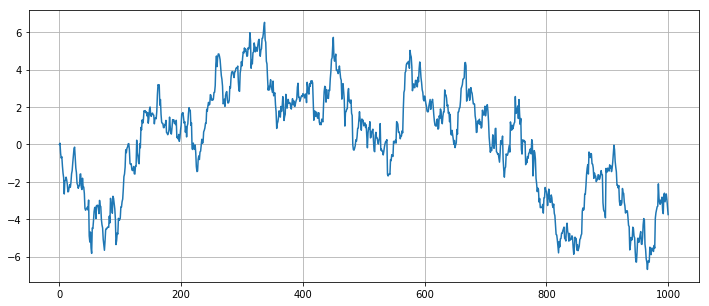

In [33]:
plt.figure(figsize=(12,5))
plt.plot(data_laplace)
plt.grid()
plt.show()

In [34]:
d = np.diff(data_laplace)

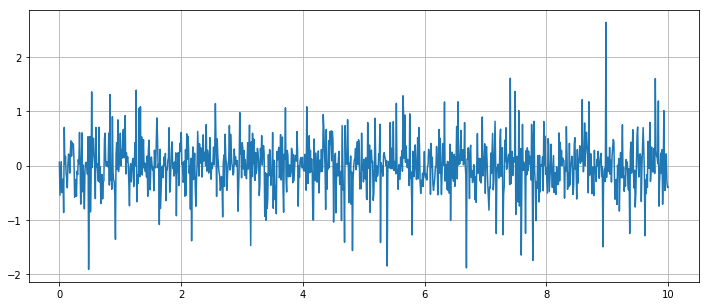

In [35]:
grid = np.linspace(0, 10, 1000)

plt.figure(figsize=(12,5))
plt.plot(grid, d)
plt.grid()
plt.show()

In [36]:
dd= d[250:] - d[:-250] 

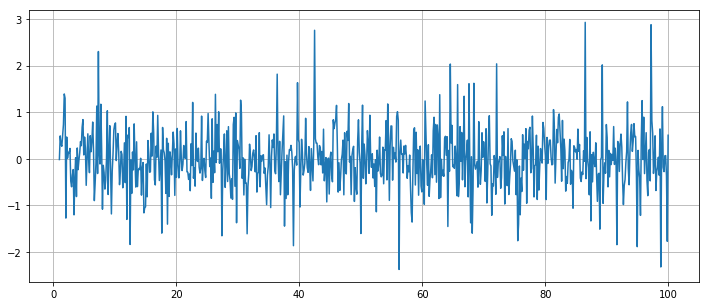

In [37]:
plt.figure(figsize=(12,5))
plt.plot(np.linspace(1, 100, len(dd)), dd)
plt.grid()
plt.show()

В предоставленных данных избавиться от тренда и сезонности. Для этого необходимо правильно определить период сезонности. Сделан вывод по  полученным остаткам.

In [38]:
data = np.loadtxt('./resources/hw_data.txt')

In [39]:
data_acf = sms.tsa.acf(data, nlags=len(data), fft=False)

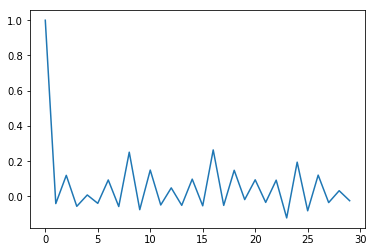

In [42]:
plt.plot(data_acf[:30])

In [43]:
d = np.diff(data)

In [44]:
grid = np.linspace(0, 10, 1000)

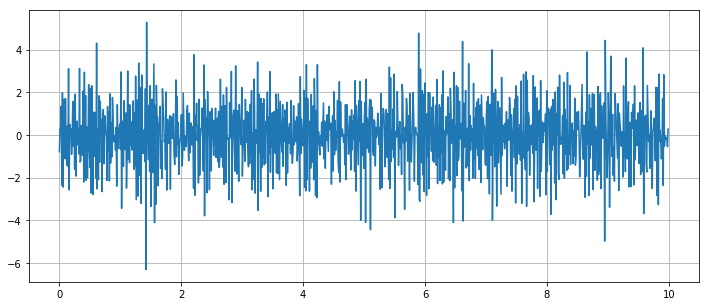

In [45]:
plt.figure(figsize=(12,5))
plt.plot(grid[:-1], d)
plt.grid()
plt.show()

In [46]:
dd = data[8:] - data[:-8] 

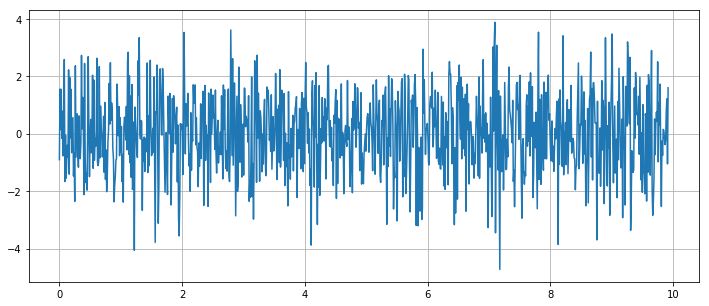

In [47]:
plt.figure(figsize=(12,5))
plt.plot(grid[:-8], dd)
plt.grid()
plt.show()

In [54]:
from statsmodels.tsa.seasonal import STL

data_residual = STL(dd, period=8).fit().resid

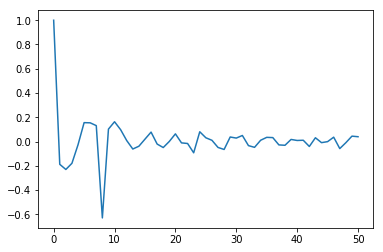

In [55]:
plt.plot(sms.tsa.acf(data_residual, nlags=50))

In [56]:
sms.tsa.stattools.kpss(data_residual) # гипотезу о стационарности ряда не отвергаем

(0.011718091424150784,
 0.1,
 22,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [57]:
sms.tsa.acf(data_residual, nlags=len(data), fft=False, qstat=True) # гипотеза "о белом шуме" отвергается

(array([ 1.00000000e+00, -1.88076831e-01, -2.30545100e-01, -1.79684605e-01,
        -2.68975559e-02,  1.55585080e-01,  1.54102984e-01,  1.30936371e-01,
        -6.30056285e-01,  1.02198751e-01,  1.62916706e-01,  9.74252105e-02,
         7.86676732e-03, -6.18805111e-02, -3.88857514e-02,  1.95255744e-02,
         7.75785723e-02, -2.10917091e-02, -4.97537050e-02,  6.49190505e-04,
         6.30296142e-02, -1.13035581e-02, -1.63467290e-02, -9.30839715e-02,
         8.03351710e-02,  3.08085404e-02,  1.00766287e-02, -4.89766001e-02,
        -6.56316155e-02,  3.71935177e-02,  2.82817296e-02,  4.96852761e-02,
        -3.38945205e-02, -4.80233460e-02,  1.03438935e-02,  3.42932257e-02,
         3.22566803e-02, -2.80186576e-02, -3.10837451e-02,  1.70398321e-02,
         8.58472226e-03,  1.04496290e-02, -4.08756112e-02,  3.09072106e-02,
        -9.39406916e-03, -1.08502539e-03,  3.56753935e-02, -5.82967952e-02,
        -9.71552666e-03,  4.42213057e-02,  3.95252066e-02, -5.64567307e-02,
        -2.8